In [2]:
"""Created by Ehsan Ghane Feb 2024"""

# modified: March 19 2024

'Created by Ehsan Ghane Feb 2024'

In [3]:
import datetime
e = datetime.datetime.now()
print ("Current date and time = %s" % e)
print ("Today's date:  = %s/%s/%s" % (e.day, e.month, e.year))
print ("The time is now: = %s:%s:%s" % (e.hour, e.minute, e.second))

Current date and time = 2025-01-13 10:45:11.063034
Today's date:  = 13/1/2025
The time is now: = 10:45:11


## 1- Import packages

In [4]:
import sys
sys.version
from pathlib import Path
print(Path.cwd())


import numpy as np
import pandas as pd
import scipy.io as sio
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

import matplotlib.pyplot as plt
import random
import matplotlib as mpl
mpl.rcParams['font.size'] = 14


from torch.cuda import current_device, get_device_name

if torch.cuda.is_available():
    print(f'Current GPU: {get_device_name(current_device())}')
else:
    print('GPU not available.')

d:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_


C:\Users\Ehsan\AppData\Local\Temp\ipykernel_25392\512025457.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Current GPU: NVIDIA GeForce RTX 4090


## 2- Data prepration

In [5]:
# The clean_dataset function to delete samples...
#with a length less than 101 and truncate samples with a length greater than 101 to only include the first 101 time steps. Here's the modified function:

# ref: https://se.mathworks.com/help/deeplearning/ug/long-short-term-memory-networks.html
def clean_rand_fft_dataset(X, y):
    #function to keep only samples with length=>101 
    error_idx = []
    l = y.shape[0]
    for i in range(l):
        if y[i][0].shape[1] < 101:
            error_idx.append(i)
    
    cleaned_X = np.delete(X, error_idx, axis=0)
    cleaned_y = np.delete(y, error_idx, axis=0)

    cleaned_X_tr = []
    cleaned_y_tr = []

    for i in range(cleaned_X.shape[0]):
        # Truncate or pad sequences to 101 time steps
        truncated_X = cleaned_X[i][0][:, :101]
        truncated_y = cleaned_y[i][0][:, :101]
        cleaned_X_tr.append(truncated_X.transpose())
        cleaned_y_tr.append(truncated_y.transpose())

    print(len(cleaned_X_tr))
    return np.array(cleaned_X_tr), np.array(cleaned_y_tr)
"""
# as an ulternative, think of resizing the larger or shorter sequences
# The clean_dataset function to delete samples with ...
#a length less than 101 and truncate samples with a length greater than 101 to only include the first 101 time steps. Here's the modified function:
"""
# ref: https://se.mathworks.com/help/deeplearning/ug/long-short-term-memory-networks.html
def clean_shear_fft_dataset(X, y):
    error_idx = []
    l = y.shape[0]
    min_length= 8
    for i in range(l):
        if y[i][0].shape[1] < min_length:
            error_idx.append(i)
    
    cleaned_X = np.delete(X, error_idx, axis=0)
    cleaned_y = np.delete(y, error_idx, axis=0)

    cleaned_X_tr = []
    cleaned_y_tr = []

    for i in range(cleaned_X.shape[0]):
        # Truncate or pad sequences to 101 time steps
        truncated_X = cleaned_X[i][0][:, :min_length]
        truncated_y = cleaned_y[i][0][:, :min_length]
        cleaned_X_tr.append(truncated_X.transpose())
        cleaned_y_tr.append(truncated_y.transpose())

    print(len(cleaned_X_tr))
    return np.array(cleaned_X_tr), np.array(cleaned_y_tr), error_idx


In [6]:
"""
    Cleans and interpolates the dataset to a specified number of time steps.

    Parameters:
    - X: The input features as a NumPy array of shape (samples, 1, time_steps, features).
    - y: The target values as a NumPy array of shape (samples, 1, time_steps, features).
    - new_length: The desired length of the time series after interpolation.

    Returns:
    - The cleaned and interpolated X and y datasets, and the indices of any removed samples.
"""

"""
def clean_rand_fft_dataset(X, y, new_length=200):

    error_idx = []
    l = y.shape[0]
    
    interpolated_X = []
    interpolated_y = []

    for i in range(l):
        # Extract the current sample
        current_X = X[i][0]
        current_y = y[i][0]
            
        # Interpolate both X and y to the new_length
        interpolated_X_sample = interpolate_time_series(current_X.transpose(1, 0)[np.newaxis, :, :], new_length=new_length)
        interpolated_y_sample = interpolate_time_series(current_y.transpose(1, 0)[np.newaxis, :, :], new_length=new_length)
        
        # Add the interpolated samples to the lists
        interpolated_X.append(interpolated_X_sample.squeeze())
        interpolated_y.append(interpolated_y_sample.squeeze())

    print(len(interpolated_X))
    return np.array(interpolated_X), np.array(interpolated_y)
"""
def interpolate_time_series(data, new_length=200):
    """
    Interpolates each feature in the data from the current length to a new length.
    """
    batch_size, current_length, num_features = data.shape
    new_time_scale = np.linspace(0, 1, new_length)
    old_time_scale = np.linspace(0, 1, current_length)
    interpolated_data = np.zeros((batch_size, new_length, num_features))
    
    for i in range(batch_size):
        for j in range(num_features):
            interpolated_data[i, :, j] = np.interp(new_time_scale, old_time_scale, data[i, :, j])
    
    return interpolated_data


In [7]:
from sklearn.preprocessing import RobustScaler

# function to scale data into between -1 and 1

# The input to fit_transform() must be in 2D, so we reshape the 1D data[i, :] into the 2D [num_samples * sequence_length, features]
# fit() + transform() + reshape() + flatten ()
# scalers are important for later use, such as scaling test data using the same parameters used for scaling the training data.

def normalizer(data, scalers=None):
    # Reshape data to (num_samples * sequence_length, num_features)
    num_samples, sequence_length, num_features = data.shape
    data_reshaped = data.reshape(-1, num_features)
    
    if scalers is None:
        scalers = []
    
    data_scaled = np.zeros_like(data_reshaped)
    
    for i in range(num_features):
        if scalers is None or len(scalers) <= i or scalers[i] is None:
            # If no scalers provided or scaler not available, create a new one
            scaler = RobustScaler()
            scaler.fit(data_reshaped[:, i].reshape(-1, 1))
            scalers.append(scaler)
        else:
            # Use provided scaler
            scaler = scalers[i]
        
        data_scaled[:, i] = scaler.transform(data_reshaped[:, i].reshape(-1, 1)).flatten()
    
    data_scaled_reshaped = data_scaled.reshape(num_samples, sequence_length, num_features)
    
    return data_scaled_reshaped, scalers

def normalizer_shear(data, scalers=None, components_to_normalize=[3]): #need for modifications
    # Reshape data to (num_samples * sequence_length, num_features)
    num_samples, sequence_length, num_features = data.shape
    data_reshaped = data.reshape(-1, num_features)
    
    if scalers is None:
        scalers = [None] * num_features
    
    if components_to_normalize is None:
        components_to_normalize = list(range(num_features))

    data_scaled = np.zeros_like(data_reshaped)
    
    for i in range(num_features):
        if i in components_to_normalize:
            if scalers[i] is None:
                # If scaler not available, create a new one
                scaler = RobustScaler()
                scaler.fit(data_reshaped[:, i].reshape(-1, 1))
                scalers[i] = scaler
            else:
                # Use provided scaler
                scaler = scalers[i]
            
            data_scaled[:, i] = scaler.transform(data_reshaped[:, i].reshape(-1, 1)).flatten()
        else:
            # If the component is not specified to normalize, keep it unchanged
            data_scaled[:, i] = data_reshaped[:, i]
    
    data_scaled_reshaped = data_scaled.reshape(num_samples, sequence_length, num_features)
    
    return data_scaled_reshaped, scalers


# function to generater data_loader for training, validation and test set in both mean and full field samples
### Numpy into pytorch tensors
def turn_to_loader(xtrain,ytrain,
                   xval,yval,
                   xtest,ytest, batch_size = None):
    
    if batch_size is None:
        batch_size=32
    
    xtrain_scaled=xtrain
    xval_scaled=xval
    xtest_scaled=xtest
    ytrain_scaled=ytrain
    yval_scaled=yval
    ytest_scaled=ytest
    
    # Apply Min-Max scaling
   
    xtrain_scaled, x_scaler = normalizer(xtrain)
    ytrain_scaled, y_scaler = normalizer(ytrain)
    xval_scaled, _ = normalizer(xval, scalers=x_scaler)
    xtest_scaled, _ = normalizer(xtest, scalers=x_scaler)
    yval_scaled, _ = normalizer(yval, scalers=y_scaler)
    ytest_scaled, _ = normalizer(ytest, scalers=y_scaler)
 

    # Create TensorDatasets
    train_dataset = TensorDataset(
        torch.from_numpy(xtrain_scaled).float(),
        torch.from_numpy(ytrain_scaled).float())
        #ytrain_tensor
    val_dataset = TensorDataset(
        torch.from_numpy(xval_scaled).float(),
        torch.from_numpy(yval_scaled).float())
        #yval_tensor

    test_dataset = TensorDataset(
        torch.from_numpy(xtest_scaled).float(),
        torch.from_numpy(ytest_scaled).float())

    # Create DataLoader

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)
    return train_loader,val_loader,test_loader , x_scaler, y_scaler


def turn_to_loader_shear(xtrain,ytrain,
                   xval,yval,
                   xtest,ytest, batch_size = None):
    
    if batch_size is None:
        batch_size=32
    
    xtrain_scaled=xtrain
    xval_scaled=xval
    xtest_scaled=xtest
    ytrain_scaled=ytrain
    yval_scaled=yval
    ytest_scaled=ytest
    
    # Apply Min-Max scaling
   
    
    xtrain_scaled, x_scaler = normalizer_shear(xtrain)
    ytrain_scaled, y_scaler = normalizer_shear(ytrain)
    xval_scaled, _ = normalizer_shear(xval, scalers=x_scaler)
    xtest_scaled, _ = normalizer_shear(xtest, scalers=x_scaler)
    yval_scaled, _ = normalizer_shear(yval, scalers=y_scaler)
    ytest_scaled, _ = normalizer_shear(ytest, scalers=y_scaler)
  

    # Create TensorDatasets
    train_dataset = TensorDataset(
        torch.from_numpy(xtrain_scaled).float(),
        torch.from_numpy(ytrain_scaled).float())
        #ytrain_tensor
    val_dataset = TensorDataset(
        torch.from_numpy(xval_scaled).float(),
        torch.from_numpy(yval_scaled).float())
        #yval_tensor

    test_dataset = TensorDataset(
        torch.from_numpy(xtest_scaled).float(),
        torch.from_numpy(ytest_scaled).float())

    # Create DataLoader

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)
    return train_loader,val_loader,test_loader, x_scaler, y_scaler 

In [8]:

def ploting_loss_function(train_losses, val_losses, train_losses_iter):
        
    # Create figure and primary axes
    fig, ax1 = plt.subplots()

    # Plotting the training and validation loss over epochs on primary axes
    ax1.plot(train_losses, label='Training Loss (Epoch)', linestyle='--', color='black', marker='*')
    ax1.plot(val_losses, label='Validation Loss (Epoch)', linestyle='--', color='darkred', marker='^')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss (log scale)')

    # Create secondary x-axis for iterations
    ax2 = ax1.twiny()

    # Plotting the training and validation loss over iterations on secondary axes
    #ax2.plot(val_losses_iter, label='Validation Loss (Iteration)', linestyle=':', color='red', marker='x')
    ax2.plot(train_losses_iter, label='Training Loss (Iteration)', linestyle='--', color='black', alpha=0.3)
    ax2.set_xlabel('Batch iteration')

    # Ensure the secondary x-axis ticks are synchronized with primary x-axis
    ax2.set_xticks([])  # Hide secondary x-axis ticks

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    # Get the last values of x and y for legend placement
    last_epoch = len(train_losses)
    last_train_loss = train_losses[-1]
    last_val_loss = val_losses[-1]

    # Remove legend border and increase font size
    legend = ax1.legend(loc=(0.5, 0.77))
    legend2 = ax2.legend(loc=(0.5, 0.9))
    frame = legend.get_frame()
    frame2 = legend2.get_frame()
    frame.set_edgecolor('1.0')  # Set border color to white or any color you prefer
    plt.setp(legend.get_texts())  # Set font size
    frame2.set_edgecolor('1.0')  # Set border color to white or any color you prefer
    plt.setp(legend2.get_texts())  # Set font size

    # Adding text to display the last values
    ax1.text(last_epoch, last_train_loss, f'Last Train Loss: {last_train_loss:.4f}', ha='right', va='top')
    ax1.text(last_epoch, last_val_loss, f'Last Val Loss: {last_val_loss:.4f}', ha='right', va='top')

    # Manually set the tick positions and labels for the secondary x-axis
    iteration_labels = [str(i) for i in range(0, len(train_losses_iter), 2000)]  # Labels for every 1000th iteration
    iteration_ticks = [i for i in range(0, len(train_losses_iter), 2000)]  # Tick positions for every 1000th iteration
    ax2.set_xticks(iteration_ticks)
    ax2.set_xticklabels(iteration_labels)

    plt.show()
    return fig

#import numpy as np
#import matplotlib.pyplot as plt

def plot_input_sample(test_loader, sample_id=None):
    if sample_id is None:
        sample_id = np.random.randint(1, 8)
    print(f'Plotting input load from sample {sample_id}')

    x_target, y_target = test_loader.dataset[sample_id]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Plot x_target in the first subplot
    ax1.plot(x_target[:, 0], label=r'$\varepsilon_1$')
    ax1.plot(x_target[:, 1], label=r'$\varepsilon_2$')
    ax1.plot(x_target[:, 2], label=r'$\varepsilon_3$')
    ax1.plot(x_target[:, 3], label=r'$\varepsilon_4$')
    ax1.plot(x_target[:, 4], label=r'$\varepsilon_5$')
    ax1.plot(x_target[:, 5], label=r'$\varepsilon_6$')
    ax1.set_xlabel('Time increment')
    ax1.set_ylabel(r'Normalized Strain, $\varepsilon$')
    ax1.legend()

    # Plot y_target in the second subplot
    ax2.plot(y_target[:, 0], label=r'$\sigma_1$')
    ax2.plot(y_target[:, 1], label=r'$\sigma_2$')
    ax2.plot(y_target[:, 2], label=r'$\sigma_3$')
    ax2.plot(y_target[:, 3], label=r'$\sigma_4$')
    ax2.plot(y_target[:, 4], label=r'$\sigma_5$')
    ax2.plot(y_target[:, 5], label=r'$\sigma_6$')
    ax2.set_xlabel('Time increment')
    ax2.set_ylabel(r'Normalized Stress, $\sigma$') #the values are scaled using RubustScaler and are not in [MPa]
    ax2.legend()

    plt.tight_layout()
    plt.show()
    #save.fig()

# A function to evaluate the loss against samples in the test set and plot a random sample
def plot_test_sample(model, test_loader, test_sample_id=None, stress_components = None):

    # Testing phase
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"The model parameters are on {device}")
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            test_batch_x, test_batch_y = batch_x.to(device), batch_y.to(device)
            criterion = nn.MSELoss()
            test_outputs = model(test_batch_x)
            test_loss += criterion(test_outputs, test_batch_y).item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    #########################################
    # plotting a random sample from the test set
    if test_sample_id == None:
        test_sample_id = random.randint(0, len(test_loader.dataset)-1)
    
    print(f'Selected Test Sample ID: {test_sample_id}')

    x_target, y_target = test_loader.dataset[test_sample_id]

    # Load the pre-trained model
    model.eval()  # Set the model to evaluation mode

    # Make predictions
    with torch.no_grad():
        y_pred = model(x_target.to(device))

    # Convert predictions and y_target to NumPy arrays for plotting
    # Move tensors to the same device
    device_to_cpu = x_target.device
    print(f"The device is changed to {device_to_cpu} for plotting purposes")
    y_pred = y_pred.to(device_to_cpu)

    # Plot each line with a label

    if stress_components == None:
        stress_components = random.randint(0,5)
    
    print(f'Stress Component is: {stress_components}')

    plt.plot(y_pred[:, stress_components], label='Model prediction')
    plt.plot(y_target[:, stress_components], label='Target stress')
    # Remove legend border and increase font size
    legend = plt.legend()
    frame = legend.get_frame()
    frame.set_edgecolor('1.0')  # Set border color to white or any color you prefer
    plt.setp(legend.get_texts())  # Set font size

    # Set labels and title
    plt.xlabel('Time increment')
    # Create a list of LaTeX labels for stress components
    stress_labels = [r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$', r'$\sigma_4$', r'$\sigma_5$', r'$\sigma_6$']

    plt.ylabel(f'Normalized stress, {stress_labels[stress_components]}')

    # Show the plot
    plt.show()
    # plot ground truth data
    #plot_input_sample(test_loader, sample_id=test_sample_id)


def plot_sequence_length(input_data, database_name):
    length = []

    for i in range(input_data.shape[0]):
        length.append(input_data[i][0].shape[1])

    # Plot
    plt.figure(figsize=(8, 6))
    bars = plt.barh(range(len(length)), length)
    plt.xlabel('Length of data samples',fontsize=14)
    plt.ylabel('Number of samples',fontsize=14)
    #plt.title(f'Data Samples vs Length for "{database_name}"')

    # Add maximum and minimum borders
    max_length = max(length)
    min_length = min(length)
    plt.axvline(x=max_length, color='darkred', linestyle='--', label=f'Max Length: {max_length}')
    plt.axvline(x=min_length, color='darkred', linestyle='--', label=f'Min Length: {min_length}')
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig()
    # Example usage:
    #plot_data(full_field_data['X_train_rand_FFT'], 'Random FFT Database')



In [9]:
def Strain_tensor_rotate(arr):
	# parameters: 
	# arr : sample from input space with 6 sequential components (input strains) and 9 static features (material properties)
	# arr.shape = (num of features=15, num of time increments =101)

    # Number of time increments
    num_iteration = arr.shape[1]

    # Generate random rotation angles
    rotation = np.random.rand(3)
    
    si = 2 * np.pi * rotation[0] #yaw angle
    theta = 2 * np.pi * rotation[1] # pitch angle
    phi = 2 * np.pi * rotation[2] # roll angle

    # Rotation matrices
    Rz = np.array([[np.cos(si), np.sin(si), 0],
                   [-np.sin(si), np.cos(si), 0],
                   [0, 0, 1]])
    
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])
    
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(phi), -np.sin(phi)],
                   [0, np.sin(phi), np.cos(phi)]])

    # Composite rotation matrix
    M = Rz @ Ry @ Rx

    # Initialize the rotated tensor array
    arr_rot = np.zeros_like(arr)

    # Rotate each tensor
    for i in range(num_iteration):
        eps_tensor = np.array([[arr[0, i], arr[3, i] / 2, arr[5, i] / 2],
                               [arr[3, i] / 2, arr[1, i], arr[4, i] / 2],
                               [arr[5, i] / 2, arr[4, i] / 2, arr[3, i]]])

        eps_tensor_new = M @ eps_tensor @ M.T
        # to test if the rotation has an impact on invariants:
        #print(np.trace(eps_tensor))
        #print(np.trace(eps_tensor_new))
        #print(np.linalg.det(eps_tensor))
        #print(np.linalg.det(eps_tensor_new))
        
        # write the rotated sequential strain components
        arr_rot[0, i] = eps_tensor_new[0, 0]
        arr_rot[1, i] = eps_tensor_new[1, 1]
        arr_rot[2, i] = eps_tensor_new[2, 2]
        arr_rot[3, i] = 2 * eps_tensor_new[0, 1]
        arr_rot[4, i] = 2 * eps_tensor_new[1, 2]
        arr_rot[5, i] = 2 * eps_tensor_new[0, 2]
        arr_rot[6:, i] = arr[6:,i]

    return arr_rot, rotation


def Stress_tensor_rotate(arr, rotation):
	# parameters: 
	# arr : sample from output space with 6 sequential components (output stress)
	# arr.shape = (num of features=6, num of time increments =101)
	# rotation = vector of random rotation angle which is built during the strain rotation process

    # Number of time incremenets
    num_iteration = arr.shape[1]

    # Generate random rotation angles
    #rotation = np.random.rand(3)
    
    si = 2 * np.pi * rotation[0] #yaw angle
    theta = 2 * np.pi * rotation[1] # pitch angle
    phi = 2 * np.pi * rotation[2] # roll angle

    # Rotation matrices
    Rz = np.array([[np.cos(si), np.sin(si), 0],
                   [-np.sin(si), np.cos(si), 0],
                   [0, 0, 1]])
    
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])
    
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(phi), -np.sin(phi)],
                   [0, np.sin(phi), np.cos(phi)]])

    # Composite rotation matrix
    M = Rz @ Ry @ Rx

    # Initialize the rotated tensor array
    arr_rot = np.zeros_like(arr)

    # Rotate each tensor
    for i in range(num_iteration):
        eps_tensor = np.array([[arr[0, i], arr[3, i] / 2, arr[5, i] / 2],
                               [arr[3, i] / 2, arr[1, i], arr[4, i] / 2],
                               [arr[5, i] / 2, arr[4, i] / 2, arr[3, i]]])

        eps_tensor_new = M @ eps_tensor @ M.T
        
        
        # write the roated sequential stress components
        arr_rot[0, i] = eps_tensor_new[0, 0]
        arr_rot[1, i] = eps_tensor_new[1, 1]
        arr_rot[2, i] = eps_tensor_new[2, 2]
        arr_rot[3, i] = 2 * eps_tensor_new[0, 1]
        arr_rot[4, i] = 2 * eps_tensor_new[1, 2]
        arr_rot[5, i] = 2 * eps_tensor_new[0, 2]

    return arr_rot

# To test these utility functions, write: 
#pd.DataFrame(Strain_tensor_rotate(X_test[1]))
#pd.DataFrame(Stress_tensor_rotate(Y_test[1], np.random.rand(3)))
#import torch

def calculate_von_mises_stress(y):
    # Reshape y to be compatible with tensor operations
    y = y.view(y.size(0), -1, 6)  # Assuming the last dimension is always 6 for stress components
    
    # Calculate von Mises stress for each sample in the batch
    von_labels = torch.sqrt(0.5 * (
        (y[:,:,0]-y[:,:,1])**2 + 
        (y[:,:,1]-y[:,:,2])**2 + 
        (y[:,:,2]-y[:,:,0])**2 + 
        6*(y[:,:,3]**2 + y[:,:,4]**2 + y[:,:,5]**2)
    ))
    
    return von_labels


def calculate_stress_invariants(y):
    # Reshape y to be compatible with tensor operations
    y = y.view(y.size(0), -1, 6)  # Assuming the last dimension is always 6 for stress components
    
    # Calculate von Mises stress for each sample in the batch
    von_labels = torch.sqrt(0.5 * (
        (y[:,:,0]-y[:,:,1])**2 + 
        (y[:,:,1]-y[:,:,2])**2 + 
        (y[:,:,2]-y[:,:,0])**2 + 
        6*(y[:,:,3]**2 + y[:,:,4]**2 + y[:,:,5]**2)
    ))
    
    # Calculate trace of the stress tensor for each sample in the batch
    trace = y[:,:,0] + y[:,:,1] + y[:,:,2]
    
    # Calculate determinant of the stress tensor for each sample in the batch
    determinant = y[:,:,0]*(y[:,:,1]*y[:,:,2] - y[:,:,5]**2) - y[:,:,3]*(y[:,:,3]*y[:,:,2] - y[:,:,5]*y[:,:,4]) + y[:,:,4]*(y[:,:,3]*y[:,:,5] - y[:,:,1]*y[:,:,4])    
    return von_labels, trace, determinant

def evaluate_predictions(y_pred, y_target):
    # Calculate stress invariants for predictions and targets
    von_labels_pred, trace_pred, determinant_pred = calculate_stress_invariants(y_pred)
    von_labels_target, trace_target, determinant_target = calculate_stress_invariants(y_target)
    
    # Calculate absolute error, squared error, and error
    abs_error = torch.abs(von_labels_pred - von_labels_target)
    squared_error = abs_error ** 2
    error = von_labels_pred - von_labels_target
    
    # Calculate MAE, RMSE, and MBE
    MAE = torch.mean(abs_error)
    RMSE = torch.sqrt(torch.mean(squared_error))
    MBE = torch.mean(error)
    
    return MAE, RMSE, MBE

# Example usage:
# Assuming y_pred and y_target are tensors containing the predicted and target stress components
#MAE, RMSE, MBE = evaluate_predictions(y_pred, y_target)
#print("MAE:", MAE.item())
#print("RMSE:", RMSE.item())
#print("MBE:", MBE.item())



In [10]:
## MEAN-FIELD_DATA- function to open and clean MF data
import h5py

def access_low_fidility_data():

    # Open the MATLAB v7.3 file
    ## only materials scaled:
    mat_file = h5py.File(r'D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\27355_Random_MF_Plastic_Simulations_Woven_original_values_only_materials_scaled.mat', 'r')
    print(mat_file.keys())
    x_cell_array = mat_file['X_all_original_only_mat_scaled']
    y_cell_array = mat_file['Y_all_original_only_mat_scaled']

    #mat_file = h5py.File(r'D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\Matlab files - data sets or trained networks\27355_Random_MF_Plastic_Simulations_Woven_MinMaxFeaturesScaled_individual_samples_scasled.mat')
    ## all features scaled:
    #mat_file = h5py.File(r'D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\27355_Random_MF_Plastic_Simulations_Woven_MinMaxFeaturesScaled_individual_samples_scaled.mat', 'r')
    #mat_file = h5py.File(r'D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\Matlab files - data sets or trained networks\27355_Random_MF_Plastic_Simulations_Woven_MinMaxFeaturesScaled_individual_samples_scasled.mat')
    # Read the cell arrays into NumPy arrays
    #x_cell_array = mat_file['X_all_scaled']
    #y_cell_array = mat_file['Y_all_scaled']

    #mat_file.keys()

    x_cell = x_cell_array[:]
    y_cell = y_cell_array[:]

    # Define the number of sample_ids and the desired shape for x_data
    n_sample_ids = x_cell_array.size
    x_data_shape = (n_sample_ids, 2001, 15)

    # Create an empty NumPy array to store x_data for each sample_id
    x_data_array = np.empty(x_data_shape)

    # Iterate over all sample_ids to read inputs
    for sample_id in range(n_sample_ids):
        for i, x_cell in enumerate(x_cell_array):
            sample_array = np.array(mat_file[x_cell[sample_id]])
            # Check if the sample_array has the expected shape (2001, 15)
            x_data_array[sample_id] = sample_array

    # as a test, print out one inpu sample as a dataframe
    #print(pd.DataFrame(x_data_array[650]))

    #n_sample_ids = y_cell_array.size
    y_data_shape = (n_sample_ids, 2001, 6)

    # Create an empty NumPy array to store y_data for each sample_id
    y_data_array = np.empty(y_data_shape)

    # Iterate over all sample_ids to read outputs
    for sample_id in range(n_sample_ids):
        for i, y_cell in enumerate(y_cell_array):
            sample_array = np.array(mat_file[y_cell[sample_id]])
            y_data_array[sample_id] = sample_array

    mat_file.close()

    ################## save data into a npz file
    save_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_"
    file_path = save_directory + "data_arrays_MF_random_only_materials_scaled.npz"
    # or
    #file_path = save_directory + "data_arrays_all_features_scaled.npz"

    # Assuming you have both x_data_array and y_data_array as NumPy arrays
    np.savez(file_path, x_data_array=x_data_array, y_data_array=y_data_array)

#access_low_fidility_data()

In [11]:
#empty

## 3-Setup the running system

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## 4-Neural network model implementaiton

To train the PyTorch model using CUDA as the device, you need to ensure that both the model and the data are transferred to the GPU

In [13]:
#original GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=None):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=3)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        out, h_n = self.gru1(x)
        out = self.dropout(out)

        # out shape: (batch_size, sequence_length, hidden_size)
        out = self.fc(out)

        return out
class ForecastingGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=None, num_layers=3, forecast_horizon=20):
        super(ForecastingGRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size,output_size, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)  # Output size is multiplied by the forecast horizon

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        # Forward pass through the GRU layer
        out, h_n = self.gru1(x)
        out = self.dropout(out)

        # out shape: (batch_size, sequence_length, hidden_size)

        # Flatten the output for fully connected layer
        out = out[:, -1, :]  # Taking the last hidden state as input for forecasting
        out = self.fc(out)

        return out.view(out.size(0), -1, output_size)  # Reshape to (batch_size, forecast_horizon, output_size)

# Two inputs GRU model
class GRUModel_2inputs(nn.Module):
    def __init__(self, input_size, hidden_size, intermediate_size, output_size, dropout=None):
        super(GRUModel_2inputs, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=3)
        self.dropout = nn.Dropout(p=dropout)
        
        # First fully connected layer
        self.fc1 = nn.Linear(hidden_size + 9, intermediate_size)
        
        # Second fully connected layer
        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        
        # Splitting the input tensor into two parts
        x_gru = x[:, :, :6]
        x_concat = x[:, :, 6:15]

        # Pass the first part through the GRU layers
        out_gru, h_n = self.gru1(x_gru)
        out_gru = self.dropout(out_gru)

        # Concatenate the output of the GRU layers with the second part of input tensor
        out = torch.cat((out_gru, x_concat), dim=2)

        # Pass the concatenated tensor through the first fully connected layer
        out = self.fc1(out)
        
        # Apply an activation function (e.g., ReLU)
        out = torch.relu(out)
        
        # Pass the result through the second fully connected layer
        out = self.fc2(out)

        return out

        """
                # Apply logic to remove noises
        for batch_index in range(out.size(0)):  # Iterate over batch dimension
            for i in range(6):  # The stress output dimension
                if torch.sum(x[batch_index, :, i]) <= 1e-6:
                    out[batch_index, :, i] = out[batch_index, :, i] * torch.zeros(1, out.size(1)).to(device)
        """
#**Xavier/Glorot Initialization:**

#Xavier/Glorot initialization was proposed by Xavier Glorot and Yoshua Bengio in their paper "Understanding the difficulty of training deep feedforward neural networks". The key idea behind Xavier/Glorot initialization is to initialize the weights of the network such that the variance of the inputs and outputs of each layer remains approximately the same during forward and backward propagation. For a layer with \(n_{\text{in}}\) input units and \(n_{\text{out}}\) output units, the weights are initialized from a uniform or normal distribution with mean 0 and variance \(\frac{2}{n_{\text{in}} + n_{\text{out}}}\). In PyTorch, you can use `torch.nn.init.xavier_uniform_()` or `torch.nn.init.xavier_normal_()` to initialize the weights with Xavier initialization.

#**He Initialization:**

#He initialization, proposed by Kaiming He et al., is an improvement over Xavier initialization, specifically designed for deep networks with rectified linear unit (ReLU) activation functions. The idea behind He initialization is similar to Xavier, but it takes into account the non-linearity introduced by ReLU activation functions. For a layer with \(n_{\text{in}}\) input units, the weights are initialized from a normal distribution with mean 0 and variance \(\frac{2}{n_{\text{in}}}\). In PyTorch, you can use `torch.nn.init.kaiming_uniform_()` or `torch.nn.init.kaiming_normal_()` to initialize the weights with He initialization.

# modified GRU model with He initialization and cusom activation function: ReLu
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=None):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_layer = TransformerEncoderLayer(d_model=input_size, nhead=8, dim_feedforward=hidden_size)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=3)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, src):
        src = src.permute(1, 0, 2)  # Transformer expects (sequence_length, batch_size, input_size)
        out = self.transformer_encoder(src)
        out = out.permute(1, 0, 2)  # Reshape back to (batch_size, sequence_length, input_size)
        out = self.fc(out)
        return out
    
    
class ModifiedGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=None):
        super(ModifiedGRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=3)
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        # Initialize weights with He initialization
        self.initialize_weights()

    def initialize_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                init.kaiming_uniform_(param.data)

    def forward(self, x):
        out, h_n = self.gru1(x)
        out = self.relu(out)  # Applying ReLU activation function
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [14]:
# model trainer NO invariant considered
import os

class ModelTrainerDataDriven:
    def __init__(self, train_loader, val_loader, test_loader, hyperparameters):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.hyperparameters = hyperparameters
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.train_losses = []
        self.val_losses = []
        self.train_losses_iter = []
        self.val_losses_iter = []
        self.best_val_loss = float('inf')
        self.counter = 0

    def initialize_model(self):
        input_size = self.hyperparameters['input_size']
        hidden_size = self.hyperparameters['hidden_size']
        output_size = self.hyperparameters['output_size']
        drop_out = self.hyperparameters['drop_out']

        if 'pretrained_model_path' in self.hyperparameters:
            print("Model loaded from pretrained RNN") #, pretrained_model_path)
            pretrained_model_path = self.hyperparameters['pretrained_model_path']
            pretrained_model = GRUModel(input_size, hidden_size, output_size, drop_out)
            pretrained_model.load_state_dict(torch.load(pretrained_model_path))
            self.model = pretrained_model.to(self.device)
        else:
            print("Model is trained from scratch with random initialization")
            torch.manual_seed(self.hyperparameters['seed'])
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            self.model = GRUModel(input_size, hidden_size, output_size, drop_out).to(self.device)
            
        for param in self.model.parameters():
            #param.requires_grad = False
            print('initial parameter space shape: ',param.shape)
            #print(param)
            break

    def define_loss_optimizer_scheduler(self):
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hyperparameters['learning_rate'])
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.9)

    def train(self):
        num_epochs = self.hyperparameters['num_epochs']
        patience = self.hyperparameters['patience']

        start = time.time()
        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            for batch_x, batch_y in self.train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                                    # Both losses are combiled here
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                self.train_losses_iter.append(loss.item())

            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch_x, val_batch_y in self.val_loader:
                    val_batch_x, val_batch_y = val_batch_x.to(self.device), val_batch_y.to(self.device)
                    val_outputs = self.model(val_batch_x)
                    val_loss += self.criterion(val_outputs, val_batch_y)

            val_loss /= len(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_losses_iter.append(val_loss)

            self.scheduler.step()

            print(f'\nEpoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {self.optimizer.param_groups[0]["lr"]}')

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.counter = 0
            else:
                self.counter += 1

            if self.counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1} due to no improvement in validation loss.')
                break

        model_directory = self.hyperparameters['save_directory']
        torch.save(self.model.state_dict(), self.hyperparameters['save_directory']+self.hyperparameters['model_name'])
        print("`\n model saved as: ", model_directory)
        end = time.time()
        print("\nThe time spend on the training is :", (end-start) * 10**3, "ms")

    def plot_loss_function(self):
        self.val_losses = [loss.cpu() for loss in self.val_losses]
        fig = ploting_loss_function(self.train_losses, self.val_losses, self.train_losses_iter)
        filename = f'GRU_MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.png'
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.png')
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.eps')
        #fig.savefig(os.path.join(self.hyperparameters['save_directory'], filename))

    def evaluate_test_set(self):
        self.model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for test_batch_x, test_batch_y in self.test_loader:
                test_batch_x, test_batch_y = test_batch_x.to(self.device), test_batch_y.to(self.device)
                test_outputs = self.model(test_batch_x)
                test_loss += self.criterion(test_outputs, test_batch_y).item()

        test_loss /= len(self.test_loader)
        print(f'Test Loss: {test_loss:.4f}')


In [15]:
# model trainer NO invariant considered
import os

class ModelTrainer2Inputs:
    def __init__(self, train_loader, val_loader, test_loader, hyperparameters):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.hyperparameters = hyperparameters
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.train_losses = []
        self.val_losses = []
        self.train_losses_iter = []
        self.val_losses_iter = []
        self.best_val_loss = float('inf')
        self.counter = 0

    def initialize_model(self):
        input_size = self.hyperparameters['input_size']
        hidden_size = self.hyperparameters['hidden_size']
        output_size = self.hyperparameters['output_size']
        drop_out = self.hyperparameters['drop_out']

        if 'pretrained_model_path' in self.hyperparameters:
            print("Model loaded from pretrained RNN") #, pretrained_model_path)
            pretrained_model_path = self.hyperparameters['pretrained_model_path']
            pretrained_model = GRUModel_2inputs(input_size, hidden_size, output_size, drop_out)
            pretrained_model.load_state_dict(torch.load(pretrained_model_path))
            self.model = pretrained_model.to(self.device)
        else:
            print("Model is trained from scratch with random initialization")
            torch.manual_seed(self.hyperparameters['seed'])
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            self.model = GRUModel_2inputs(input_size, hidden_size, output_size, drop_out).to(self.device)
            
        for param in self.model.parameters():
            #param.requires_grad = False
            print('initial parameter space shape: ',param.shape)
            #print(param)
            break

    def define_loss_optimizer_scheduler(self):
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hyperparameters['learning_rate'])
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.9)

    def train(self):
        num_epochs = self.hyperparameters['num_epochs']
        patience = self.hyperparameters['patience']

        start = time.time()
        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            for batch_x, batch_y in self.train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                                    # Both losses are combiled here
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                self.train_losses_iter.append(loss.item())

            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch_x, val_batch_y in self.val_loader:
                    val_batch_x, val_batch_y = val_batch_x.to(self.device), val_batch_y.to(self.device)
                    val_outputs = self.model(val_batch_x)
                    val_loss += self.criterion(val_outputs, val_batch_y)

            val_loss /= len(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_losses_iter.append(val_loss)

            self.scheduler.step()

            print(f'\nEpoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {self.optimizer.param_groups[0]["lr"]}')

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.counter = 0
            else:
                self.counter += 1

            if self.counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1} due to no improvement in validation loss.')
                break

        model_directory = self.hyperparameters['save_directory']
        torch.save(self.model.state_dict(), self.hyperparameters['save_directory']+self.hyperparameters['model_name'])
        print("`\n model saved as: ", model_directory)
        end = time.time()
        print("\nThe time spend on the training is :", (end-start) * 10**3, "ms")

    def plot_loss_function(self):
        self.val_losses = [loss.cpu() for loss in self.val_losses]
        fig = ploting_loss_function(self.train_losses, self.val_losses, self.train_losses_iter)
        filename = f'GRU_MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.png'
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.png')
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.eps')
        #fig.savefig(os.path.join(self.hyperparameters['save_directory'], filename))

    def evaluate_test_set(self):
        self.model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for test_batch_x, test_batch_y in self.test_loader:
                test_batch_x, test_batch_y = test_batch_x.to(self.device), test_batch_y.to(self.device)
                test_outputs = self.model(test_batch_x)
                test_loss += self.criterion(test_outputs, test_batch_y).item()

        test_loss /= len(self.test_loader)
        print(f'Test Loss: {test_loss:.4f}')


In [16]:
## FULL_FIELD_DATA

# online data path: 
#from google.colab import drive
#drive.mount('/content/drive')
#full_field_data = sio.loadmat(r'/content/drive/MyDrive/Colab_Notebooks/WovenFullField_GloballyScaled_0_1_fixedFeatures.mat')
#print(data.keys())

# local full-field data path:
# GLobally scales
#fill_field_dir_path = r'D:\1_PhD_projects\3_code\Justin Matlab codes\WovenFullField_GloballyScaled_0_1_fixedFeatures.mat'
# Components are individualy scaled between [-1,1]
#full_field_dir_path = r'D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\Matlab files - data sets or trained networks\3nd_WovenFullField_individuallyScaled_1max_scaledFeatures.mat'
"""full_field_data = sio.loadmat(full_field_dir_path)
print(full_field_data.keys())

xtrain, ytrain, error_idx = clean_rand_fft_dataset(full_field_data['X_train_rand_FFT'], full_field_data['Y_train_rand_FFT'])
xtest, ytest, error_idx = clean_rand_fft_dataset(full_field_data['X_test_rand_FFT'], full_field_data['Y_test_rand_FFT'])
xval, yval, error_idx = clean_rand_fft_dataset(full_field_data['X_valid_rand_FFT'], full_field_data['Y_valid_rand_FFT'])
"""

full_field_dir_path = r'D:\1_PhD_projects\3_code\Data_generation_for_finite_element_soutions\3D_RVE_FFT\10e3_wovenFFT_only_materials_scaled.mat'
full_field_data = sio.loadmat(full_field_dir_path)
print(full_field_data.keys())


xtrain, ytrain = clean_rand_fft_dataset(full_field_data['X_train_rand_FFT'], full_field_data['Y_train_rand_FFT'])
xtest, ytest = clean_rand_fft_dataset(full_field_data['X_test_rand_FFT'], full_field_data['Y_test_rand_FFT'])
xval, yval = clean_rand_fft_dataset(full_field_data['X_valid_rand_FFT'], full_field_data['Y_valid_rand_FFT'])

#deleting the outlier
# Compute maximum absolute value at the first feature for each data sample
max_abs_values = np.max(np.abs(ytrain[:, :, 0]), axis=1)

# Find the index of the data sample with the maximum absolute value
max_index = np.argmax(max_abs_values)

# Remove the data sample with the maximum absolute value
xtrain = np.delete(xtrain, max_index, axis=0)
ytrain = np.delete(ytrain, max_index, axis=0)
#print(xtrain.shape)

"""
new_l = 101
xtrain_interpolated_np = interpolate_time_series(xtrain, new_length=new_l)
ytrain_interpolated_np = interpolate_time_series(ytrain, new_length=new_l)

# Optionally, if you have validation or test datasets
xval_interpolated_np = interpolate_time_series(xval, new_length=new_l)
yval_interpolated_np = interpolate_time_series(yval, new_length=new_l)
xtest_interpolated_np = interpolate_time_series(xtest, new_length=new_l)
ytest_interpolated_np = interpolate_time_series(ytest, new_length=new_l)



num_rotations = 10
num_samples = xtrain.shape[0]

# Initialize augmented data arrays
# The total size is original samples + num_rotations per sample
x_augmented_train = np.empty((num_samples * (num_rotations + 1), xtrain.shape[1], xtrain.shape[2]))
y_augmented_train = np.empty((num_samples * (num_rotations + 1), ytrain.shape[1], ytrain.shape[2]))

for i in range(num_samples):
    original_x_sample = xtrain[i].transpose()  # Transposing to [num_features_x, time_steps]
    original_y_sample = ytrain[i].transpose()  # Transposing to [num_features_y, time_steps]
    
    # Directly store the original sample in augmented dataset
    x_augmented_train[i * (num_rotations + 1)] = xtrain[i]
    y_augmented_train[i * (num_rotations + 1)] = ytrain[i]

    for j in range(1, num_rotations + 1):
        # Rotate each sample and transpose back to match [time_steps, num_features]
        x_rotated, rotation = Strain_tensor_rotate(original_x_sample)
        y_rotated = Stress_tensor_rotate(original_y_sample, rotation)

        x_augmented_train[i * (num_rotations + 1) + j] = x_rotated.transpose()  # Back to [time_steps, num_features_x]
        y_augmented_train[i * (num_rotations + 1) + j] = y_rotated.transpose()  # Back to [time_steps, num_features_y]

# Now, x_augmented_train and y_augmented_train contain the original and rotated samples
train_loader_f,val_loader_f,test_loader_f , x_scaler_f, y_scaler_f = turn_to_loader(x_augmented_train,y_augmented_train,
                                                     xval,yval,
                                                     xtest,ytest, batch_size = 8)     
"""
# how many training samples do you want to consider?
split_index=787
train_loader_f,val_loader_f,test_loader_f , x_scaler_f, y_scaler_f = turn_to_loader(xtrain[:split_index],ytrain[:split_index],
                                                     xval,yval,
                                                     xtest,ytest, batch_size = 8)
"""
## Specific cases of Full-field data
# SHEAR 12
full_field_dir_path = r'D:\1_PhD_projects\3_code\Data_generation_for_finite_element_soutions\3D_RVE_FFT\3rd_WovenFullField_FFT_cyclic_shear12_only_mat_scaled.mat'
full_field_data_s12 = sio.loadmat(full_field_dir_path)
print(full_field_data_s12.keys())


xtrain, ytrain, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_train_fft12'], full_field_data_s12['Y_train_fft12'])
xtest, ytest, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_test_fft12'], full_field_data_s12['Y_test_fft12'])
xval, yval, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_valid_fft12'], full_field_data_s12['Y_valid_fft12'])

# 
train_loader_fft_s12, val_loader_fft_s12, test_loader_fft_s12 , x_scaler_fft_s12, y_scaler_fft_s12= turn_to_loader(xtrain,ytrain,
                                                     xval,yval,
                                                     xtest,ytest, batch_size = 4)

# SHEAR 23
full_field_dir_path = r'D:\1_PhD_projects\3_code\Data_generation_for_finite_element_soutions\3D_RVE_FFT\3rd_WovenFullField_FFT_cyclic_shear23_only_mat_scaled.mat'
full_field_data_s23 = sio.loadmat(full_field_dir_path)
print(full_field_data_s23.keys())


xtrain, ytrain, error_idx = clean_shear_fft_dataset(full_field_data_s23['X_train_fft23'], full_field_data_s23['Y_train_fft23'])
xtest, ytest, error_idx = clean_shear_fft_dataset(full_field_data_s23['X_test_fft23'], full_field_data_s23['Y_test_fft23'])
xval, yval, error_idx = clean_shear_fft_dataset(full_field_data_s23['X_valid_fft23'], full_field_data_s23['Y_valid_fft23'])

#
train_loader_fft_s23, val_loader_fft_s23, test_loader_fft_s23 , x_scaler_fft_s23, y_scaler_fft_s23= turn_to_loader(xtrain,ytrain,
                                                     xval,yval,
                                                     xtest,ytest, batch_size = 4)
"""


# EXAMPLE for checking data set sequence length
#plot_sequence_length(full_field_data['X_train_rand_FFT'], 'FFT  Database')

dict_keys(['__header__', '__version__', '__globals__', 'X_test_rand_FFT', 'X_train_rand_FFT', 'X_valid_rand_FFT', 'Y_test_rand_FFT', 'Y_train_rand_FFT', 'Y_valid_rand_FFT'])
787
91
99


"\n## Specific cases of Full-field data\n# SHEAR 12\nfull_field_dir_path = r'D:\x01_PhD_projects\x03_code\\Data_generation_for_finite_element_soutions\x03D_RVE_FFT\x03rd_WovenFullField_FFT_cyclic_shear12_only_mat_scaled.mat'\nfull_field_data_s12 = sio.loadmat(full_field_dir_path)\nprint(full_field_data_s12.keys())\n\n\nxtrain, ytrain, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_train_fft12'], full_field_data_s12['Y_train_fft12'])\nxtest, ytest, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_test_fft12'], full_field_data_s12['Y_test_fft12'])\nxval, yval, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_valid_fft12'], full_field_data_s12['Y_valid_fft12'])\n\n# \ntrain_loader_fft_s12, val_loader_fft_s12, test_loader_fft_s12 , x_scaler_fft_s12, y_scaler_fft_s12= turn_to_loader(xtrain,ytrain,\n                                                     xval,yval,\n                                                     xtest,ytest, batch_size = 4)\n\n# SHEAR 23\nf

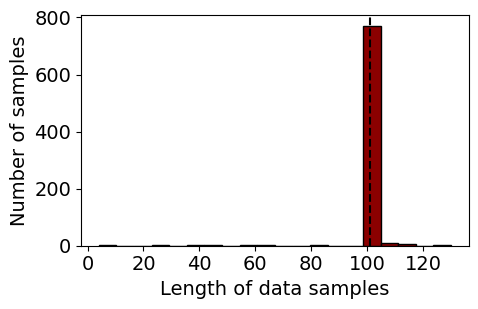

In [17]:
def plot_sequence_length(input_data, database_name):
    length = [sample.shape[1] for sample in input_data[:, 0]]  # Extracting the lengths of each sample from the original data
    
    # Plot histogram
    plt.figure(figsize=(5, 3))
    plt.hist(length, bins=20, color='darkred', edgecolor='black')
    plt.xlabel('Length of data samples',fontsize=14)
    plt.ylabel('Number of samples',fontsize=14)
    #plt.title(f'Distribution of Data Sample Lengths for "{database_name}"')

    # Add maximum and minimum borders
    max_length = max(length)
    min_length = min(length)
    plt.axvline(x=101, color='black', linestyle='--', label=f'Max Length: {max_length}')
    #plt.axvline(x=min_length, color='red', linestyle='--', label=f'Min Length: {min_length}')
    #plt.legend(fontsize=14)
    # Set x-axis ticks at intervals of 2
    plt.xticks(np.arange(0, max_length + 1, 20, dtype=int),fontsize=14)  # Set x-axis tick font size and ensure integer ticks
    #plt.grid()
    plt.savefig('imagesFFT_random_length_distribution_.eps', format='eps')
    plt.show()

# Example usage:
plot_sequence_length(full_field_data['X_train_rand_FFT'], 'Random FFT Database')

In [18]:
full_field_data['X_train_rand_FFT'].shape[0]

800

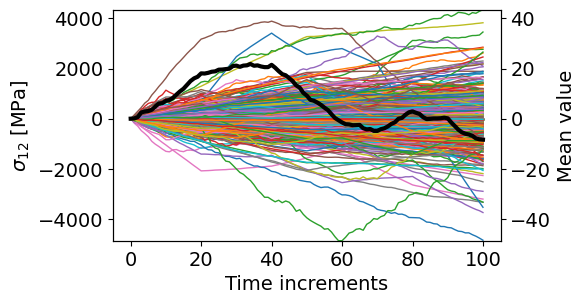

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


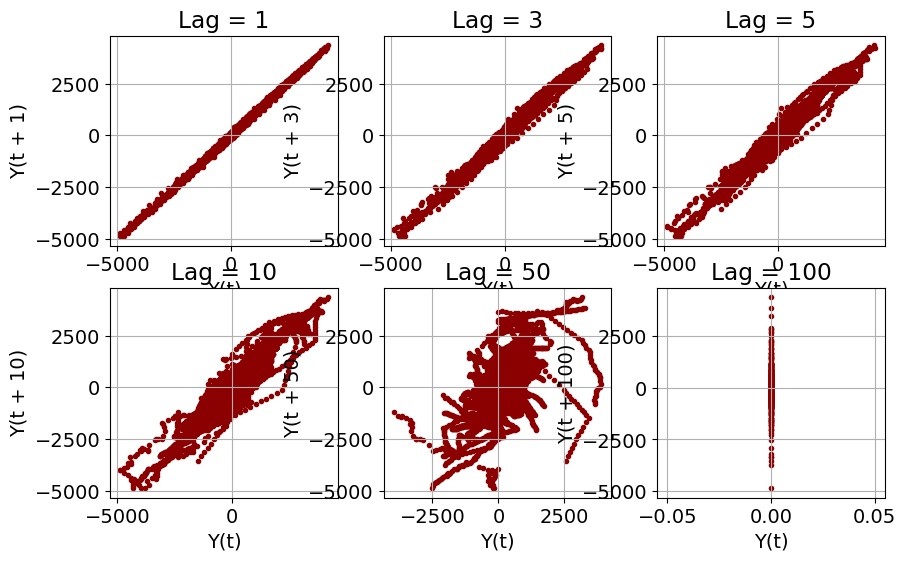

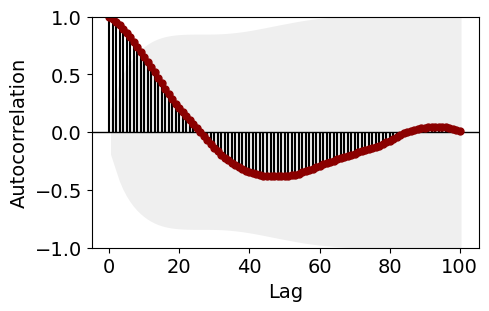

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib as mpl
from matplotlib.collections import PolyCollection, LineCollection

def plot_acf_colors(ax, markercolor="darkred", linecolor="black", facecolor="silver", barcolor="black", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    for item in ax.collections:
        # change the color of the confidence interval 
        if isinstance(item, PolyCollection):
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if isinstance(item, LineCollection):
            item.set_color(barcolor)
    # change the color of the markers
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    return ax



# Assume ytrain is a dataset with shape [num_samples, time_steps, features]
# We'll use the first component of each sample for plotting
component_index = 1

data_array=ytrain
# Plot the first component of each sample
import matplotlib.pyplot as plt

# Assuming data_array, component_index, and other variables are defined

# Create the main plot
fig, ax1 = plt.subplots(figsize=(5,3))

# Plot individual samples
for i in range(data_array.shape[0]):
    ax1.plot(data_array[i, :, component_index], linewidth=1, markersize=1)

# Set labels and legend for the main plot
ax1.set_xlabel('Time increments',fontsize=14)
ax1.set_ylabel(r'$\sigma_{12}$ [MPa]',fontsize=14)
#ax1.legend(['Sample data'],fontsize=14)

# Create a twin axis for the mean plot
ax2 = ax1.twinx()

# Calculate mean between samples for each time step
mean_across_samples = np.mean(data_array[:, :, component_index], axis=0)

# Plot the mean on the secondary axis
ax2.plot(mean_across_samples, label='Mean Across Samples', linewidth=3, color='k')
ax2.set_ylabel('Mean value',fontsize=14)
#ax2.legend(['Mean across samples'],fontsize=14)

# Align the zero line for both y-axes
all_data = np.concatenate([data_array[:, :, component_index].flatten(), mean_across_samples])
y_min, y_max = np.min(all_data), np.max(all_data)
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min/100, y_max/100)

# Save the plot
plt.savefig(f'sep2024_images\stress{component_index}_scatterAndMean_plot.eps', format='eps', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


# Plot autocorrelation using plot_acf
data = pd.DataFrame(data_array[:, :, component_index].T)
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot lag plots for lag values ranging from 1 to 50 with steps of 5
lag_values = [1,3,5,10,50,100]
for lag, ax in zip(lag_values, axes.flatten()):
    pd.plotting.lag_plot(data, lag=lag, marker='.', c='darkred', ax=ax)
    ax.set_title(f'Lag = {lag}')
    ax.set_xlabel('Y(t)')
    ax.set_ylabel(f'Y(t + {lag})')
    ax.grid(True)
# Adjust spacing between subplots
#plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

#plt.tight_layout()
#plt.savefig(f'images_FFpaper\stress{component_index}_autocorrolation_lag_plot.eps', format='eps')
#plt.show()



# Assuming mean_across_samples is your data
data = pd.DataFrame(mean_across_samples)

f, ax = plt.subplots(figsize=(5, 3))
plot_acf(data.values.squeeze(), lags=100, ax=ax)
plot_acf_colors(ax)

# Customizing y-axis label
ax.set_xlabel('Lag',fontsize=14)
ax.set_ylabel('Autocorrelation',fontsize=14)

# Adjusting the number of y-axis ticks
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=6)
plt.tick_params(axis='both', which='major')
# Removing the title
plt.title('')

plt.savefig(f"sep2024_images/acf_stress{component_index}_101_interpolation.eps", format='eps', bbox_inches='tight', dpi=300)
plt.savefig(f"images_FFpaper/acf_stress{component_index}_101_interpolation.png")
plt.show()



In [20]:
"""
import numpy as np

# Placeholder for the clean_rand_fft_dataset function return
# Assuming it returns xtrain, ytrain, error_idx with shapes as described
# xtrain.shape = [batch size, time_steps, num_features_x (15)]
# ytrain.shape = [batch size, time_steps, num_features_y (6)]

num_rotations = 100
num_samples = xtrain.shape[0]

# Initialize augmented data arrays
# The total size is original samples + num_rotations per sample
x_augmented_train = np.empty((num_samples * (num_rotations + 1), xtrain.shape[1], xtrain.shape[2]))
y_augmented_train = np.empty((num_samples * (num_rotations + 1), ytrain.shape[1], ytrain.shape[2]))

for i in range(num_samples):
    original_x_sample = xtrain[i].transpose()  # Transposing to [num_features_x, time_steps]
    original_y_sample = ytrain[i].transpose()  # Transposing to [num_features_y, time_steps]
    
    # Directly store the original sample in augmented dataset
    x_augmented_train[i * (num_rotations + 1)] = xtrain[i]
    y_augmented_train[i * (num_rotations + 1)] = ytrain[i]

    for j in range(1, num_rotations + 1):
        # Rotate each sample and transpose back to match [time_steps, num_features]
        x_rotated, rotation = Strain_tensor_rotate(original_x_sample)
        y_rotated = Stress_tensor_rotate(original_y_sample, rotation)

        x_augmented_train[i * (num_rotations + 1) + j] = x_rotated.transpose()  # Back to [time_steps, num_features_x]
        y_augmented_train[i * (num_rotations + 1) + j] = y_rotated.transpose()  # Back to [time_steps, num_features_y]

# Now, x_augmented_train and y_augmented_train contain the original and rotated samples

"""

'\nimport numpy as np\n\n# Placeholder for the clean_rand_fft_dataset function return\n# Assuming it returns xtrain, ytrain, error_idx with shapes as described\n# xtrain.shape = [batch size, time_steps, num_features_x (15)]\n# ytrain.shape = [batch size, time_steps, num_features_y (6)]\n\nnum_rotations = 100\nnum_samples = xtrain.shape[0]\n\n# Initialize augmented data arrays\n# The total size is original samples + num_rotations per sample\nx_augmented_train = np.empty((num_samples * (num_rotations + 1), xtrain.shape[1], xtrain.shape[2]))\ny_augmented_train = np.empty((num_samples * (num_rotations + 1), ytrain.shape[1], ytrain.shape[2]))\n\nfor i in range(num_samples):\n    original_x_sample = xtrain[i].transpose()  # Transposing to [num_features_x, time_steps]\n    original_y_sample = ytrain[i].transpose()  # Transposing to [num_features_y, time_steps]\n    \n    # Directly store the original sample in augmented dataset\n    x_augmented_train[i * (num_rotations + 1)] = xtrain[i]\n    

In [21]:
"""
## High fidility model training from scratch WITHOUT any physical invariants:

# replace with your save directory
model_high_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models"


# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.001,
    'patience': 12,
    'seed': 42,
    'save_directory': model_high_directory,
}
# Define the model name using hyperparameters
model_name = f'_scratch_high_fidelity_model_{hyperparameters["learning_rate"]}_{hyperparameters["patience"]}_robust_outlierDeleted786_scaled_data_batch8_timesteps101' 

# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name

# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_f, val_loader=val_loader_f, test_loader=test_loader_f, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Evaluate on test set
trainer.evaluate_test_set()

# Plot loss function
trainer.plot_loss_function()
#using 100 training samples --> Test Loss: 0.6544  (10 patiance)
#using 300 training samples --> Test Loss: 0.1586 (20 patience), 0.1791 (10 patience)
#using 500 training samples --> Test Loss: 0.1261 

# using the whole data set:
#he time spend on the training is : 14149.37873085938 ms
#Test Loss for batch=32: 0.0752
#he time spend on the training is : 105374.11499023438 ms
#Test Loss for batch=8: 0.0334
#The time spend on the training is : 153238.13819885254 ms
#Test Loss for batch=4: 0.0470
#interpolation to 101 results in Test Loss: 0.1042 with  800 samples
#truncation to 101 results in Test Loss: 0.0613 withh 787 samples
"""

'\n## High fidility model training from scratch WITHOUT any physical invariants:\n\n# replace with your save directory\nmodel_high_directory = r"D:\x01_PhD_projects\x03_code\\Data_generation_for_the_mean_field_solution\\PyFormatPhase2\\Phase_2\\last_version_\x0crom_scratch_high_fidelity_models"\n\n\n# Define your hyperparameters dictionary\nhyperparameters = {\n    \'input_size\': 15,\n    \'hidden_size\': 512,\n    \'output_size\': 6,\n    \'drop_out\': 0.5,\n    \'num_epochs\': 2000,\n    \'learning_rate\': 0.001,\n    \'patience\': 12,\n    \'seed\': 42,\n    \'save_directory\': model_high_directory,\n}\n# Define the model name using hyperparameters\nmodel_name = f\'_scratch_high_fidelity_model_{hyperparameters["learning_rate"]}_{hyperparameters["patience"]}_robust_outlierDeleted786_scaled_data_batch8_timesteps101\' \n\n# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary\nhyperparameters[\'model_name\'] = model_name\n\n# Initialize ModelTrainer obje

D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\GRU_scratch_high_fidelity_model_0.001_10_robust_outlierDeleted786_scaled_data_batch8_timesteps101.pth
torch.Size([1536, 15])
Parameter containing:
tensor([[ 3.6943e-02,  2.7495e-02, -2.0712e-02,  ...,  1.9131e-02,
          1.0272e-02,  1.6551e-02],
        [ 3.5152e-05,  6.7719e-03,  2.8485e-03,  ...,  3.6134e-04,
          3.6099e-04,  3.5643e-04],
        [ 1.4006e-02, -2.1075e-02, -2.4650e-02,  ..., -7.5057e-03,
         -7.5007e-03, -7.1907e-03],
        ...,
        [ 8.4775e-04, -8.3047e-03, -8.7605e-03,  ..., -1.3860e-02,
         -1.7984e-02,  4.7698e-02],
        [ 1.2043e-02,  5.9968e-02, -3.8485e-02,  ..., -2.4942e-02,
         -1.2620e-02,  2.0252e-02],
        [-1.3410e-02,  1.8316e-02, -3.8268e-03,  ...,  2.4903e-03,
          1.2878e-02, -1.4706e-02]], requires_grad=True)
GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=Tr

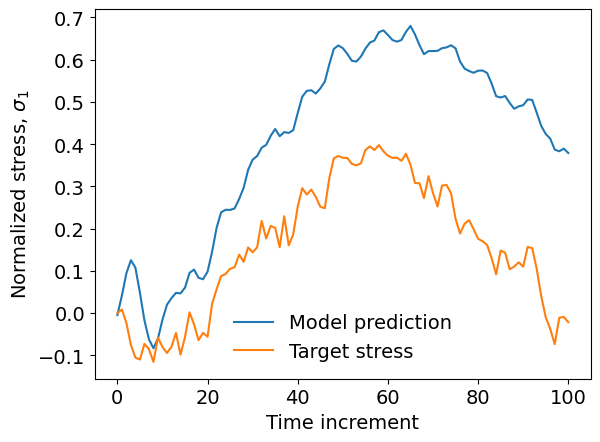

In [22]:
# check point for model parameters:
#model trained on data with oulier
#model_directory = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models"
#                   + '\\GRU_scratch_high_fidelity_model_0.001_10_robust_original787_scaled_data_batch8_timesteps101.pth') 
#model trained on data without outlier:
model_directory = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models"
                   + '\\GRU_scratch_high_fidelity_model_0.001_10_robust_outlierDeleted786_scaled_data_batch8_timesteps101.pth') 

#+ _robust_original800_scaled_data_batch128_timesteps200 

print(model_directory)

# Load the pre-trained model
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(model_directory))

for param in model.parameters():
    #param.requires_grad = False
    print(param.shape)
    print(param)
    break

# Load the pre-trained model
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(model_directory))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Testing phase
plot_test_sample(model, test_loader_f, test_sample_id=None, stress_components = None)
#plot_test_sample(model, test_loader_f,scalers=y_scaler_f, test_sample_id=78, stress_components = 1)

# with the outpier Test Loss: 0.1936

In [23]:
"""
## High fidility model training with TWO seperate inputs from scratch WITHOUT any physical invariants:

# replace with your save directory
model_high_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_custom_inputs"

# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 6,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.001,
    'patience': 30,
    'seed': 42,
    'save_directory': model_high_directory,
}

# Define the model name using hyperparameters
model_name = f'\\scratch_high_fidelity_2inputs_model_{hyperparameters["learning_rate"]}_{hyperparameters["patience"]}_robust_outlierDeleted786_scaled_data_batch8_timesteps101.pth'

# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name

# Initialize ModelTrainer object
trainer = ModelTrainer2Inputs(train_loader=train_loader_f, val_loader=val_loader_f, test_loader=test_loader_f, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Evaluate on test set
trainer.evaluate_test_set()

# Plot loss function
trainer.plot_loss_function()
"""


'\n## High fidility model training with TWO seperate inputs from scratch WITHOUT any physical invariants:\n\n# replace with your save directory\nmodel_high_directory = r"D:\x01_PhD_projects\x03_code\\Data_generation_for_the_mean_field_solution\\PyFormatPhase2\\Phase_2\\last_version_\x0crom_scratch_high_fidelity_custom_inputs"\n\n# Define your hyperparameters dictionary\nhyperparameters = {\n    \'input_size\': 6,\n    \'hidden_size\': 512,\n    \'output_size\': 6,\n    \'drop_out\': 0.5,\n    \'num_epochs\': 2000,\n    \'learning_rate\': 0.001,\n    \'patience\': 30,\n    \'seed\': 42,\n    \'save_directory\': model_high_directory,\n}\n\n# Define the model name using hyperparameters\nmodel_name = f\'\\scratch_high_fidelity_2inputs_model_{hyperparameters["learning_rate"]}_{hyperparameters["patience"]}_robust_outlierDeleted786_scaled_data_batch8_timesteps101.pth\'\n\n# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary\nhyperparameters[\'model_name\'] = m

In [24]:
# model trainer considering the stress invariants in the loss function
#import torch
#import torch.nn as nn
import torch.nn.functional as F

class ModelTrainerWithInvariants:
    def __init__(self, train_loader, val_loader, test_loader, hyperparameters):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.hyperparameters = hyperparameters
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.train_losses = []
        self.val_losses = []
        self.train_losses_iter = []
        self.val_losses_iter = []
        self.best_val_loss = float('inf')
        self.counter = 0

    def initialize_model(self):
        input_size = self.hyperparameters['input_size']
        hidden_size = self.hyperparameters['hidden_size']
        output_size = self.hyperparameters['output_size']
        drop_out = self.hyperparameters['drop_out']

        torch.manual_seed(self.hyperparameters['seed'])
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        self.model = GRUModel(input_size, hidden_size, output_size, drop_out).to(self.device)

    def define_loss_optimizer_scheduler(self):
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hyperparameters['learning_rate'])
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.9)

    def train(self):
        num_epochs = self.hyperparameters['num_epochs']
        patience = self.hyperparameters['patience']
        start = time.time()
        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            for batch_x, batch_y in self.train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_x)
                
                # Calculate original MSE loss
                loss1 = self.criterion(outputs, batch_y)
                
                # Calculate von Mises stress and other stress invariants
                von_mises_pred, trace_pred, determinant_pred = calculate_stress_invariants(outputs)
                von_mises_target, trace_target, determinant_target = calculate_stress_invariants(batch_y)
                
                # Calculate additional losses
                loss2 = F.mse_loss(von_mises_pred, von_mises_target)
                loss3 = F.mse_loss(trace_pred, trace_target)
                loss4 = F.mse_loss(determinant_pred, determinant_target)
                
                # Combine all losses
                loss = loss1 + loss2 + loss3 + loss4
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                self.train_losses_iter.append(loss.item())

            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch_x, val_batch_y in self.val_loader:
                    val_batch_x, val_batch_y = val_batch_x.to(self.device), val_batch_y.to(self.device)
                    val_outputs = self.model(val_batch_x)
                    
                    val_loss1 = self.criterion(val_outputs, val_batch_y)
                    
                    von_mises_pred_val, trace_pred_val, determinant_pred_val = calculate_stress_invariants(val_outputs)
                    von_mises_target_val, trace_target_val, determinant_target_val = calculate_stress_invariants(val_batch_y)
                    
                    val_loss2 = F.mse_loss(von_mises_pred_val, von_mises_target_val)
                    val_loss3 = F.mse_loss(trace_pred_val, trace_target_val)
                    val_loss4 = F.mse_loss(determinant_pred_val, determinant_target_val)
                    
                    val_loss += val_loss1 + val_loss2 + val_loss3 + val_loss4

            val_loss /= len(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_losses_iter.append(val_loss)

            self.scheduler.step()

            print(f'\nEpoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {self.optimizer.param_groups[0]["lr"]}')

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.counter = 0
            else:
                self.counter += 1

            if self.counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1} due to no improvement in validation loss.')
                break

        model_directory = self.hyperparameters['save_directory']
        torch.save(self.model.state_dict(), self.hyperparameters['save_directory']+self.hyperparameters['model_name'])
        print("\nModel saved as:", model_directory)
        end = time.time()
        print("\n The time for training is :", (end-start) * 10**3, "ms")

    def plot_loss_function(self):
        self.val_losses = [loss.cpu() for loss in self.val_losses]
        fig = ploting_loss_function(self.train_losses, self.val_losses, self.train_losses_iter)
        filename = f'GRU_MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.svg'
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.png')
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.eps')
        fig.savefig(os.path.join(self.hyperparameters['save_directory'], filename))

    def evaluate_test_set(self):
        self.model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for test_batch_x, test_batch_y in self.test_loader:
                test_batch_x, test_batch_y = test_batch_x.to(self.device), test_batch_y.to(self.device)
                test_outputs = self.model(test_batch_x)
                test_loss += self.criterion(test_outputs, test_batch_y).item()

        test_loss /= len(self.test_loader)
        print(f'\n Test Loss: {test_loss:.6f}')


### 4_2 Training the model

In [31]:
## High fidility model training from scratch considering the invariants

# replace with your save directory
model_high_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_physicsa_invariants"

# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.002, #best results are reached with 0.002
    'patience': 30,
    'seed': 42,
    'save_directory': model_high_directory,  # replace with your save directory
    'model_name': '\\scratch_high_fidelity_physical_invariants_model_0.002_30_robust_scaled.pth'  
}

# Initialize ModelTrainer object
trainer = ModelTrainerWithInvariants(train_loader=train_loader_f, val_loader=val_loader_f, test_loader=test_loader_f, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Evaluate on test set
trainer.evaluate_test_set()

# Plot loss function
trainer._function()





Epoch [1/2000], Training Loss: 42770.7642, Validation Loss: 4913107.5000, Learning Rate: 0.002

Epoch [2/2000], Training Loss: 42610.5942, Validation Loss: 4888587.0000, Learning Rate: 0.002

Epoch [3/2000], Training Loss: 42828.8965, Validation Loss: 4913711.5000, Learning Rate: 0.002

Epoch [4/2000], Training Loss: 42721.7226, Validation Loss: 4912570.5000, Learning Rate: 0.002

Epoch [5/2000], Training Loss: 42742.8932, Validation Loss: 4913471.5000, Learning Rate: 0.0018000000000000002

Epoch [6/2000], Training Loss: 42709.5307, Validation Loss: 4913421.0000, Learning Rate: 0.0018000000000000002

Epoch [7/2000], Training Loss: 42700.2830, Validation Loss: 4913426.5000, Learning Rate: 0.0018000000000000002

Epoch [8/2000], Training Loss: 42699.3760, Validation Loss: 4913467.5000, Learning Rate: 0.0018000000000000002

Epoch [9/2000], Training Loss: 42679.0194, Validation Loss: 4913392.5000, Learning Rate: 0.0018000000000000002

Epoch [10/2000], Training Loss: 42754.7051, Validation 

AttributeError: 'ModelTrainerWithInvariants' object has no attribute '_function'

In [25]:
#empty

In [26]:
#empty

In [27]:
## MEAN_FIELD DATA
################ load the mean-field data from npz file
mean_field_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_"
file_path = mean_field_directory + "data_arrays_only_materials_scaled.npz"
# or
#file_oath = mean_field_directory + "data_arrays_all_features_scaled.npz"

# Load the saved data
loaded_data = np.load(file_path)

# Extract the arrays from the loaded data
x_data_array = loaded_data['x_data_array']
y_data_array = loaded_data['y_data_array']


#print(pd.DataFrame(y_data_array[0][:6,0:6]))

n_files_new = x_data_array.shape[0]
n_train = int(0.96 * n_files_new)
n_valid = int(0.03 * n_files_new)
n_test = n_files_new - n_train - n_valid

xm_train = x_data_array[:n_train]
ym_train = y_data_array[:n_train]
xm_valid = x_data_array[n_train:n_train + n_valid]
ym_valid = y_data_array[n_train:n_train + n_valid]
xm_test = x_data_array[n_train + n_valid:n_train + n_valid + n_test]
ym_test = y_data_array[n_train + n_valid:n_train + n_valid + n_test]

train_loader_m,val_loader_m,test_loader_m ,scalers_xm, scalers_ym= turn_to_loader(xm_train,ym_train,
                                                     xm_valid,ym_valid,
                                                     xm_test,ym_test, batch_size=128)

KeyboardInterrupt: 

In [19]:
print(n_files_new)
print(n_train)
print(n_test)

26903
25826
270


In [ ]:
"""
# main script to train the low-fidelity (mean-field) model
# replace with your save directory
model_low_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_low_fidelity_mdoels"  

# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.001, # the optimizer did not converge for 'learning_rate': 0.001
    'patience': 10,
    'seed': 42,
    'save_directory': model_low_directory,  # replace with your save directory
}
# Define the model name using hyperparameters
model_name = f'\\scratch_low_fidelity_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}_L2reg_15features_26903samples_batch128_timesteps2001.pth'

# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name


# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_m, val_loader=val_loader_m, test_loader=test_loader_m, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Plot loss function
trainer.plot_loss_function()

# Evaluate on test set
trainer.evaluate_test_set()
# initial parameter space shape:  torch.Size([1536, 15]) becasue we have 3*512=1536 training parameters in each layer of GRU
#using batch = 8--> Test Loss: 1.6257
# using batch=32--> Test Loss: 1.5938
#using batch = 64--> Test Loss: 1.4857 and Test Loss: 1.9608 (p=10)
#using batch =128 --> Test Loss: 1.6572 but mush faster
"""

'\n# main script to train the low-fidelity (mean-field) model\n# replace with your save directory\nmodel_low_directory = r"D:\x01_PhD_projects\x03_code\\Data_generation_for_the_mean_field_solution\\PyFormatPhase2\\Phase_2\\last_version_\x0crom_scratch_low_fidelity_mdoels"  \n\n# Define your hyperparameters dictionary\nhyperparameters = {\n    \'input_size\': 15,\n    \'hidden_size\': 512,\n    \'output_size\': 6,\n    \'drop_out\': 0.5,\n    \'num_epochs\': 2000,\n    \'learning_rate\': 0.001, # the optimizer did not converge for \'learning_rate\': 0.001\n    \'patience\': 10,\n    \'seed\': 42,\n    \'save_directory\': model_low_directory,  # replace with your save directory\n}\n# Define the model name using hyperparameters\nmodel_name = f\'\\scratch_low_fidelity_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}_L2reg_15features_26903samples_batch128_timesteps2001.pth\'\n\n# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary\nhy

D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_low_fidelity_mdoels\scratch_low_fidelity_model_lr0.001_p10_L2reg_15features_26903samples_batch128_timesteps2001.pth
torch.Size([1536, 15])
Parameter containing:
tensor([[ 3.5479e-04, -1.9362e-03, -7.5571e-03,  ..., -5.0497e-03,
         -5.0541e-03, -4.9979e-03],
        [-1.1673e-03, -3.8723e-04,  5.3360e-04,  ..., -4.6535e-03,
         -4.6526e-03, -4.8479e-03],
        [ 6.5884e-02, -5.2914e-02,  4.5132e-02,  ..., -1.4604e-01,
         -1.4011e-01, -1.5344e-01],
        ...,
        [-1.4807e-03, -2.5629e-03, -8.1661e-03,  ..., -5.9952e-03,
         -8.9213e-03,  4.0794e-02],
        [-3.8601e-02,  4.2908e-02, -1.8409e-02,  ..., -1.3141e-02,
          9.8551e-04,  3.7094e-02],
        [ 4.4994e-03,  1.0736e-04, -9.7671e-04,  ...,  6.3780e-03,
          1.7622e-02, -1.1391e-02]], requires_grad=True)
GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (

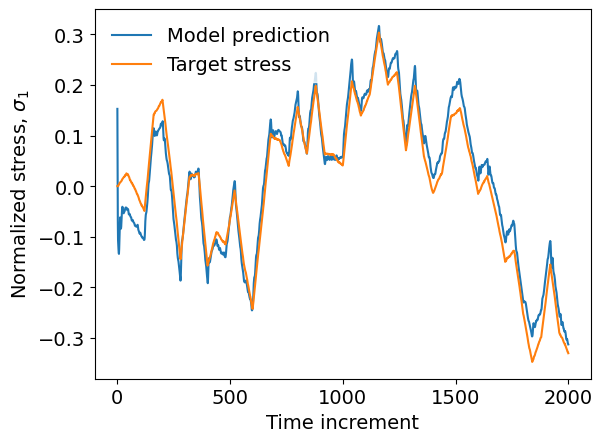

In [ ]:

# check point for model parameters:
model_directory = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_low_fidelity_mdoels"
                   + '\\scratch_low_fidelity_model_lr0.001_p10_L2reg_15features_26903samples_batch128_timesteps2001.pth')  
#scratch_low_fidelity_model_lr0.001_p10_L2reg_15features_26903samples_batch128_timesteps2001
print(model_directory)

# Load the pre-trained model
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(model_directory))

for param in model.parameters():
    #param.requires_grad = False
    print(param.shape)
    print(param)
    break

# Load the pre-trained model
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(model_directory))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Testing phase
plot_test_sample(model, test_loader_m, test_sample_id=113, stress_components = 0)
#plot_test_sample(model, test_loader_f,scalers=y_scaler_f, test_sample_id=78, stress_components = 1)

## 5-Transfer learning

In [27]:

## Transfer learning from low to high fidility simulations WITHOUT any physical invariants:

# replace with your save directory
saving_path = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" 
loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_low_fidelity_mdoels"
                            +'\\scratch_low_fidelity_model_lr0.001_p10_L2reg_15features_26903samples_batch128_timesteps2001.pth')
#'\\scratch_low_fidelity_model_0.0001_10_15features_inputs_batch8.pth'

# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.0001,
    'patience': 20,
    'seed': 42,
    'save_directory': saving_path,  # replace with pretrained saved model directory
}
# Define the model name using hyperparameters
model_name = f'transfer_lowTohigh_random_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth'
# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name
hyperparameters['pretrained_model_path'] = loading_pretrained_model


# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_f, val_loader=val_loader_f, test_loader=test_loader_f, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Plot loss function
trainer.plot_loss_function()

# Evaluate on test set
trainer.evaluate_test_set()
# Best performance original model using 100 samples --> Test Loss: 0.6544 (10 patiance)
# transfer model: Test Loss: 0.3362

# Best original from scratch model using 300 samples in training--> Test Loss: 0.1586 (20 patience), 0.1791 (10 patience)
#using lr=0.0001 --> Test Loss: 0.1711
#using lr=0.00005--> Test Loss: 0.1700 (patience:20), 0.1753 (patience:10)
#using lr=0.00001--> Test Loss: 0.2038

# best performance using 500 samples in training --> Test Loss: 0.1261

# Best original from scratch model using ~800 samples--> Test Loss: 0.03 
#batch4--> Test Loss: 0.1005, 126073.29 ms
#batch4 and lr=0.002--> Test Loss: 0.1276, 143217.90 ms
#batch8--> Test Loss: 0.0916 , 57640.88 ms
#batch16--> Test Loss: 0.1119,  31451.45 ms
#batch32-->  Test Loss: 0.1370, 12277.85 ms
#best of interpolated data Test Loss: 0.3181
# best of truncated data: Test Loss: 0.1390


'\n## Transfer learning from low to high fidility simulations WITHOUT any physical invariants:\n\n# replace with your save directory\nsaving_path = r"D:\x01_PhD_projects\x03_code\\Data_generation_for_the_mean_field_solution\\PyFormatPhase2\\Phase_2\\last_version_\\Transfer_model" \nloading_pretrained_model = (r"D:\x01_PhD_projects\x03_code\\Data_generation_for_the_mean_field_solution\\PyFormatPhase2\\Phase_2\\last_version_\x0crom_scratch_low_fidelity_mdoels"\n                            +\'\\scratch_low_fidelity_model_lr0.001_p10_L2reg_15features_26903samples_batch128_timesteps2001.pth\')\n#\'\\scratch_low_fidelity_model_0.0001_10_15features_inputs_batch8.pth\'\n\n# Define your hyperparameters dictionary\nhyperparameters = {\n    \'input_size\': 15,\n    \'hidden_size\': 512,\n    \'output_size\': 6,\n    \'drop_out\': 0.5,\n    \'num_epochs\': 2000,\n    \'learning_rate\': 0.0001,\n    \'patience\': 20,\n    \'seed\': 42,\n    \'save_directory\': saving_path,  # replace with pretraine

GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)
The model parameters are on cuda
Test Loss: 0.0972
Selected Test Sample ID: 10
The device is changed to cpu for plotting purposes
Stress Component is: 3
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or 

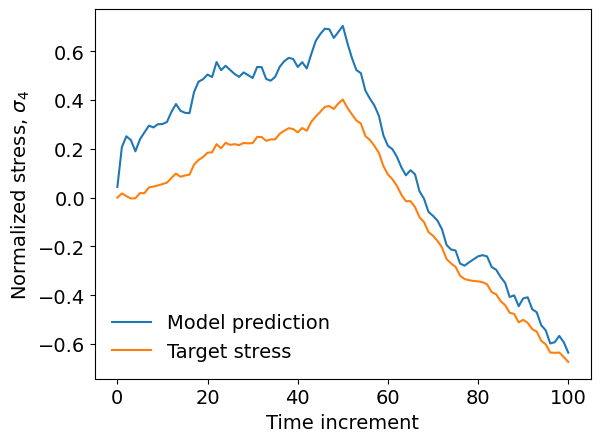

In [28]:
# Function to plot test samples and save them as images

#loading_dir= (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
 #              '\\transfer_low_to_high_fidelity_model_0.001_30_indiv_scaled.pth')

loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model"+
               '\\transfer_low_to_high_fidelity_model_0.001_30_robust_scaled.pth')

#loading_dir= (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models" +
 #              '\\transfer_low_to_high_fidelity_model_0.002_30_robust_scaled_batch4.pth')

#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
 #              '\\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth')
#transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth'
#
# Load the pre-trained model
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(loading_dir))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Testing phase
plot_test_sample(model, test_loader_f, test_sample_id=None, stress_components = None)
#plot_test_sample(model, test_loader_f,scalers=y_scaler_f, test_sample_id=78, stress_components = 1)


7
GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)


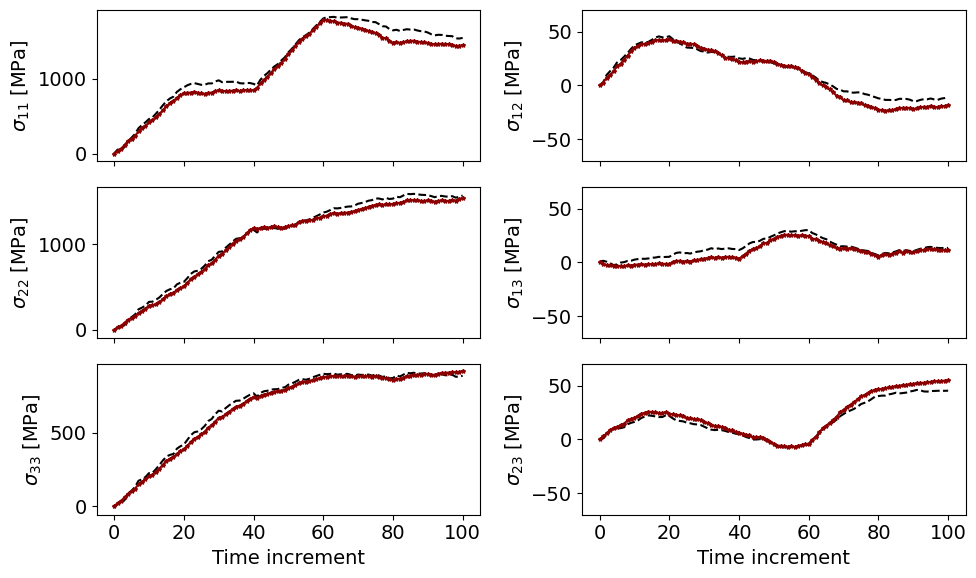

In [29]:
def plot_predictions(model, test_loader_f, y_scaler_f, test_sample_id=None):
    # Select the sample
    if test_sample_id is None:
        test_sample_id = random.randint(0, 50)  # You may want to adjust the upper bound based on your dataset size
    # Issues with samples 70 ok with 38, 11 is good!

    print(test_sample_id)
    x_target, y_target = test_loader_f.dataset[test_sample_id]

    model.eval()  # Set the model to evaluation mode
    print(model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Make predictions
    with torch.no_grad():
        y_pred = model(x_target.to(device))

    # Move tensors to the same device
    device_to_cpu = x_target.device
    #print(device_to_cpu)-->CPU
    y_pred = y_pred.to(device_to_cpu)

    # Scale back the predictions and target using y_scaler_f
    scaled_back_y_pred = np.zeros_like(y_pred)
    #print(scaled_back_y_pred.shape)-->(101, 6)
    scaled_back_y_target = np.zeros_like(y_target)
    #print(y_pred.shape[1])-->6
    for i in range(y_pred.shape[1]):  # Assuming the first dimension is the time steps
        #print(y_pred.shape[1])-->6
        scaler = y_scaler_f[i]
        # Only perform scaling if scaler is not None or empty
        if scaler:
            #print(scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).shape)
            scaled_back_y_pred[:, i] = scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
            scaled_back_y_target[:, i] = scaler.inverse_transform(y_target[:, i].reshape(-1, 1)).flatten()
        else:
            # If the scaler is empty or None, copy the original predictions/targets without scaling
            scaled_back_y_pred[:, i] = y_pred[:, i]
            scaled_back_y_target[:, i] = y_target[:, i]

    # Plot each component of stress in subfigures
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

    # Add LaTeX notation for stress components
    stress_labels = [r'$\sigma_{11}$', r'$\sigma_{22}$', r'$\sigma_{33}$', r'$\sigma_{12}$', r'$\sigma_{13}$', r'$\sigma_{23}$']

    # Plot normal components on left subfigure
    for i in range(3):
        axs[i][0].plot(scaled_back_y_pred[:, i], linestyle='--', color='black', label='Fine-tuned model prediction' if i == 0 else None)
        axs[i][0].plot(scaled_back_y_target[:, i], linestyle='-', color='darkred', marker='*', markersize=3, label='Target' if i == 0 else None)  # Add legend only to the first subplot
        axs[i][0].set_ylabel(f'{stress_labels[i]} [MPa]')
        #axs[i][0].set_ylim(-30,30)
        #axs[i][0].legend(loc='upper left' if i == 0 else None)  # Adjust legend location for the first subplot

    # Add x-axis label to the bottom subfigure
    axs[-1][0].set_xlabel('Time increment')

    # Plot shear components on right subfigures
    for i in range(3, 6):
        axs[i - 3][1].plot(scaled_back_y_pred[:, i], linestyle='--', color='black', label='Fine-tuned model prediction' if i == 3 else None)
        axs[i - 3][1].plot(scaled_back_y_target[:, i], linestyle='-', color='darkred', marker='*', markersize=3, label='Target' if i == 3 else None)  # Add legend only to the first subplot
        axs[i - 3][1].set_ylabel(f'{stress_labels[i]} [MPa]')
        axs[0][1].set_ylim(-70,70)
        axs[i - 3][1].set_ylim(-70,70)
        #axs[i - 3][1].legend(loc='upper right' if i == 3 else None)  # Adjust legend location for the first subplot

    # Add x-axis label to the bottom subfigure
    axs[-1][1].set_xlabel('Time increment')

    # Adjust layout
    plt.tight_layout()

    # Save the plot as EPS format
    #plt.savefig('images_FFpaper/sample_fine_tuned_model_prediction_2.eps', format='eps')

    # Show the plot
    plt.show()

# Example usage:
plot_predictions(model, test_loader_f, y_scaler_f, test_sample_id=7) # sample 9 in paper


GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)
39
39
GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)


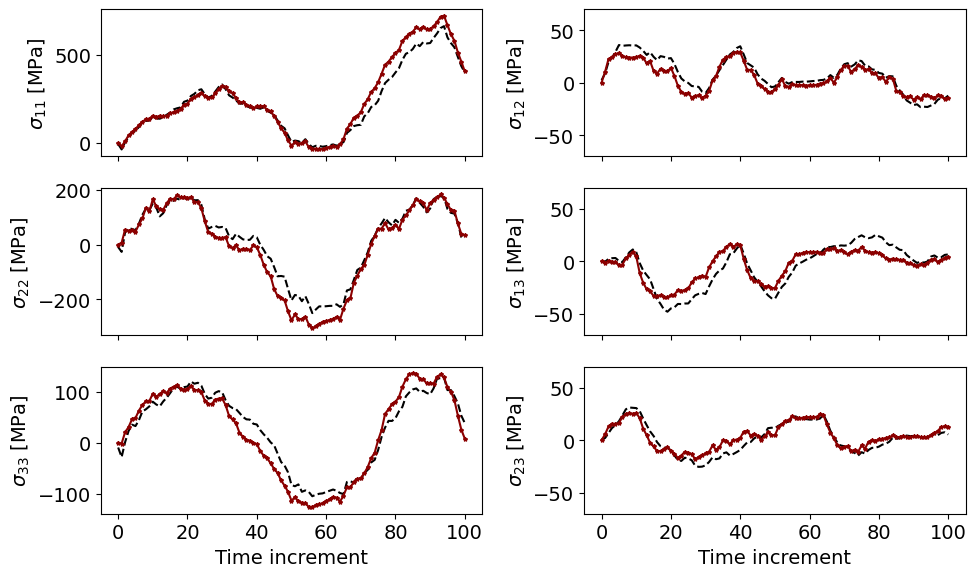

In [31]:
model_directory = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models"
                   + '\\GRU_scratch_high_fidelity_model_0.001_10_robust_original787_scaled_data_batch8_timesteps101.pth') 
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(loading_dir))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_from_scratch = model.to(device)


#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
 #              '\\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth')
#transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth'
#
# Load the pre-trained model
#model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
#model.load_state_dict(torch.load(loading_dir))
#print(model)

# Move the pretrained model to CUDA device if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_fine_tuned = model.to(device)
id=np.random.randint(1, 80)
print(id)
plot_predictions(model_from_scratch, test_loader_f, y_scaler_f, test_sample_id=id) # sample 9 in paper


In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_predictions(model, test_loader_f, y_scaler_f, test_sample_ids=None):
    # Default to random selection of 3 samples if none are provided
    if test_sample_ids is None:
        test_sample_ids = random.sample(range(len(test_loader_f.dataset)), 3)
    
    # Set model to evaluation mode
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
    stress_labels = [r'$\sigma_{11}$', r'$\sigma_{22}$', r'$\sigma_{33}$', r'$\sigma_{12}$', r'$\sigma_{13}$', r'$\sigma_{23}$']
    
    #colors = ['blue', 'green', 'purple']  # Unique colors for different samples
    colors = ['#000000','darkgreen','#800000']
    
    for idx, test_sample_id in enumerate(test_sample_ids):
        print(f'Processing sample {test_sample_id}')
        
        x_target, y_target = test_loader_f.dataset[test_sample_id]
        
        with torch.no_grad():
            y_pred = model(x_target.to(device))
        
        y_pred = y_pred.to(x_target.device)
        
        scaled_back_y_pred = np.zeros_like(y_pred)
        scaled_back_y_target = np.zeros_like(y_target)
        
        for i in range(y_pred.shape[1]):
            scaler = y_scaler_f[i]
            if scaler:
                scaled_back_y_pred[:, i] = scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
                scaled_back_y_target[:, i] = scaler.inverse_transform(y_target[:, i].reshape(-1, 1)).flatten()
            else:
                scaled_back_y_pred[:, i] = y_pred[:, i]
                scaled_back_y_target[:, i] = y_target[:, i]
        
        for i in range(3):
            axs[i][0].plot(scaled_back_y_pred[:, i], linestyle='--', color=colors[idx], label=f'GRU Prediction {test_sample_id}' if idx == 0 else None)
            axs[i][0].plot(scaled_back_y_target[:, i], linestyle='-', color=colors[idx], marker='', markersize=2, label=f'FFT {test_sample_id}' if idx == 0 else None)
            axs[i][0].set_ylabel(f'{stress_labels[i]} [MPa]')
            #axs[i][0].set_ylim(-100, 100)
        
        for i in range(3, 6):
            axs[i - 3][1].plot(scaled_back_y_pred[:, i], linestyle='--', color=colors[idx], label=f'GRU Prediction {test_sample_id}' if idx == 0 else None)
            axs[i - 3][1].plot(scaled_back_y_target[:, i], linestyle='-', color=colors[idx], marker='', markersize=2, label=f'FFT {test_sample_id}' if idx == 0 else None)
            axs[i - 3][1].set_ylabel(f'{stress_labels[i]} [MPa]')
            #axs[0][1].set_ylim(-100, 100)
            #axs[i - 3][1].set_ylim(-100, 100)
    
    axs[-1][0].set_xlabel('Time increment')
    axs[-1][1].set_xlabel('Time increment')
    
    plt.tight_layout()
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)

    #plt.savefig(f'images_FFpaper/fineTunedFromRandomMFH_ToCyclicMFH_predictions/sample_prediction_MFHcyclic_{test_sample_ids}.eps', format='eps')
    plt.show()


Processing sample 58
Processing sample 74
Processing sample 9


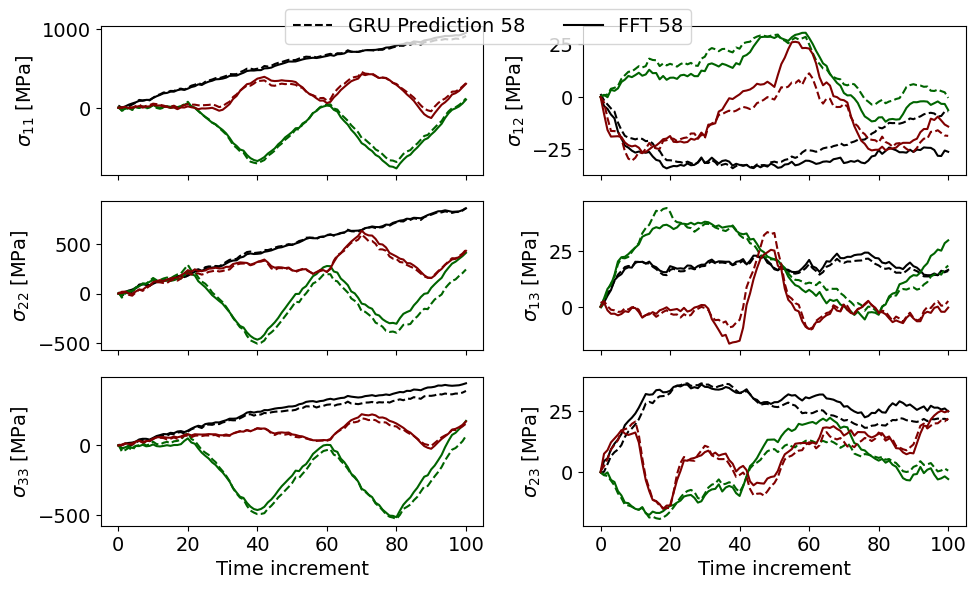

In [33]:
# Example usage:
plot_predictions(model, test_loader_f, y_scaler_f, test_sample_ids=[58, 74, 9])  # Sample IDs 7, 38, and 11 [58, 74, 9]

Sample ID: 15


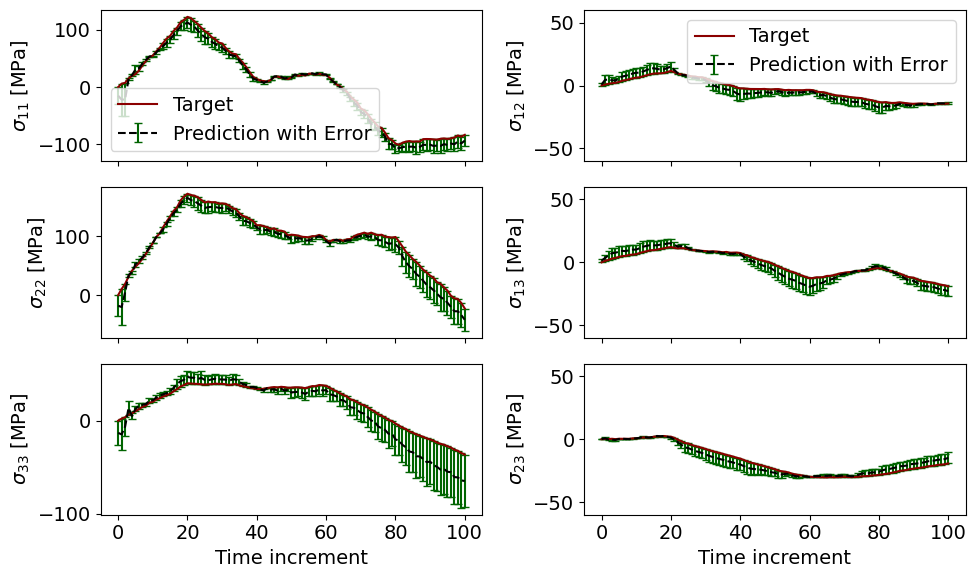

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def plot_predictions_error(model, test_loader_f, y_scaler_f, test_sample_id=None):
    # Select the sample
    if test_sample_id is None:
        test_sample_id = random.randint(0, len(test_loader_f.dataset) - 1)
    
    print("Sample ID:", test_sample_id)
    x_target, y_target = test_loader_f.dataset[test_sample_id]

    model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Make predictions
    with torch.no_grad():
        y_pred = model(x_target.to(device)).to(x_target.device)

    # Scale back the predictions and target using y_scaler_f
    scaled_back_y_pred = np.zeros_like(y_pred)
    scaled_back_y_target = np.zeros_like(y_target)
    for i in range(y_pred.shape[1]):  # Assuming the first dimension is the time steps
        scaler = y_scaler_f[i]
        if scaler:
            scaled_back_y_pred[:, i] = scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
            scaled_back_y_target[:, i] = scaler.inverse_transform(y_target[:, i].reshape(-1, 1)).flatten()

    # Calculate absolute errors
    abs_errors = np.abs(scaled_back_y_pred - scaled_back_y_target)

    # Plot each component of stress in subfigures
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
    stress_labels = [r'$\sigma_{11}$', r'$\sigma_{22}$', r'$\sigma_{33}$', r'$\sigma_{12}$', r'$\sigma_{13}$', r'$\sigma_{23}$']

    for i in range(3):
        # Normal components with error bars
        axs[i][0].errorbar(range(len(scaled_back_y_pred[:, i])), scaled_back_y_pred[:, i], yerr=abs_errors[:, i], fmt='--', color='black', ecolor='darkgreen', capsize=3, label='Prediction with Error')
        axs[i][0].plot(scaled_back_y_target[:, i], '-', color='darkred', label='Target')
        axs[i][0].set_ylabel(f'{stress_labels[i]} [MPa]')
        #axs[i][0].set_ylim(-400,400)
        if i == 0: axs[i][0].legend()

    axs[-1][0].set_xlabel('Time increment')

    for i in range(3, 6):
        # Shear components with error bars
        axs[i-3][1].errorbar(range(len(scaled_back_y_pred[:, i])), scaled_back_y_pred[:, i], yerr=abs_errors[:, i], fmt='--', color='black', ecolor='darkgreen', capsize=3, label='Prediction with Error')
        axs[i-3][1].plot(scaled_back_y_target[:, i], '-', color='darkred', label='Target')
        axs[i-3][1].set_ylabel(f'{stress_labels[i]} [MPa]')
        axs[i - 3][1].set_ylim(-60,60)
        if i == 3: axs[i-3][1].legend()

    axs[-1][1].set_xlabel('Time increment')

    plt.tight_layout()
    #plt.savefig('images_FFpaper/sample_fine_tuned_model_prediction_on_cyclicS12_loads_errors.eps', format='eps')
    plt.show()

plot_predictions_error(model,test_loader_f, y_scaler_f, test_sample_id=15)

In [37]:
from tabulate import tabulate


def calculate_stress_invariants(y):
    # Reshape y to be compatible with tensor operations
    y = y.view(y.size(0), -1, 6)  # Assuming the last dimension is always 6 for stress components
    
    # Calculate von Mises stress for each sample in the batch
    von_labels = torch.sqrt(0.5 * (
        (y[:,:,0]-y[:,:,1])**2 + 
        (y[:,:,1]-y[:,:,2])**2 + 
        (y[:,:,2]-y[:,:,0])**2 + 
        6*(y[:,:,3]**2 + y[:,:,4]**2 + y[:,:,5]**2)
    ))

    return von_labels #von_labels.shape-->[batch,time_steps]

def evaluate_vonMises_error(model, test_loader_f, y_scaler_f):
    model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"The model parameters are on {device}")

    vonMises_errors = []
    rmse_errors = []
    mbe_errors = []

    # Lists to store error values for each sample
    vonMises_errors_per_sample = []
    rmse_errors_per_sample = []
    mbe_errors_per_sample = []

    with torch.no_grad():
        for x_target, y_target in test_loader_f:
            x_target, y_target = x_target.to(device), y_target.to(device)

            # Make predictions
            y_pred = model(x_target.to(device))

            # Move tensors to the same device
            #print(f"The device is changed to CPU for numpy usage")
            y_pred = y_pred.cpu()
            y_target = y_target.cpu()

            # Scale back the predictions and target using y_scaler_f
            scaled_back_y_pred = np.zeros_like(y_pred)
            scaled_back_y_target = np.zeros_like(y_target)

            for batch_idx in range(y_pred.shape[0]):  # Loop over samples in the batch
                for i in range(y_pred.shape[2]):  # Loop over stress components
                    scaler = y_scaler_f[i]
                    # Only perform scaling if scaler is not None or empty
                    if scaler:
                        scaled_back_y_pred[batch_idx, :, i] = scaler.inverse_transform(y_pred[batch_idx, :, i].reshape(-1, 1)).flatten()
                        scaled_back_y_target[batch_idx, :, i] = scaler.inverse_transform(y_target[batch_idx, :, i].reshape(-1, 1)).flatten()
                    else:
                        # If the scaler is empty or None, copy the original predictions/targets without scaling
                        scaled_back_y_pred[batch_idx, :, i] = y_pred[batch_idx, :, i]
                        scaled_back_y_target[batch_idx, :, i] = y_target[batch_idx, :, i]

                # Calculate von Mises stress for predictions and targets
                vonMises_pred = calculate_stress_invariants(torch.tensor(scaled_back_y_pred[batch_idx]))
                vonMises_target = calculate_stress_invariants(torch.tensor(scaled_back_y_target[batch_idx]))

                # Calculate von Mises error for each sample
                vonMises_error = torch.mean(torch.abs(vonMises_pred - vonMises_target), dim=1)

                # Calculate RMSE and MBE over the time steps
                rmse_error = torch.sqrt(torch.mean((vonMises_pred - vonMises_target)**2, dim=1))
                mbe_error = torch.mean((vonMises_pred - vonMises_target), dim=1)

                # Append errors for this sample
                vonMises_errors_per_sample.append(vonMises_error.cpu().numpy())
                rmse_errors_per_sample.append(rmse_error.cpu().numpy())
                mbe_errors_per_sample.append(mbe_error.cpu().numpy())

    # Convert lists to numpy arrays
    vonMises_errors_per_sample = np.array(vonMises_errors_per_sample)
    rmse_errors_per_sample = np.array(rmse_errors_per_sample)
    mbe_errors_per_sample = np.array(mbe_errors_per_sample)

    # Calculate mean errors
    mean_vonMises_error, std_vonMises_error = np.mean(vonMises_errors_per_sample), np.std(vonMises_errors_per_sample)
    mean_rmse_error, std_rmse_error = np.mean(rmse_errors_per_sample), np.std(rmse_errors_per_sample)
    mean_mbe_error, std_mbe_error = np.mean(mbe_errors_per_sample), np.std(mbe_errors_per_sample)

    # Print mean and standard deviation of errors using tabulate
    print(tabulate([
        ["MAE", f"{mean_vonMises_error:.1f}", f"{std_vonMises_error:.1f}"],
        ["RMSE", f"{mean_rmse_error:.1f}", f"{std_rmse_error:.1f}"],
        ["MBE", f"{mean_mbe_error:.1f}", f"{std_mbe_error:.1f}"]
    ], headers=["Mean metric over time steps (w.r.t. vonMises stress))", "Mean [MPa]", "Standard Deviation [MPa]"], tablefmt="pretty"))



    return mean_vonMises_error, mean_rmse_error, mean_mbe_error, vonMises_errors_per_sample.shape

evaluate_vonMises_error(model, test_loader_f, y_scaler_f) 




The model parameters are on cuda
+-------------------------------------------------------+------------+--------------------------+
| Mean metric over time steps (w.r.t. vonMises stress)) | Mean [MPa] | Standard Deviation [MPa] |
+-------------------------------------------------------+------------+--------------------------+
|                          MAE                          |    30.3    |           37.0           |
|                         RMSE                          |    30.3    |           37.0           |
|                          MBE                          |    -3.3    |           47.7           |
+-------------------------------------------------------+------------+--------------------------+


(30.32576, 30.32576, -3.34736, (91, 101))

In [108]:
from tabulate import tabulate

def evaluate_stress_errors(model, test_loader_f, y_scaler_f):
    model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"The model parameters are on {device}")

    # Lists to store error values for each sample
    vonMises_errors_per_sample = []
    rmse_errors_per_sample = {i: [] for i in range(6)}  # Separate lists for each stress component
    mbe_errors_per_sample = {i: [] for i in range(6)}  # Separate lists for each stress component

    with torch.no_grad():
        for x_target, y_target in test_loader_f:
            x_target, y_target = x_target.to(device), y_target.to(device)

            # Make predictions
            y_pred = model(x_target)

            # Move tensors to the same device
            y_pred = y_pred.cpu()
            y_target = y_target.cpu()

            # Scale back the predictions and target using y_scaler_f
            scaled_back_y_pred = np.zeros_like(y_pred)
            scaled_back_y_target = np.zeros_like(y_target)

            for batch_idx in range(y_pred.shape[0]):  # Loop over samples in the batch
                for i in range(y_pred.shape[2]):  # Loop over stress components
                    scaler = y_scaler_f[i]
                    # Only perform scaling if scaler is not None or empty
                    if scaler:
                        scaled_back_y_pred[batch_idx, :, i] = scaler.inverse_transform(y_pred[batch_idx, :, i].reshape(-1, 1)).flatten()
                        scaled_back_y_target[batch_idx, :, i] = scaler.inverse_transform(y_target[batch_idx, :, i].reshape(-1, 1)).flatten()
                    else:
                        # If the scaler is empty or None, copy the original predictions/targets without scaling
                        scaled_back_y_pred[batch_idx, :, i] = y_pred[batch_idx, :, i]
                        scaled_back_y_target[batch_idx, :, i] = y_target[batch_idx, :, i]

                # Calculate von Mises stress for predictions and targets
                vonMises_pred = calculate_stress_invariants(torch.tensor(scaled_back_y_pred[batch_idx]))
                vonMises_target = calculate_stress_invariants(torch.tensor(scaled_back_y_target[batch_idx]))

                # Calculate von Mises error for each sample
                vonMises_error = torch.mean(torch.abs(vonMises_pred - vonMises_target), dim=1)

                # Calculate RMSE and MBE for each stress component over the time steps
                for i in range(6):  # Loop over stress components
                    rmse_error = torch.sqrt(torch.mean((torch.tensor(scaled_back_y_pred[batch_idx, :, i]) - torch.tensor(scaled_back_y_target[batch_idx, :, i]))**2))
                    mbe_error = torch.mean(torch.tensor(scaled_back_y_pred[batch_idx, :, i]) - torch.tensor(scaled_back_y_target[batch_idx, :, i]))
                    rmse_errors_per_sample[i].append(rmse_error.cpu().numpy())
                    mbe_errors_per_sample[i].append(mbe_error.cpu().numpy())

                # Append von Mises error for this sample
                vonMises_errors_per_sample.append(vonMises_error.cpu().numpy())

    # Convert lists to numpy arrays
    vonMises_errors_per_sample = np.array(vonMises_errors_per_sample)
    rmse_errors_per_sample = {i: np.array(errors) for i, errors in rmse_errors_per_sample.items()}
    mbe_errors_per_sample = {i: np.array(errors) for i, errors in mbe_errors_per_sample.items()}

    # Calculate mean errors
    mean_vonMises_error, std_vonMises_error = np.mean(vonMises_errors_per_sample), np.std(vonMises_errors_per_sample)
    mean_rmse_errors, std_rmse_errors = {}, {}
    mean_mbe_errors, std_mbe_errors = {}, {}
    for i in range(6):  # Loop over stress components
        mean_rmse_errors[i], std_rmse_errors[i] = np.mean(rmse_errors_per_sample[i]), np.std(rmse_errors_per_sample[i])
        mean_mbe_errors[i], std_mbe_errors[i] = np.mean(mbe_errors_per_sample[i]), np.std(mbe_errors_per_sample[i])

    # Print mean and standard deviation of errors using tabulate
    print(tabulate([
        ["von Mises", f"{mean_vonMises_error:.1f}", f"{std_vonMises_error:.1f}"],
        *[[f"Component {i+1}", f"{mean_rmse_errors[i]:.1f}", f"{std_rmse_errors[i]:.1f}"] for i in range(6)]
    ], headers=["Mean RMSE over time steps (w.r.t. von Mises stress)", "Mean [MPa]", "Standard Deviation [MPa]"], tablefmt="pretty"))

    return mean_vonMises_error, std_vonMises_error, mean_rmse_errors, std_rmse_errors

evaluate_stress_errors(model, test_loader_f, y_scaler_f)


The model parameters are on cuda
+-----------------------------------------------------+------------+--------------------------+
| Mean RMSE over time steps (w.r.t. von Mises stress) | Mean [MPa] | Standard Deviation [MPa] |
+-----------------------------------------------------+------------+--------------------------+
|                      von Mises                      |    37.0    |           44.7           |
|                     Component 1                     |    48.3    |           51.9           |
|                     Component 2                     |    46.5    |           46.1           |
|                     Component 3                     |    27.8    |           30.2           |
|                     Component 4                     |    5.5     |           4.2            |
|                     Component 5                     |    5.7     |           4.7            |
|                     Component 6                     |    4.9     |           3.5            |
+------

(36.951344,
 44.71419,
 {0: 48.27583,
  1: 46.490257,
  2: 27.81331,
  3: 5.5138793,
  4: 5.6697598,
  5: 4.9046154},
 {0: 51.850357,
  1: 46.090557,
  2: 30.229301,
  3: 4.2345276,
  4: 4.741344,
  5: 3.4604764})

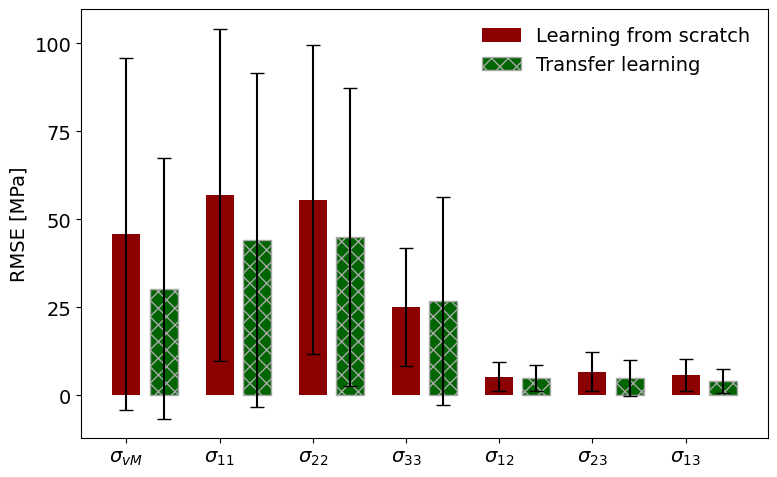

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Components
components = ["$\sigma_{vM}$", "$\sigma_{11}$", "$\sigma_{22}$", "$\sigma_{33}$", "$\sigma_{12}$", "$\sigma_{23}$", "$\sigma_{13}$"]

# Original mean and std values for RMSE errors
mean_errors = [45.7, 56.9, 55.6, 25.0, 5.3, 6.7, 5.7]
std_errors = [50.0, 47.3, 43.8, 16.8, 4.1, 5.6, 4.5]

# New mean and std values for RMSE errors
#new_mean_errors = [70.4, 80.7, 75.7, 44.0, 6.8, 7.5, 6.6]
#new_std_errors = [77.4, 63.0, 52.8, 37.3, 4.6, 5.6, 4.1]

# Third set mean and std values for RMSE errors
third_mean_errors = [30.3, 44.1, 44.9, 26.8, 4.9, 5.0, 4.0]
third_std_errors = [37.0, 47.5, 42.4, 29.5, 3.7, 5.1, 3.4]

# Create bar chart
x_pos = np.arange(len(components))
width = 0.35  # width of the bars
spacing = 0.05  # small space between bars
patterns = ['', '///', 'xx']

fig, ax = plt.subplots(figsize=(8,5))

# New bars
#bars2 = ax.bar(x_pos - width - spacing, new_mean_errors, width - spacing, yerr=new_std_errors, capsize=5, label='Learning from scratch', hatch=patterns[1], edgecolor='grey',color=['#000000', 'darkgreen', '#800000', 'darkorange', 'green', '#FF0000', 'orange'])

# Original bars
bars1 = ax.bar(x_pos , mean_errors, width - spacing, yerr=std_errors, capsize=5, label='Learning from scratch',color='darkred')#['#000000', 'darkgreen', '#800000', 'darkorange', 'green', '#FF0000', 'orange'])

# Third set of bars
bars3 = ax.bar(x_pos + width + spacing, third_mean_errors, width - spacing, yerr=third_std_errors, capsize=5, label='Transfer learning',hatch=patterns[2],edgecolor='darkgrey', color='darkgreen')#['#000000', 'darkgreen', '#800000', 'darkorange', 'green', '#FF0000', 'orange'])

# Label the x-axis
ax.set_xticks(x_pos)
ax.set_xticklabels(components)
ax.set_ylabel('RMSE [MPa]',fontsize=14)
ax.legend(frameon=False, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
num_ticks = 5  # Set the desired number of y-axis ticks
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(nbins=num_ticks))

# Show the plot
plt.savefig('stressComponentsRMSE.eps', format='eps', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()



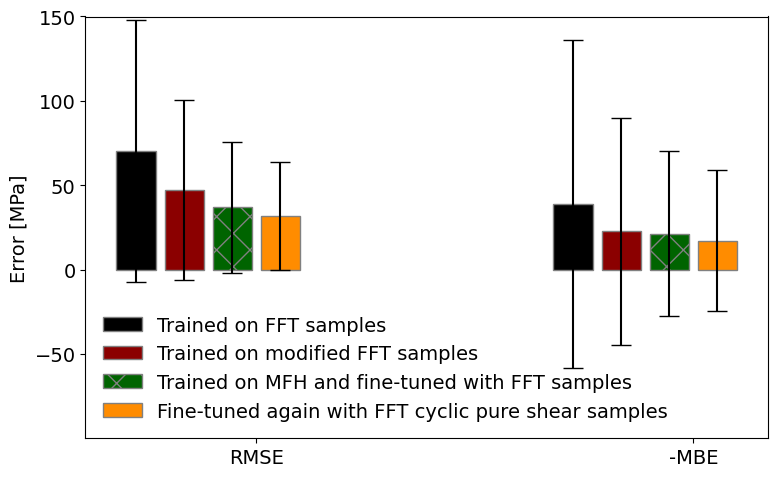

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
categories = ['RMSE', '-MBE']
full_field_network_1outlier_means = [70.3, 38.8]
full_field_network_1outlier_stds = [77.5, 97.2]

full_field_network_means = [47.2, 22.6]
full_field_network_stds = [53.2, 67.3]

fine_tuned_network_means = [36.9, 21.3]
fine_tuned_network_stds = [38.7, 49.0]

fine_tuned_s12_network_means = [31.7, 17.0]
fine_tuned_s12_network_stds = [32.2, 41.8]

barWidth = 0.09  # Adjusted bar width
space = 0.02    # Reduced space between bars

# Set the position of bar on X axis
r1 = np.arange(len(categories))
r2 = [x + barWidth + space for x in r1]
r3 = [x + 2 * (barWidth + space) for x in r1]
r4 = [x + 3 * (barWidth + space) for x in r1]

# Create the bar plot
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(r1, full_field_network_1outlier_means, color='black', width=barWidth, edgecolor='grey', yerr=full_field_network_1outlier_stds, capsize=7, label='Trained on FFT samples')
ax.bar(r2, full_field_network_means, color='darkred', width=barWidth, edgecolor='grey', yerr=full_field_network_stds, capsize=7, label='Trained on modified FFT samples')
ax.bar(r3, fine_tuned_network_means, color='darkgreen', hatch='x', width=barWidth, edgecolor='grey', yerr=fine_tuned_network_stds, capsize=7, label='Trained on MFH and fine-tuned with FFT samples')
ax.bar(r4, fine_tuned_s12_network_means, color='darkorange', width=barWidth, edgecolor='grey', yerr=fine_tuned_s12_network_stds, capsize=7, label='Fine-tuned again with FFT cyclic pure shear samples')

# Add xticks on the middle of the group bars
plt.xticks([r + 2.5 * (barWidth + space) for r in range(len(categories))], categories)
plt.ylabel('Error [MPa]',fontsize=14)
plt.ylim(-100, 150)  # Adjust the upper limit as needed

# Set specific yticks
plt.yticks([-50, 0, 50, 100, 150])

# Create the legend & Show the plot
ax.legend(loc='lower left',frameon=False,fontsize=14)
plt.tight_layout()
plt.savefig('performance_comparison_FFandFFOutlier_desperate.eps', bbox_inches='tight', dpi=300)
plt.show()


In [38]:
(31.7-36.9)/36.9

-0.14092140921409213

WORKING on different training dat set sizes

Training model with 5 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.6780, Validation Loss: 4.3626, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.6613, Validation Loss: 4.3535, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.6449, Validation Loss: 4.3444, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.6270, Validation Loss: 4.3354, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.6111, Validation Loss: 4.3264, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.5932, Validation Loss: 4.3181, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.5775, Validation Loss: 4.3098, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.5620, Validation Loss: 4.3012, Learning Rate: 9e-05

Epoch [9/2000], Training Loss: 0.5445, Validation Loss: 4.2925, Learning Rate: 9e-05

Epoch [10/2000], Training Loss: 0.5260, Validat

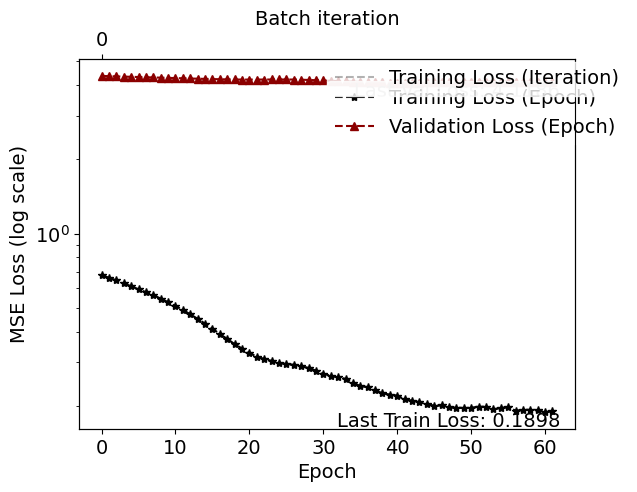

Test Loss: 1.2129
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_5_scaled_data_batch8_timesteps101.pth
Training model with 10 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.5771, Validation Loss: 4.3643, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.5027, Validation Loss: 4.3565, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.5471, Validation Loss: 4.3491, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.6168, Validation Loss: 4.3412, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 2.5154, Validation Loss: 4.3326, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 2.6571, Validation Loss: 4.3262, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 1.3435, Validation Loss: 4.3223, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 3.3043, Validation Loss: 4.3202, Learning Rate: 9e

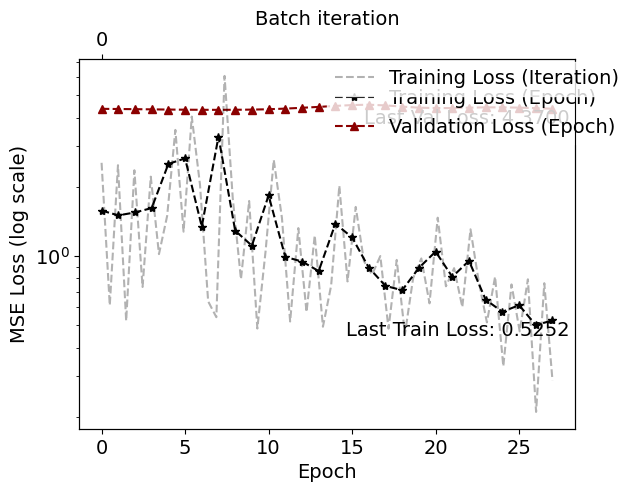

Test Loss: 1.2613
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_10_scaled_data_batch8_timesteps101.pth
Training model with 20 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 2.0228, Validation Loss: 4.3430, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.6019, Validation Loss: 4.3187, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.7752, Validation Loss: 4.2895, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.5948, Validation Loss: 4.2539, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.3413, Validation Loss: 4.2125, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.2303, Validation Loss: 4.1668, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 1.1506, Validation Loss: 4.1217, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.9764, Validation Loss: 4.1007, Learning Rate: 9

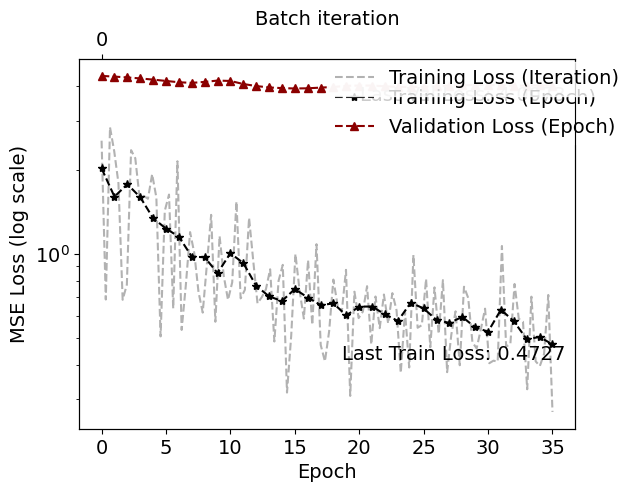

Test Loss: 0.9227
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_20_scaled_data_batch8_timesteps101.pth
Training model with 50 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 2.8508, Validation Loss: 4.3019, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 2.9083, Validation Loss: 4.2135, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 2.4889, Validation Loss: 4.0886, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 2.0296, Validation Loss: 4.0546, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.9314, Validation Loss: 4.1174, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.9122, Validation Loss: 3.9528, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 3.7074, Validation Loss: 3.8937, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 1.7032, Validation Loss: 4.0814, Learning Rate: 9

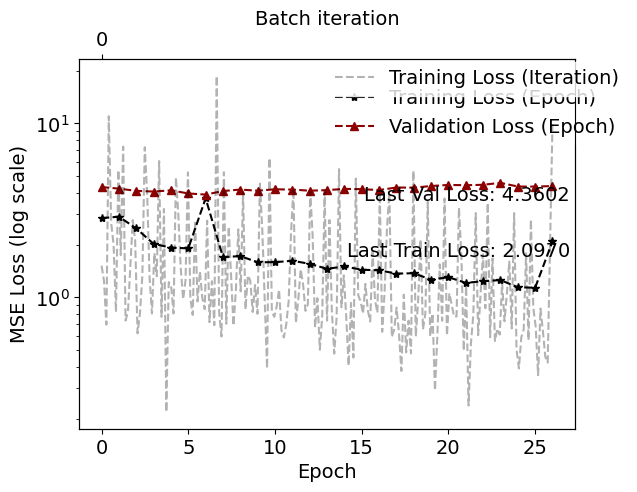

Test Loss: 1.0530
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_50_scaled_data_batch8_timesteps101.pth
Training model with 100 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 2.5045, Validation Loss: 4.1981, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 2.2274, Validation Loss: 3.8273, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.8407, Validation Loss: 3.6103, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 2.0874, Validation Loss: 3.5374, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.6338, Validation Loss: 3.6209, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.5847, Validation Loss: 3.5838, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 1.5484, Validation Loss: 3.5595, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 1.5459, Validation Loss: 3.5558, Learning Rate: 

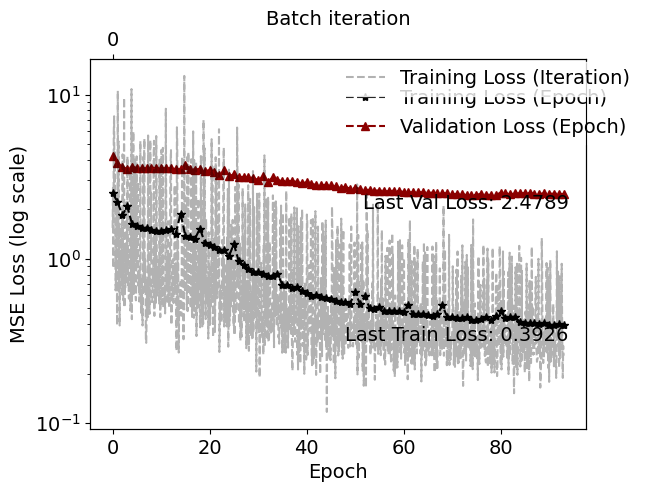

Test Loss: 0.5339
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_100_scaled_data_batch8_timesteps101.pth
Training model with 200 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 2.3120, Validation Loss: 3.8671, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.6511, Validation Loss: 3.4715, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.5797, Validation Loss: 3.5665, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.6028, Validation Loss: 3.4107, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.5081, Validation Loss: 3.4376, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.4847, Validation Loss: 3.4379, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 1.4694, Validation Loss: 3.4101, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 1.4642, Validation Loss: 3.4471, Learning Rate:

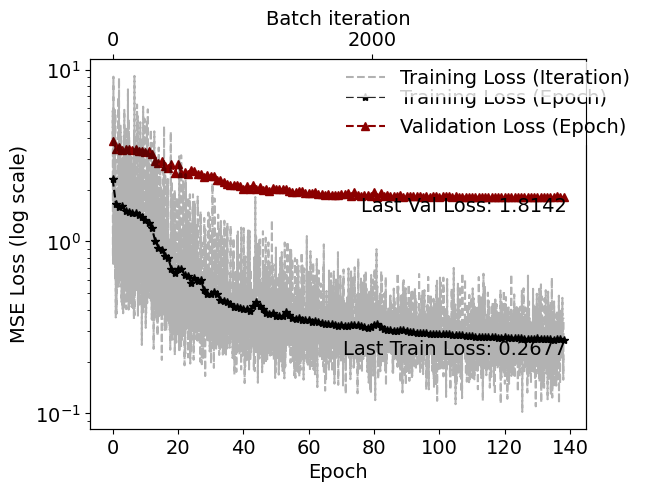

Test Loss: 0.3551
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_200_scaled_data_batch8_timesteps101.pth
Training model with 300 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 2.4448, Validation Loss: 3.4755, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.9422, Validation Loss: 3.3949, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.8254, Validation Loss: 3.3334, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.8299, Validation Loss: 3.3379, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.7524, Validation Loss: 3.3795, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.7100, Validation Loss: 3.3103, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 1.5977, Validation Loss: 3.1540, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 1.6057, Validation Loss: 3.0427, Learning Rate:

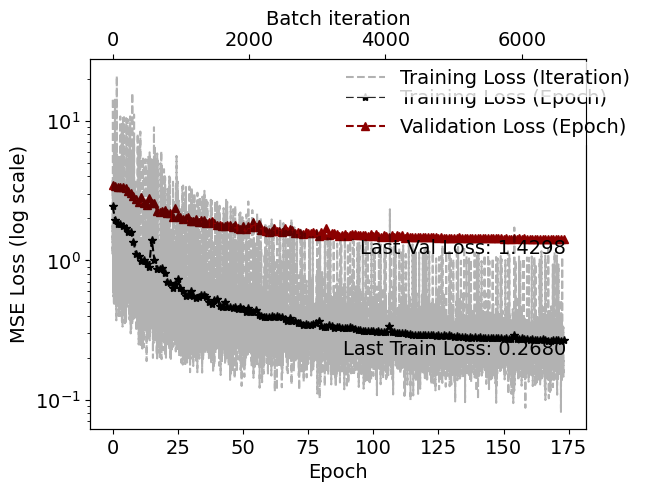

Test Loss: 0.3171
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_300_scaled_data_batch8_timesteps101.pth
Training model with 400 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 2.1681, Validation Loss: 3.4053, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.7724, Validation Loss: 3.4562, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.6800, Validation Loss: 3.2917, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.6201, Validation Loss: 3.2811, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.5783, Validation Loss: 3.1625, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.4897, Validation Loss: 3.0963, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 1.3005, Validation Loss: 2.9077, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 1.1867, Validation Loss: 3.0800, Learning Rate:

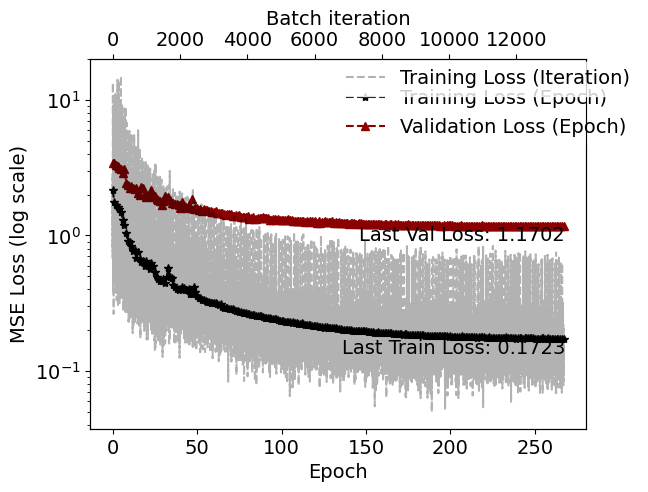

Test Loss: 0.2294
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_400_scaled_data_batch8_timesteps101.pth
Training model with 500 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.9346, Validation Loss: 3.4298, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.5817, Validation Loss: 3.4062, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.5161, Validation Loss: 3.3095, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.5395, Validation Loss: 3.2310, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.4704, Validation Loss: 3.1215, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.3778, Validation Loss: 2.9325, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 1.0874, Validation Loss: 2.6672, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 1.0033, Validation Loss: 2.4810, Learning Rate:

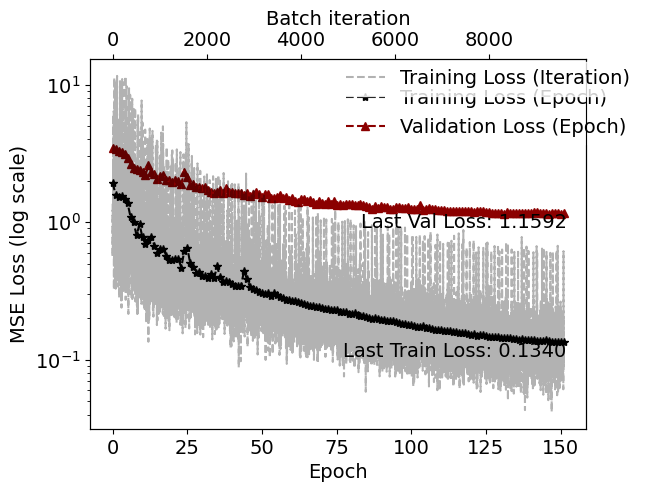

Test Loss: 0.1747
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_500_scaled_data_batch8_timesteps101.pth
Training model with 600 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 2.0325, Validation Loss: 3.4755, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.5773, Validation Loss: 3.2957, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.4958, Validation Loss: 3.3388, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.4269, Validation Loss: 3.1470, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.3142, Validation Loss: 2.8810, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 1.1043, Validation Loss: 2.8697, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.9597, Validation Loss: 2.4177, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.8168, Validation Loss: 2.3002, Learning Rate:

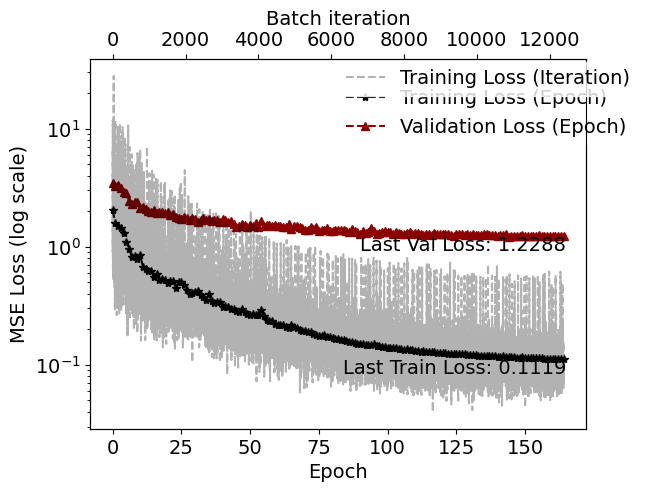

Test Loss: 0.1392
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_600_scaled_data_batch8_timesteps101.pth
Training model with 700 training samples without pretraining...
Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.9016, Validation Loss: 3.3512, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.6484, Validation Loss: 3.3232, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 1.5811, Validation Loss: 3.2940, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 1.4947, Validation Loss: 3.2702, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 1.1798, Validation Loss: 2.6074, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.9375, Validation Loss: 2.3815, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.9371, Validation Loss: 2.3495, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.8968, Validation Loss: 2.5008, Learning Rate:

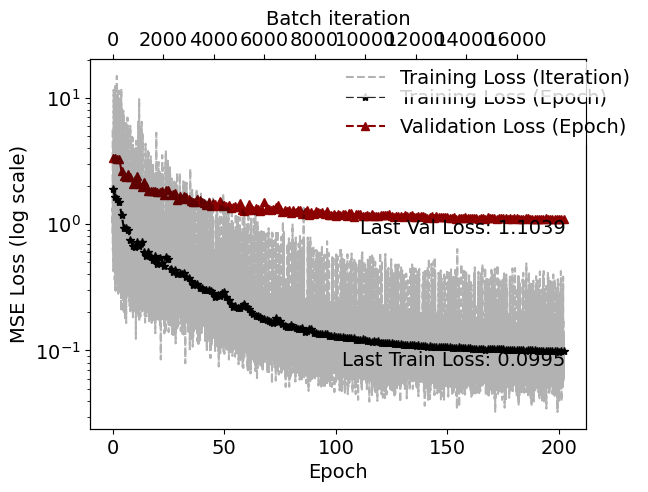

Test Loss: 0.1128
Model trained and saved: D:\from_scratch_random_model_lr0.0001_p20__dp0.5_robust_700_scaled_data_batch8_timesteps101.pth


In [24]:
# without pretraining
# Example function to create a subset loader
def create_subset_loader(full_loader, subset_size):
    """
    Create a subset of the data loader with the specified number of samples.
    """
    dataset = full_loader.dataset
    subset_indices = list(range(min(subset_size, len(dataset))))  # Ensure subset_size doesn't exceed dataset size
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    subset_loader = torch.utils.data.DataLoader(dataset, sampler=subset_sampler, batch_size=full_loader.batch_size)
    return subset_loader

import os

# Define training sample sizes to iterate over
training_sample_sizes = [5,10,20,50,100,200,300,400,500,600,700] # Example sizes, including the total

# Base saving path
saving_path = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\trainingSizeStudy"

# Base hyperparameters (exclude pretrained_model_path)
base_hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.0001,
    'patience': 20,
    'seed': 42,
    'save_directory': saving_path
}

# Loop over different training sample sizes
for size in training_sample_sizes:
    # Define the model name based on the training size
    model_name = f'\\from_scratch_random_model_lr{base_hyperparameters["learning_rate"]}_p{base_hyperparameters["patience"]}__dp0.5_robust_{size}_scaled_data_batch8_timesteps101.pth'
    
    # Update hyperparameters for this iteration
    hyperparameters = base_hyperparameters.copy()
    hyperparameters['model_name'] = model_name
    
    print(f"Training model with {size} training samples without pretraining...")

    # Initialize a subset of the training loader
    subset_train_loader = create_subset_loader(train_loader_f, size)  # Implement this function based on your data loading logic
    
    # Initialize ModelTrainer object
    trainer = ModelTrainerDataDriven(
        train_loader=subset_train_loader,
        val_loader=val_loader_f,  # Assuming validation set remains the same
        test_loader=test_loader_f,  # Assuming test set remains the same
        hyperparameters=hyperparameters
    )
    
    # Perform training without loading a pre-trained model
    trainer.initialize_model()  # Ensure this function initializes weights randomly
    trainer.define_loss_optimizer_scheduler()
    trainer.train()
    
    # Plot loss function
    trainer.plot_loss_function()
    
    # Evaluate on test set
    trainer.evaluate_test_set()
    
    print(f"Model trained and saved: {os.path.join(saving_path, model_name)}")



Training model with 5 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.2681, Validation Loss: 1.8030, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.2256, Validation Loss: 1.6553, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.1708, Validation Loss: 1.5025, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.1350, Validation Loss: 1.3943, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.1317, Validation Loss: 1.3146, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.1170, Validation Loss: 1.2590, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.1061, Validation Loss: 1.2205, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.0975, Validation Loss: 1.1918, Learning Rate: 9e-05

Epoch [9/2000], Training Loss: 0.0960, Validation Loss: 1.1617, Learning Rate: 9e-05

Epoch [10/2000], Training Loss: 0.0929, Validation Loss: 1.1253, Learning Rate: 8.1e-05

Ep

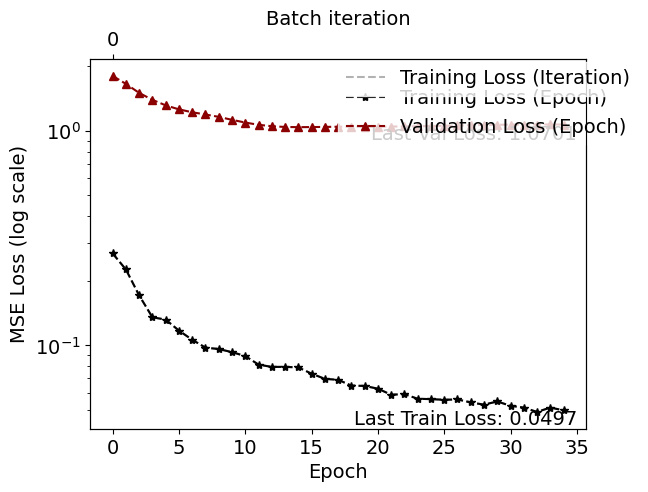

Test Loss: 2.2232
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_5_scaled_data_batch8_timesteps101.pth
Training model with 10 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.2800, Validation Loss: 1.6201, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.3882, Validation Loss: 1.4373, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.2980, Validation Loss: 1.2571, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.2613, Validation Loss: 1.1395, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.5130, Validation Loss: 1.0740, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2159, Validation Loss: 1.0232, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.1691, Validation Loss: 0.9920, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.1795, Validation Loss: 0.9624, Learning Rate: 9e-05

Epoch [9/2000], Training Loss: 0.

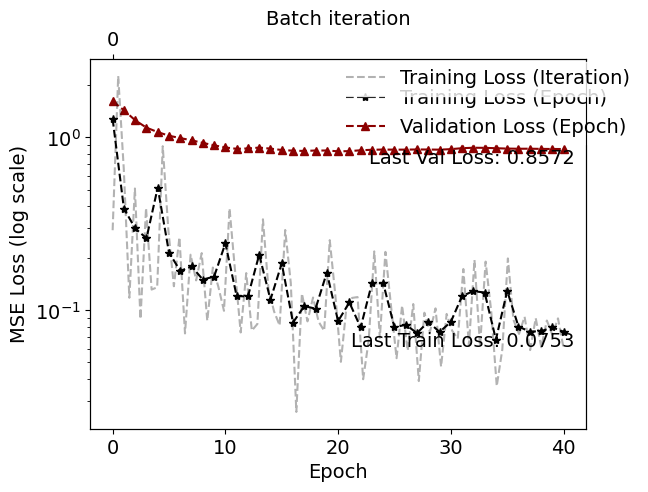

Test Loss: 1.7786
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_10_scaled_data_batch8_timesteps101.pth
Training model with 20 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.4029, Validation Loss: 1.4420, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.9583, Validation Loss: 1.1937, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.5810, Validation Loss: 1.0258, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.4398, Validation Loss: 0.9095, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.3841, Validation Loss: 0.8063, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.3024, Validation Loss: 0.7395, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.2660, Validation Loss: 0.6916, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.2510, Validation Loss: 0.6620, Learning Rate: 9e-05

Epoch [9/2000], Training Loss: 0

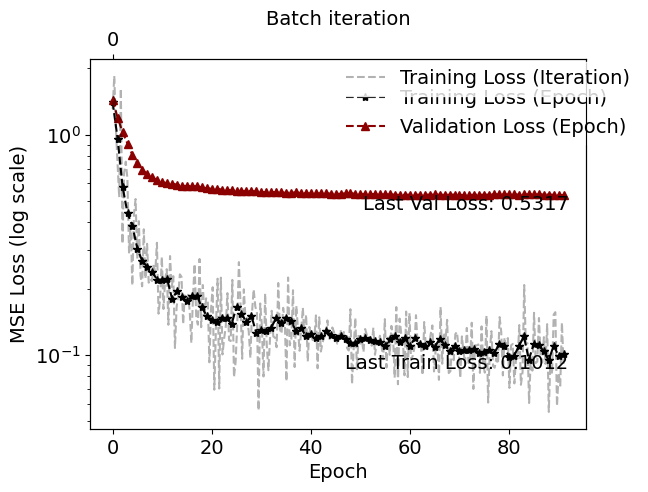

Test Loss: 0.9877
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_20_scaled_data_batch8_timesteps101.pth
Training model with 50 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.3475, Validation Loss: 1.2244, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 1.0646, Validation Loss: 0.8539, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.5287, Validation Loss: 0.7475, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.3639, Validation Loss: 0.6346, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.3476, Validation Loss: 0.6114, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.3013, Validation Loss: 0.5891, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.2838, Validation Loss: 0.5687, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.2421, Validation Loss: 0.5691, Learning Rate: 9e-05

Epoch [9/2000], Training Loss: 0

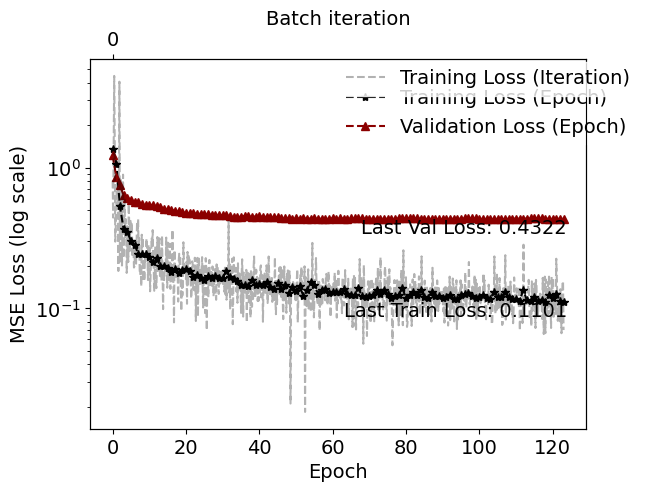

Test Loss: 0.9586
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_50_scaled_data_batch8_timesteps101.pth
Training model with 100 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.1410, Validation Loss: 0.7269, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.5432, Validation Loss: 0.5220, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.3851, Validation Loss: 0.4471, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.3173, Validation Loss: 0.4168, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.2822, Validation Loss: 0.3976, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2556, Validation Loss: 0.3744, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.2235, Validation Loss: 0.3545, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.2157, Validation Loss: 0.3498, Learning Rate: 9e-05

Epoch [9/2000], Training Loss: 

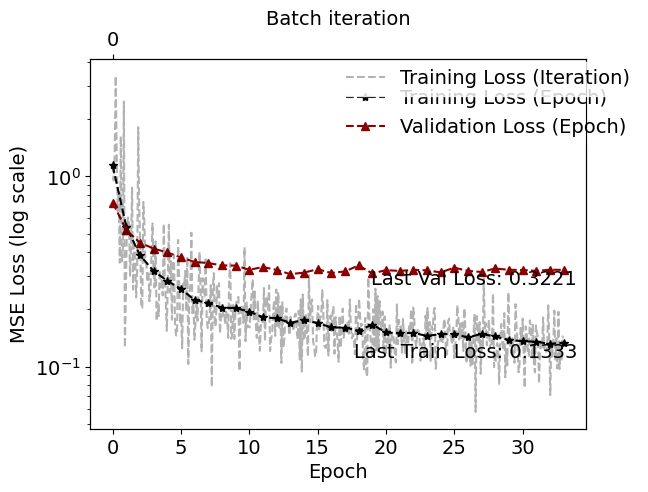

Test Loss: 0.4855
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_100_scaled_data_batch8_timesteps101.pth
Training model with 200 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.9232, Validation Loss: 0.5442, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.3852, Validation Loss: 0.4193, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.3118, Validation Loss: 0.3879, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.2772, Validation Loss: 0.4151, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.2446, Validation Loss: 0.3809, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2221, Validation Loss: 0.3929, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.2162, Validation Loss: 0.3535, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.2088, Validation Loss: 0.4726, Learning Rate: 9e-05

Epoch [9/2000], Training Loss:

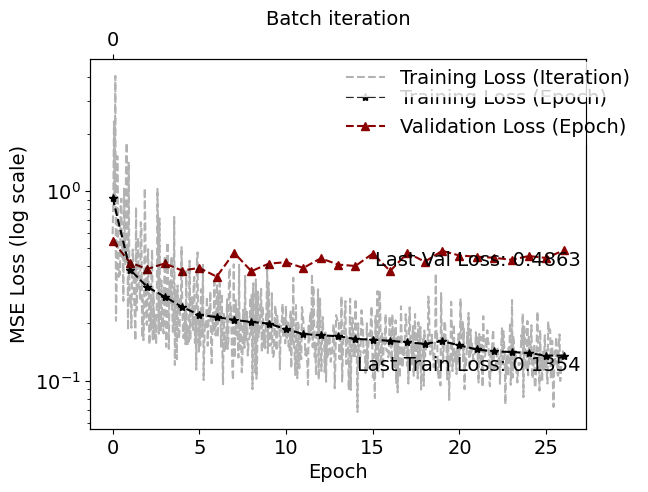

Test Loss: 0.2268
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_200_scaled_data_batch8_timesteps101.pth
Training model with 300 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.9636, Validation Loss: 0.5060, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.4278, Validation Loss: 0.5124, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.3186, Validation Loss: 0.4528, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.2605, Validation Loss: 0.5639, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.2363, Validation Loss: 0.4157, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2143, Validation Loss: 0.4811, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.1960, Validation Loss: 0.4663, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.1940, Validation Loss: 0.5365, Learning Rate: 9e-05

Epoch [9/2000], Training Loss:

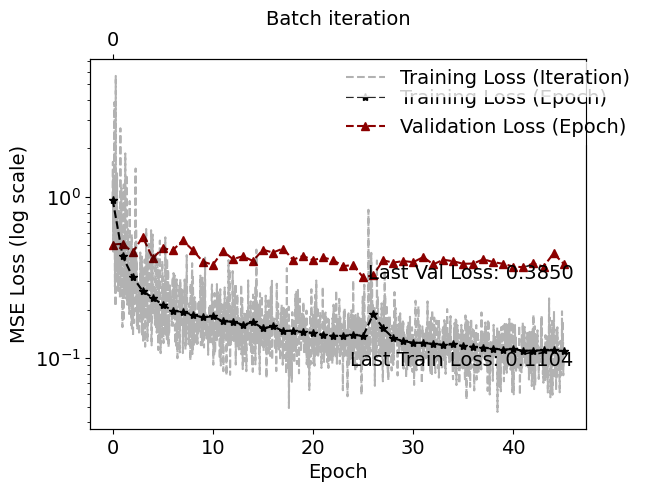

Test Loss: 0.1645
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_300_scaled_data_batch8_timesteps101.pth
Training model with 400 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 1.0318, Validation Loss: 0.5609, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.4050, Validation Loss: 0.5361, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.3257, Validation Loss: 0.5776, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.2769, Validation Loss: 0.5468, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.2501, Validation Loss: 0.5391, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2237, Validation Loss: 0.5588, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.2042, Validation Loss: 0.6534, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.2063, Validation Loss: 0.5947, Learning Rate: 9e-05

Epoch [9/2000], Training Loss:

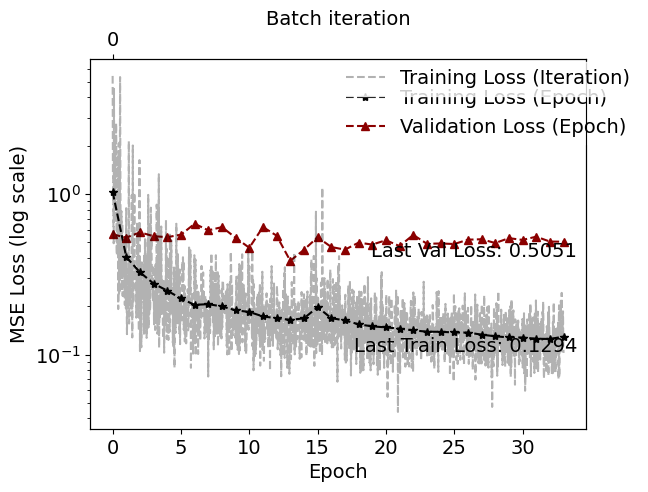

Test Loss: 0.1396
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_400_scaled_data_batch8_timesteps101.pth
Training model with 500 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.8684, Validation Loss: 0.5638, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.3755, Validation Loss: 0.7471, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.2932, Validation Loss: 0.8292, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.2715, Validation Loss: 0.9162, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.2478, Validation Loss: 0.7583, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2163, Validation Loss: 0.5994, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.2004, Validation Loss: 0.7091, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.1879, Validation Loss: 0.6005, Learning Rate: 9e-05

Epoch [9/2000], Training Loss:

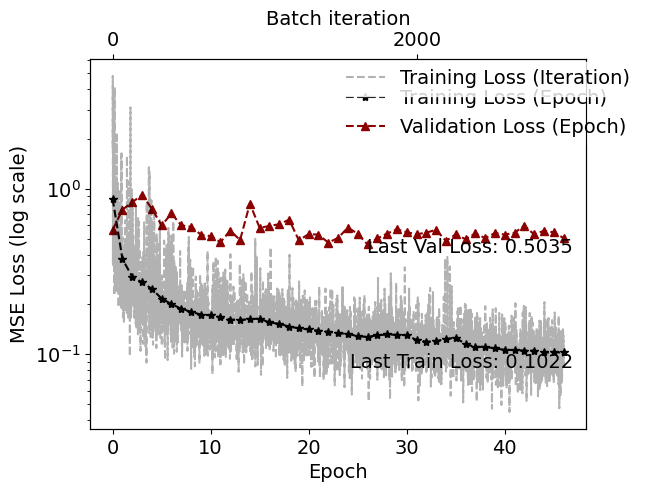

Test Loss: 0.1178
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_500_scaled_data_batch8_timesteps101.pth
Training model with 600 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.9739, Validation Loss: 0.6837, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.3751, Validation Loss: 0.7279, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.2850, Validation Loss: 0.7434, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.2432, Validation Loss: 0.7972, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.2230, Validation Loss: 0.7592, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2080, Validation Loss: 0.6869, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.1953, Validation Loss: 0.5394, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.1897, Validation Loss: 0.5918, Learning Rate: 9e-05

Epoch [9/2000], Training Loss:

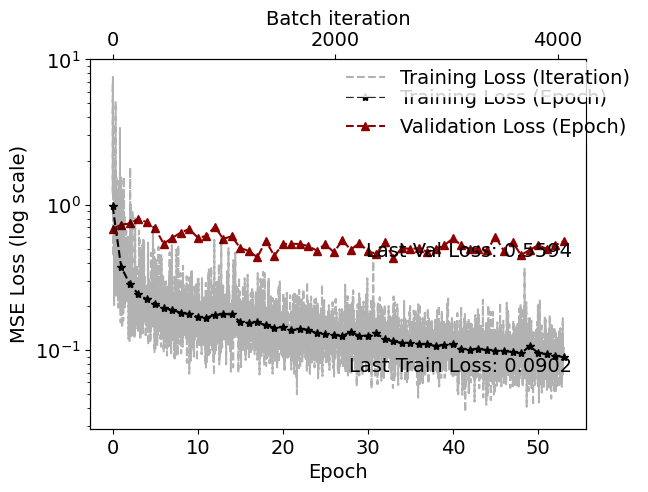

Test Loss: 0.0970
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_600_scaled_data_batch8_timesteps101.pth
Training model with 700 training samples...
Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.8070, Validation Loss: 0.5836, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.3660, Validation Loss: 0.6096, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.2698, Validation Loss: 0.6450, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.2422, Validation Loss: 0.6726, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.2224, Validation Loss: 0.5436, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.2045, Validation Loss: 0.5437, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.2006, Validation Loss: 0.4775, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.2277, Validation Loss: 0.6154, Learning Rate: 9e-05

Epoch [9/2000], Training Loss:

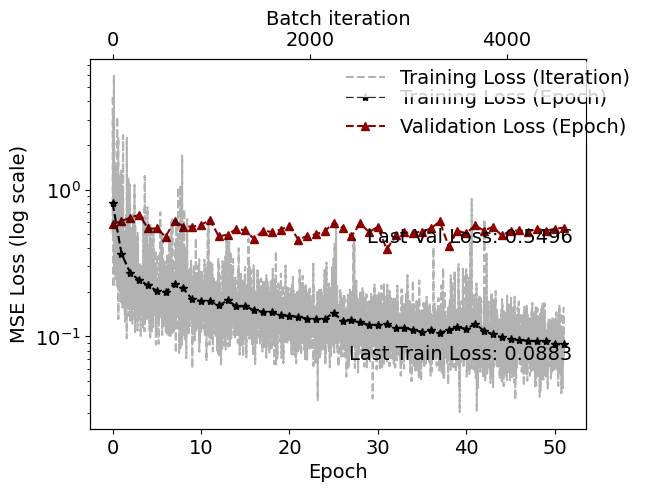

Test Loss: 0.0903
Model trained and saved: D:\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_700_scaled_data_batch8_timesteps101.pth


In [ ]:
import os
# with transfer learning

# Example function to create a subset loader
def create_subset_loader(full_loader, subset_size):
    """
    Create a subset of the data loader with the specified number of samples.
    """
    dataset = full_loader.dataset
    subset_indices = list(range(min(subset_size, len(dataset))))  # Ensure subset_size doesn't exceed dataset size
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    subset_loader = torch.utils.data.DataLoader(dataset, sampler=subset_sampler, batch_size=full_loader.batch_size)
    return subset_loader

# Define training sample sizes to iterate over
training_sample_sizes = [5,10,20,50,100,200,300,400,500,600,700]  # Example sizes, including the total

# Base saving path and pretrained model path
saving_path = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\trainingSizeStudy"
loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_low_fidelity_mdoels"
                            +'\\scratch_low_fidelity_model_lr0.001_p10_L2reg_15features_26903samples_batch128_timesteps2001.pth')

# Base hyperparameters
base_hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.0001,
    'patience': 20,
    'seed': 42,
    'save_directory': saving_path,
    'pretrained_model_path': loading_pretrained_model
}

# Loop over different training sample sizes
for size in training_sample_sizes:
    # Define the model name based on the training size
    model_name = f'\\transfer_lowTohigh_random_model_lr{base_hyperparameters["learning_rate"]}_p{base_hyperparameters["patience"]}__dp0.5_robust_{size}_scaled_data_batch8_timesteps101.pth'
    
    # Update hyperparameters for this iteration
    hyperparameters = base_hyperparameters.copy()
    hyperparameters['model_name'] = model_name
    
    print(f"Training model with {size} training samples...")

    # Initialize a subset of the training loader
    # Assuming `train_loader_f` is your original full training data loader
    subset_train_loader = create_subset_loader(train_loader_f, size)  # Implement this function based on your data loading logic
    
    # Initialize ModelTrainer object
    trainer = ModelTrainerDataDriven(
        train_loader=subset_train_loader,
        val_loader=val_loader_f,  # Assuming validation set remains the same
        test_loader=test_loader_f,  # Assuming test set remains the same
        hyperparameters=hyperparameters
    )
    
    # Perform training
    trainer.initialize_model()
    trainer.define_loss_optimizer_scheduler()
    trainer.train()
    
    # Plot loss function
    trainer.plot_loss_function()
    
    # Evaluate on test set
    trainer.evaluate_test_set()
    
    print(f"Model trained and saved: {os.path.join(saving_path, model_name)}")




In [114]:
import os
import re
import torch
import matplotlib.pyplot as plt

# Directory containing the models
loading_dir = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\trainingSizeStudy"

# Initialize error lists
scratch_errors = []
tran_errors = []

# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate through all .pth files in the directory
for file_name in os.listdir(loading_dir):
    if file_name.endswith(".pth"):
        # Determine the model type based on the file name
        if file_name.startswith("from_scratch"):
            model_type = "scratch"
        elif file_name.startswith("transfer_lowTohigh"):
            model_type = "transfer"
        else:
            continue  # Skip files not matching the expected patterns
        
        # Extract the training size from the filename
        match = re.search(r"_robust_(\d+)_scaled", file_name)
        if not match:
            continue  # Skip if the training size is not found
        training_size = int(match.group(1))
        
        # Full path to the model file
        file_path = os.path.join(loading_dir, file_name)
        
        # Initialize and load the model
        model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
        model.load_state_dict(torch.load(file_path))
        model = model.to(device)
        
        # Compute stress errors
        mean_vonMises_error, std_vonMises_error, mean_rmse_errors, std_rmse_errors = evaluate_stress_errors(
            model, test_loader_f, y_scaler_f
        )
        
        # Prepend vonMises errors to RMSE errors
        mean_rmse_errors = [mean_vonMises_error] + list(mean_rmse_errors.values())
        std_rmse_errors = [std_vonMises_error] + list(std_rmse_errors.values())
        
        # Append errors to the appropriate list
        if model_type == "scratch":
            scratch_errors.append({
                "file": file_name,
                "training_size": training_size,
                "rmse_errors": mean_rmse_errors,
                "std_rmse_errors": std_rmse_errors,
            })
        elif model_type == "transfer":
            tran_errors.append({
                "file": file_name,
                "training_size": training_size,
                "rmse_errors": mean_rmse_errors,
                "std_rmse_errors": std_rmse_errors,
            })

The model parameters are on cuda
+-----------------------------------------------------+------------+--------------------------+
| Mean RMSE over time steps (w.r.t. von Mises stress) | Mean [MPa] | Standard Deviation [MPa] |
+-----------------------------------------------------+------------+--------------------------+
|                      von Mises                      |   100.6    |          191.7           |
|                     Component 1                     |   131.6    |          177.7           |
|                     Component 2                     |   129.6    |          161.5           |
|                     Component 3                     |   105.0    |          218.6           |
|                     Component 4                     |    13.1    |           12.9           |
|                     Component 5                     |    10.5    |           11.7           |
|                     Component 6                     |    17.7    |           36.9           |
+------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[{'file': 'from_scratch_random_model_lr0.0001_p20__dp0.5_robust_5_scaled_data_batch8_timesteps101.pth', 'training_size': 5, 'rmse_errors': [151.61647, 230.36847, 262.98325, 106.12289, 22.295689, 14.179239, 13.197719], 'std_rmse_errors': [171.41005, 233.13101, 192.01723, 129.59148, 12.4796, 9.331648, 7.4996886]}, {'file': 'from_scratch_random_model_lr0.0001_p20__dp0.5_robust_10_scaled_data_batch8_timesteps101.pth', 'training_size': 10, 'rmse_errors': [188.5177, 286.36166, 300.18585, 177.57585, 13.762157, 12.254656, 11.135583], 'std_rmse_errors': [197.49799, 234.90887, 198.1383, 123.2621, 7.5938544, 9.001807, 8.192407]}, {'file': 'from_scratch_random_model_lr0.0001_p20__dp0.5_robust_20_scaled_data_batch8_timesteps101.pth', 'training_size': 20, 'rmse_errors': [145.92421, 222.97592, 244.82391, 137.80423, 11.902854, 11.742555, 10.293931], 'std_rmse_errors': [160.03, 178.9362, 178.43272, 109.21957, 7.503225, 8.911689, 7.436364]}, {'file': 'from_scratch_random_model_lr0.0001_p20__dp0.5_robust

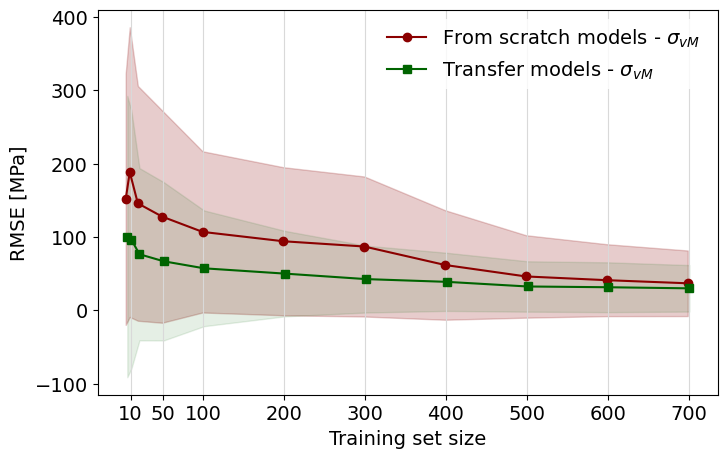

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


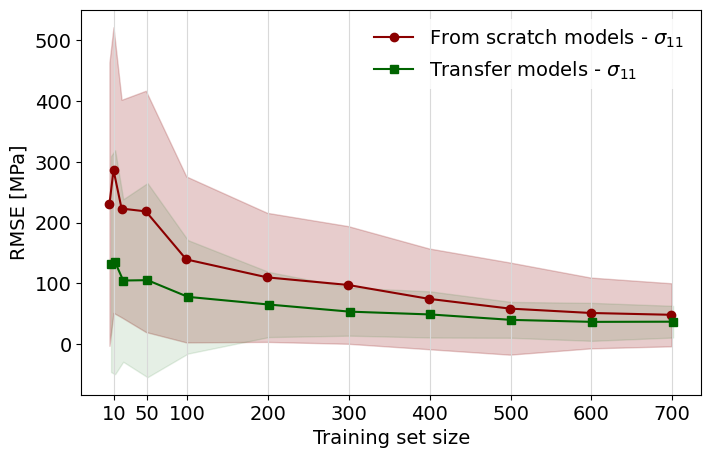

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


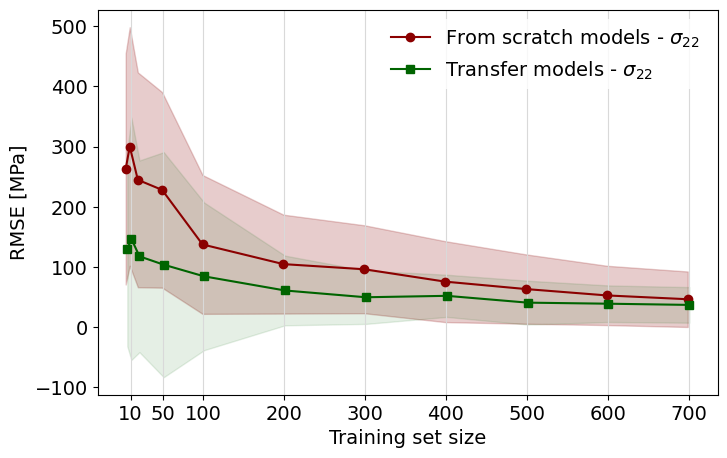

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


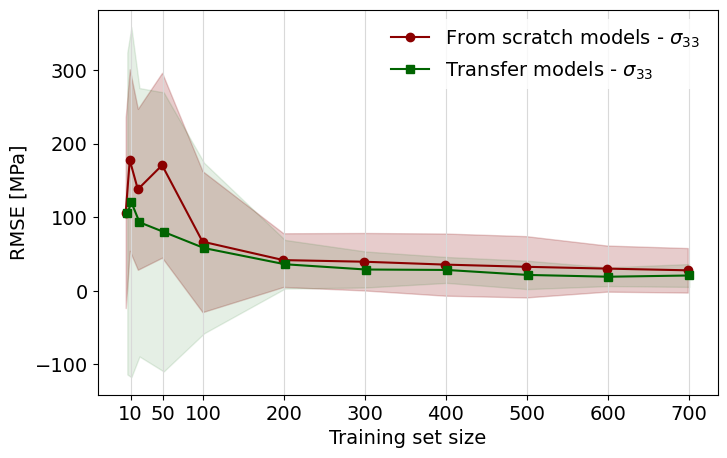

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


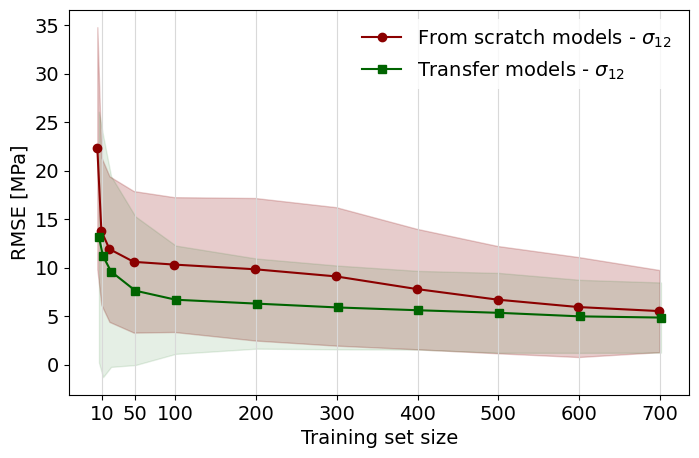

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


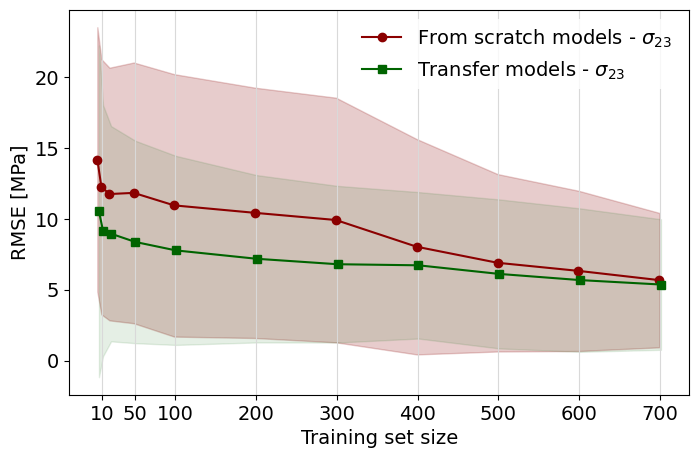

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


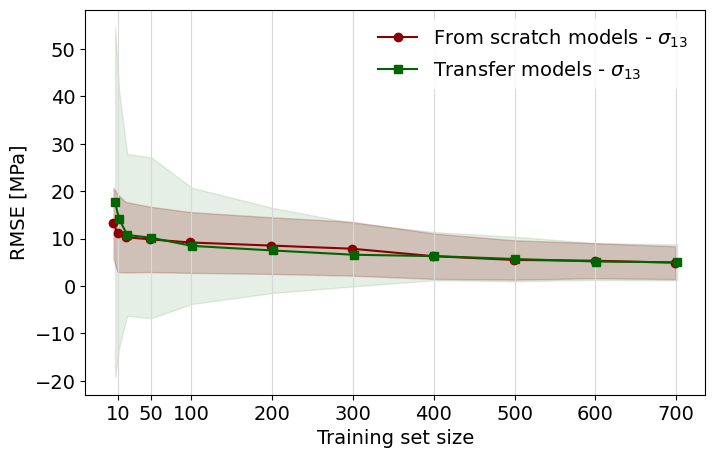

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for plotting
scratch_errors_sorted = sorted(scratch_errors, key=lambda x: x["training_size"])
tran_errors_sorted = sorted(tran_errors, key=lambda x: x["training_size"])
print(scratch_errors_sorted)

scratch_training_sizes = [entry["training_size"] for entry in scratch_errors_sorted]
tran_training_sizes = [entry["training_size"] for entry in tran_errors_sorted]

# Components to plot with their corresponding labels #, 
components = ["$\sigma_{vM}$","$\sigma_{11}$", "$\sigma_{22}$", "$\sigma_{33}$", "$\sigma_{12}$", "$\sigma_{23}$", "$\sigma_{13}$"]

for idx, component_label in enumerate(components):  # Use enumerate for index and label
    scratch_rmse_errors = [entry["rmse_errors"][idx] for entry in scratch_errors_sorted]
    tran_rmse_errors = [entry["rmse_errors"][idx] for entry in tran_errors_sorted]

    # Extract standard deviations
    scratch_std_errors = [entry["std_rmse_errors"][idx] for entry in scratch_errors_sorted]
    tran_std_errors = [entry["std_rmse_errors"][idx] for entry in tran_errors_sorted]

    # Convert training sizes to numpy arrays for offset adjustments
    scratch_training_sizes_np = np.array(scratch_training_sizes)
    tran_training_sizes_np = np.array(tran_training_sizes)

    # Offset scatter points slightly
    scratch_training_sizes_offset = scratch_training_sizes_np - 1  # Slight left shift
    tran_training_sizes_offset = tran_training_sizes_np + 1  # Slight right shift

    # Plot RMSE errors with shadow for standard deviations
    plt.figure(figsize=(8, 5))
    
    # From Scratch
    plt.plot(
        scratch_training_sizes_offset, 
        scratch_rmse_errors, 
        color="darkred", 
        marker='o', 
        label=f"From scratch models - {component_label}",
    )
    plt.fill_between(
        scratch_training_sizes_offset,
        np.array(scratch_rmse_errors) - np.array(scratch_std_errors),
        np.array(scratch_rmse_errors) + np.array(scratch_std_errors),
        color="darkred",
        alpha=0.2,
    )
    
    # Transfer
    plt.plot(
        tran_training_sizes_offset, 
        tran_rmse_errors, 
        color="darkgreen", 
        marker='s', 
        label=f"Transfer models - {component_label}",
    )
    plt.fill_between(
        tran_training_sizes_offset,
        np.array(tran_rmse_errors) - np.array(tran_std_errors),
        np.array(tran_rmse_errors) + np.array(tran_std_errors),
        color="darkgreen",
        alpha=0.1,
    )

    # Configure plot
    #plt.title(f"Mean RMSE Error vs Training Size ({component_label})")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE [MPa]")
    # scratch_training_sizes = [5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700]
    plt.xticks([10, 50, 100, 200, 300, 400, 500, 600, 700])  # Ensure x-ticks correspond to training sizes
    plt.legend(frameon=True, edgecolor='none')
    plt.grid(axis='x', color='0.85')
    filename = f"trainingSizeStudy\RMSE_trainingsize_component_{idx}"  # Unique filename for each component
    plt.savefig(f"{filename}.pdf", format='pdf')
    plt.savefig(f"{filename}.eps", format='eps')
    plt.show()



Working on cyclic loads

In [42]:
## Cyclic load cases of mean-field data

import numpy as np
import scipy.io as sio

# Load the .mat file
mean_cyclic_field_dir_path = 'D:\\1_PhD_projects\\3_code\\Data_generation_for_the_mean_field_solution\\10000_cyclic_MF_Plastic_Simulations_Woven_MinMaxScaling_on_individualSample.mat'
MF_cyclic_data = sio.loadmat(mean_cyclic_field_dir_path)

# Access the arrays
X_all_scaled_cyclic = MF_cyclic_data['X_all_scaled_cyclic']
Y_all_scaled_cyclic = MF_cyclic_data['Y_all_scaled_cyclic']

# General function to reshape the arrays based on number of features
def reshape_data(input_array, num_features):
    n_samples = input_array.shape[0]
    reshaped_array = np.empty((n_samples, 801, num_features))

    for i in range(n_samples):
        sample = input_array[i, 0]  # Access the inner array
        reshaped_array[i] = np.transpose(sample)  # Reshape and transpose

    return reshaped_array

# Reshape X and Y arrays with appropriate number of features
xc_data_array = reshape_data(X_all_scaled_cyclic, 15)  # X has 15 features
yc_data_array = reshape_data(Y_all_scaled_cyclic, 6)   # Y has 6 features
print(xc_data_array.shape)
print(yc_data_array.shape)
# xc_data_array now has the shape (n_sample_ids, 801, 15)
# yc_data_array now has the shape (n_sample_ids, 801, 6



#print(pd.DataFrame(y_data_array[0][:6,0:6]))

n_files_new = xc_data_array.shape[0]
n_train = int(0.96 * n_files_new)
n_valid = int(0.03 * n_files_new)
n_test = n_files_new - n_train - n_valid

xmc_train = xc_data_array[:n_train]
ymc_train = yc_data_array[:n_train]
xmc_valid = xc_data_array[n_train:n_train + n_valid]
ymc_valid = yc_data_array[n_train:n_train + n_valid]
xmc_test = xc_data_array[n_train + n_valid:n_train + n_valid + n_test]
ymc_test = yc_data_array[n_train + n_valid:n_train + n_valid + n_test]

train_loader_mc,val_loader_mc,test_loader_mc ,scalers_xmc, scalers_ymc= turn_to_loader(xmc_train,ymc_train,
                                                     xmc_valid,ymc_valid,
                                                     xmc_test,ymc_test, batch_size=128)

"""


xtrain, ytrain, error_idx = clean_shear_fft_dataset(MF_cyclic_data['X_train_fft12'], MF_cyclic_data['Y_train_fft12'])
xtest, ytest, error_idx = clean_shear_fft_dataset(MF_cyclic_data['X_test_fft12'], MF_cyclic_data['Y_test_fft12'])
xval, yval, error_idx = clean_shear_fft_dataset(MF_cyclic_data['X_valid_fft12'], MF_cyclic_data['Y_valid_fft12'])

# , x_scaler_fft_s12, y_scaler_fft_s12
train_loader_fft_s12, val_loader_fft_s12, test_loader_fft_s12 = turn_to_loader_shear(xtrain,ytrain,
                                                     xval,yval,
                                                     xtest,ytest, batch_size = 8)
"""

(9830, 801, 15)
(9830, 801, 6)


"\n\n\nxtrain, ytrain, error_idx = clean_shear_fft_dataset(MF_cyclic_data['X_train_fft12'], MF_cyclic_data['Y_train_fft12'])\nxtest, ytest, error_idx = clean_shear_fft_dataset(MF_cyclic_data['X_test_fft12'], MF_cyclic_data['Y_test_fft12'])\nxval, yval, error_idx = clean_shear_fft_dataset(MF_cyclic_data['X_valid_fft12'], MF_cyclic_data['Y_valid_fft12'])\n\n# , x_scaler_fft_s12, y_scaler_fft_s12\ntrain_loader_fft_s12, val_loader_fft_s12, test_loader_fft_s12 = turn_to_loader_shear(xtrain,ytrain,\n                                                     xval,yval,\n                                                     xtest,ytest, batch_size = 8)\n"

In [40]:
"""
## Transfer learning from MF random to cyclic MF:
# replace with your save directory
saving_path = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\transfer_to_MF_cyclic" 
#loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_low_fidelity_mdoels"
#                            +'\\scratch_low_fidelity_model_5e-05_p10_15features_inputs_batch64.pth')
loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
               '\\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth')
# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.0001,
    'patience': 10,
    'seed': 42,
    'save_directory': saving_path,  # replace with pretrained saved model directory
}
# Define the model name using hyperparameters
model_name = f'\\transfer_highRandom_to_MF_cyclic_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}_dp0.5_robust_10k_scaled_data_batch128.pth'
# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name
hyperparameters['pretrained_model_path'] = loading_pretrained_model


# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_mc, val_loader=val_loader_mc, test_loader=test_loader_mc, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Plot loss function
trainer.plot_loss_function()

# Evaluate on test set
trainer.evaluate_test_set()

#using 1000 full-field as the source model results in Test Loss: 0.0088 but not a good prediction
#using only 500 full-field and transfer learning results in Test Loss: 0.0093 and not a good prediction

# Best performance original model using 100 samples --> Test Loss: 

# Best original from scratch model using 300 samples in training--> 

# best performance using 500 samples in training --> Test Loss: 0.1261

# Best original from scratch model using ~800 samples--> Test Loss: 0.03 


"""

Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.8764, Validation Loss: 0.1201, Learning Rate: 0.0001

Epoch [2/2000], Training Loss: 0.1147, Validation Loss: 0.0804, Learning Rate: 0.0001

Epoch [3/2000], Training Loss: 0.0856, Validation Loss: 0.0689, Learning Rate: 0.0001

Epoch [4/2000], Training Loss: 0.0737, Validation Loss: 0.0624, Learning Rate: 0.0001

Epoch [5/2000], Training Loss: 0.0666, Validation Loss: 0.0585, Learning Rate: 9e-05

Epoch [6/2000], Training Loss: 0.0616, Validation Loss: 0.0560, Learning Rate: 9e-05

Epoch [7/2000], Training Loss: 0.0587, Validation Loss: 0.0530, Learning Rate: 9e-05

Epoch [8/2000], Training Loss: 0.0565, Validation Loss: 0.0505, Learning Rate: 9e-05


KeyboardInterrupt: 

GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)
Processing sample 41
Processing sample 3
Processing sample 71


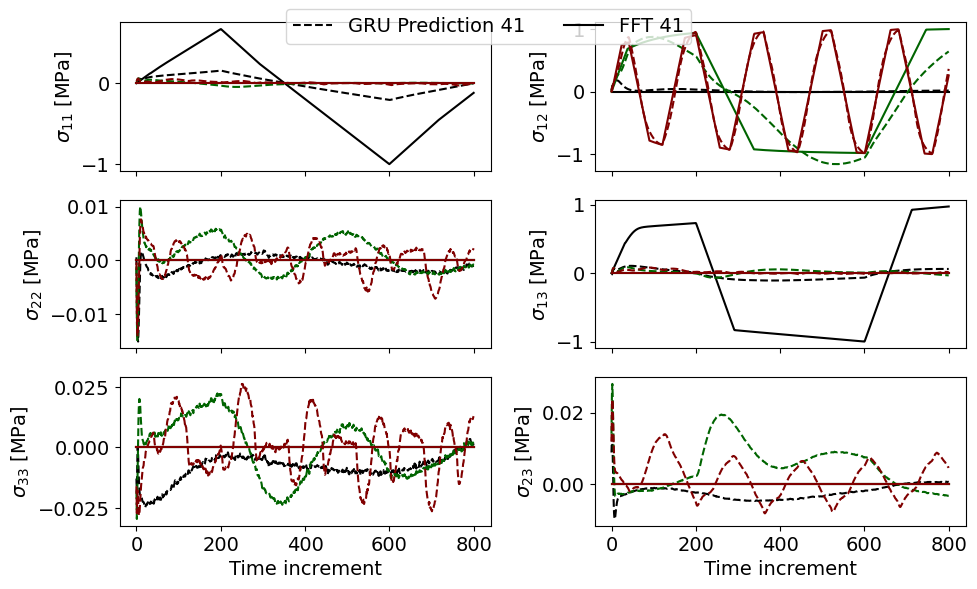

In [41]:

#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\transfer_to_MF_cyclic" +
 #              '\\transfer_MF_cyclic_model_lr0.0001_p2_dp0.5_robust_10k_scaled_data_batch128.pth')

loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\transfer_to_MF_cyclic" +
               '\\transfer_highRandom_to_MF_cyclic_model_lr0.0001_p10_dp0.5_robust_10k_scaled_data_batch128.pth')

#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
 #              '\\transfer_high_fidelity_model_lr0.001_p10__dp0.5_robust_500_scaled_data_batch8.pth')
# Load the pre-trained model
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(loading_dir))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Testing phase
#plot_test_sample(model, test_loader_mc,test_sample_id=None, stress_components=3)
plot_predictions(model, test_loader_mc, scalers_ymc) #, test_sample_id=None


dict_keys(['__header__', '__version__', '__globals__', 'X_test_fft12', 'X_train_fft12', 'X_valid_fft12', 'Y_test_fft12', 'Y_train_fft12', 'Y_valid_fft12'])
299
150
147


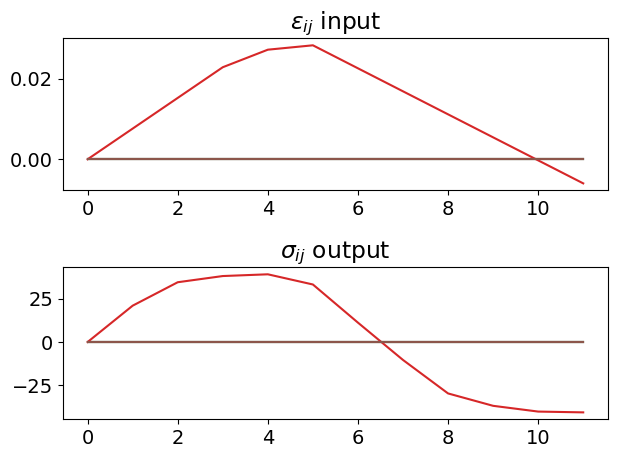

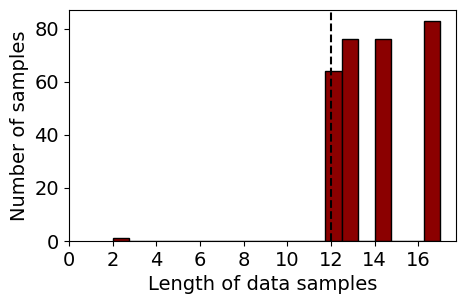

In [120]:
## Specific cases of Full-field data
# SHEAR 12
full_field_dir_path = r'D:\1_PhD_projects\3_code\Data_generation_for_finite_element_soutions\3D_RVE_FFT\3rd_WovenFullField_FFT_cyclic_shear12_only_mat_scaled.mat'
full_field_data_s12 = sio.loadmat(full_field_dir_path)
print(full_field_data_s12.keys())

training_size = 300
xtrain, ytrain, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_train_fft12'][0:training_size,:], full_field_data_s12['Y_train_fft12'][0:training_size,:])
xtest, ytest, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_test_fft12'], full_field_data_s12['Y_test_fft12'])
xval, yval, error_idx = clean_shear_fft_dataset(full_field_data_s12['X_valid_fft12'], full_field_data_s12['Y_valid_fft12'])
# Assuming xtrain and ytrain are numpy arrays of shape (1852, 12, 15) and (1852, 12, 6), respectively
#//////////////////////////////////////////////////////
new_l = 12
xtrain_interpolated_np = interpolate_time_series(xtrain, new_length=new_l)
ytrain_interpolated_np = interpolate_time_series(ytrain, new_length=new_l)

# Optionally, if you have validation or test datasets
xval_interpolated_np = interpolate_time_series(xval, new_length=new_l)
yval_interpolated_np = interpolate_time_series(yval, new_length=new_l)
xtest_interpolated_np = interpolate_time_series(xtest, new_length=new_l)
ytest_interpolated_np = interpolate_time_series(ytest, new_length=new_l)

sampl= random.randint(0,150)

fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(xval_interpolated_np[sampl,:,0:6])
ax1.set_title('$\epsilon_{ij}$ input')

ax2.plot(yval_interpolated_np[sampl,:,0:6])
ax2.set_title('$\sigma_{ij}$ output')
plt.tight_layout()

#WHY THE OUTPUT NORMALIZED VALUE IS BELOW ZERO FOR THIS PARTICULAR DATA SET AND NOT FOR THE REST OF DATA SETS???
# , x_scaler_fft_s12, y_scaler_fft_s12
train_loader_fft_s12, val_loader_fft_s12, test_loader_fft_s12 , x_scaler_fft_s12, y_scaler_fft_s12= turn_to_loader_shear(xtrain_interpolated_np,ytrain_interpolated_np,
                                                     xval_interpolated_np,yval_interpolated_np,
                                                     xtest_interpolated_np,ytest_interpolated_np, batch_size = 8)
import matplotlib.pyplot as plt

def plot_sequence_length(input_data, database_name):
    length = [sample.shape[1] for sample in input_data[:, 0]]  # Extracting the lengths of each sample from the original data
    
    # Plot histogram
    plt.figure(figsize=(5, 3))
    plt.hist(length, bins=20, color='darkred', edgecolor='black')
    plt.xlabel('Length of data samples',fontsize=14)
    plt.ylabel('Number of samples',fontsize=14)
    #plt.title(f'Distribution of Data Sample Lengths for "{database_name}"')

    # Add maximum and minimum borders
    max_length = max(length)
    min_length = min(length)
    plt.axvline(x=12, color='black', linestyle='--', label=f'Max Length: {max_length}')
    #plt.axvline(x=min_length, color='red', linestyle='--', label=f'Min Length: {min_length}')
    #plt.legend(fontsize=14)
    # Set x-axis ticks at intervals of 2
    plt.xticks(np.arange(0, max_length + 1, 2, dtype=int),fontsize=14)  # Set x-axis tick font size and ensure integer ticks
    #plt.grid()
    plt.savefig('FFT_s12_length_distribution_.eps', format='eps')
    plt.show()

# Example usage:
#plot_sequence_length(full_field_data['X_train_rand_FFT'], 'Random FFT Database')
plot_sequence_length(full_field_data_s12['X_train_fft12'][0:training_size,:], 'Random FFT Database')



In [121]:
full_field_data_s12['X_train_fft12'][0:300,:].shape

(300, 1)

In [122]:
ytrain_interpolated_np.shape

(299, 12, 6)

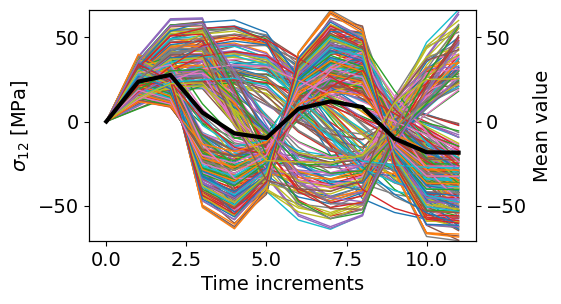

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


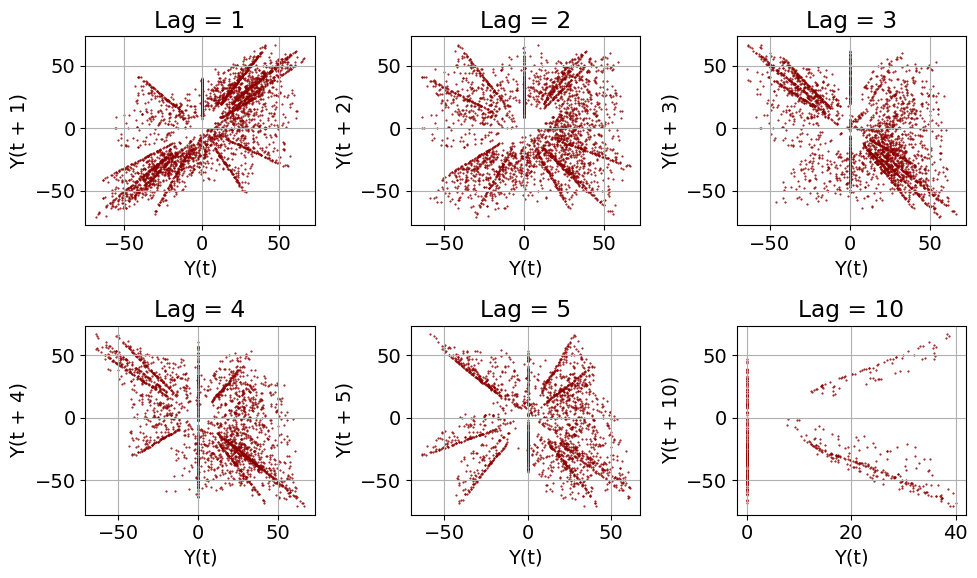

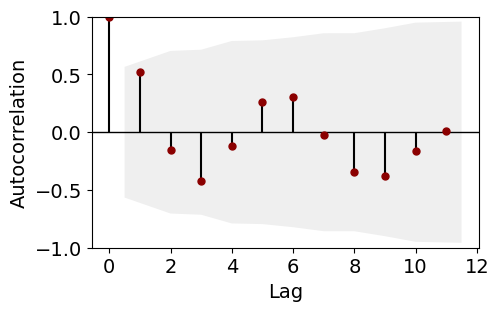

In [123]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib as mpl
from matplotlib.collections import PolyCollection, LineCollection

def plot_acf_colors(ax, markercolor="darkred", linecolor="black", facecolor="silver", barcolor="black", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    for item in ax.collections:
        # change the color of the confidence interval 
        if isinstance(item, PolyCollection):
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if isinstance(item, LineCollection):
            item.set_color(barcolor)
    # change the color of the markers
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    return ax



# Assume ytrain is a dataset with shape [num_samples, time_steps, features]
# We'll use the first component of each sample for plotting
component_index = 3

data_array=ytrain_interpolated_np #ytrain # 
# Plot the first component of each sample
import matplotlib.pyplot as plt

# Assuming data_array, component_index, and other variables are defined

# Create the main plot
fig, ax1 = plt.subplots(figsize=(5,3))

# Plot individual samples
for i in range(data_array.shape[0]):
    ax1.plot(data_array[i, :, component_index], linewidth=1, markersize=1)

# Set labels and legend for the main plot
ax1.set_xlabel('Time increments')
ax1.set_ylabel(r'$\sigma_{12}$ [MPa]')
#ax1.legend(['Sample Data'])
plt.tick_params(axis='both', which='major', labelsize=14)

# Create a twin axis for the mean plot
ax2 = ax1.twinx()

# Calculate mean between samples for each time step
mean_across_samples = np.mean(data_array[:, :, component_index], axis=0)

# Plot the mean on the secondary axis
ax2.plot(mean_across_samples, label='Mean across samples', linewidth=3, color='k')
ax2.set_ylabel('Mean value')
#ax2.legend(['Mean Across Samples'])
plt.tick_params(axis='both', which='major', labelsize=14)

# Align the zero line for both y-axes
all_data = np.concatenate([data_array[:, :, component_index].flatten(), mean_across_samples])
y_min, y_max = np.min(all_data), np.max(all_data)
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

# Save the plot
plt.savefig(f'sep2024_images/stress{component_index}_scatterAndMean_plot_101Interpolation_300samples_cyclic.eps', format='eps', bbox_inches='tight', dpi=300)

# Show the plot

plt.show()


# Plot autocorrelation using plot_acf
data = pd.DataFrame(data_array[:, :, component_index].T)
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot lag plots for lag values ranging from 1 to 50 with steps of 5
lag_values = [1,2,3,4,5,10]
for lag, ax in zip(lag_values, axes.flatten()):
    pd.plotting.lag_plot(data, lag=lag, marker='.', c='darkred',  ax=ax)
    ax.set_title(f'Lag = {lag}')
    ax.set_xlabel('Y(t)')
    ax.set_ylabel(f'Y(t + {lag})')
    ax.grid(True)
    ax.tick_params(axis='both', which='major')

    scatter = ax.collections[0]
    scatter.set_sizes([1])
# Adjust spacing between subplots
#plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
#plt.savefig(f'images_FFpaper/stress{component_index}_autocorrolation_lag_plot_12Interpolation_300samples.eps', format='eps',dpi=100)

#plt.show()


# Plot autocorrelation using plot_acf
# Assuming mean_across_samples is your data
data = pd.DataFrame(mean_across_samples)

f, ax = plt.subplots(figsize=(5, 3))
plot_acf(data.values.squeeze(), lags=11, ax=ax)
plot_acf_colors(ax)

# Customizing y-axis label
ax.set_xlabel('Lag',fontsize=14)
ax.set_ylabel('Autocorrelation',fontsize=14)

# Adjusting the number of y-axis ticks
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=7)
plt.tick_params(axis='both', which='major')
# Removing the title
plt.title('')

plt.savefig("sep2024_images/acf_s12_12_interpolation_12_lags_300samples_cyclic.eps", format='eps', bbox_inches='tight', dpi=300)
#plt.savefig("sep2024_images/acf_s12_12_interpolation_100lags_300samples.pdf")
plt.show()


Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 0.0532, Validation Loss: 0.0130, Learning Rate: 0.005

Epoch [2/2000], Training Loss: 0.0090, Validation Loss: 0.0069, Learning Rate: 0.005

Epoch [3/2000], Training Loss: 0.0047, Validation Loss: 0.0041, Learning Rate: 0.005

Epoch [4/2000], Training Loss: 0.0039, Validation Loss: 0.0045, Learning Rate: 0.005

Epoch [5/2000], Training Loss: 0.0029, Validation Loss: 0.0021, Learning Rate: 0.0045000000000000005

Epoch [6/2000], Training Loss: 0.0026, Validation Loss: 0.0039, Learning Rate: 0.0045000000000000005

Epoch [7/2000], Training Loss: 0.0024, Validation Loss: 0.0015, Learning Rate: 0.0045000000000000005

Epoch [8/2000], Training Loss: 0.0020, Validation Loss: 0.0009, Learning Rate: 0.0045000000000000005

Epoch [9/2000], Training Loss: 0.0011, Validation Loss: 0.0008, Learning Rate: 0.0045000000000000005

Epoch [10/2000], Training Loss: 0

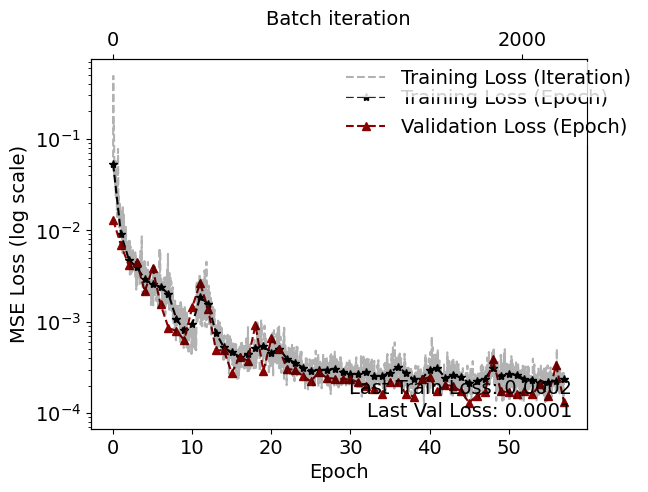

In [188]:
# Learning from Scratch on FFT cyclic S12
# replace with your save directory
model_highS12_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\specificLoadCases"

# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.005,
    'patience': 12,
    'seed': 42,
    'save_directory': model_highS12_directory,
}
# Define the model name using hyperparameters
model_name = f'\\from_scratch_using{training_size}samples_S12FFT_101timeintervals_model_{hyperparameters["learning_rate"]}_{hyperparameters["patience"]}_robust_scaled_data_batch8_timesteps101.pth' 

# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name


# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_fft_s12, val_loader=val_loader_fft_s12, test_loader=test_loader_fft_s12, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Evaluate on test set
trainer.evaluate_test_set()

# Plot loss function
trainer.plot_loss_function()

Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 3.3546, Validation Loss: 0.0718, Learning Rate: 0.005

Epoch [2/2000], Training Loss: 0.0631, Validation Loss: 0.0388, Learning Rate: 0.005

Epoch [3/2000], Training Loss: 0.0287, Validation Loss: 0.0169, Learning Rate: 0.005

Epoch [4/2000], Training Loss: 0.0163, Validation Loss: 0.0126, Learning Rate: 0.005

Epoch [5/2000], Training Loss: 0.0121, Validation Loss: 0.0106, Learning Rate: 0.0045000000000000005

Epoch [6/2000], Training Loss: 0.0099, Validation Loss: 0.0083, Learning Rate: 0.0045000000000000005

Epoch [7/2000], Training Loss: 0.0086, Validation Loss: 0.0079, Learning Rate: 0.0045000000000000005

Epoch [8/2000], Training Loss: 0.0078, Validation Loss: 0.0084, Learning Rate: 0.0045000000000000005

Epoch [9/2000], Training Loss: 0.0070, Validation Loss: 0.0068, Learning Rate: 0.0045000000000000005

Epoch [10/2000], Training Loss: 0.0064, Validation Loss: 

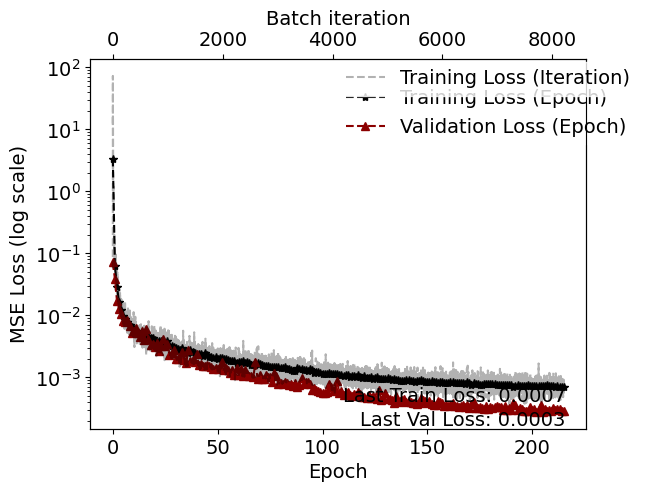

Test Loss: 0.0003


In [174]:
## Transfer learning from FFT random to S12 FFT simulations WITHOUT any physical invariants:

# replace with your save directory
saving_path = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" 

loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\transfer_to_MF_cyclic" +
               '\\transfer_highRandom_to_MF_cyclic_model_lr0.0001_p10_dp0.5_robust_10k_scaled_data_batch128.pth')

#loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
 #              '\\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth')
#loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model"+
 #              '\\transfer_low_to_high_fidelity_model_0.001_30_robust_scaled.pth')
# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.005,
    'patience': 10,
    'seed': 42,
    'save_directory': saving_path,  # replace with pretrained saved model directory
    #'model_name': f'\\trans_low_To_High_random_To_Shear12_High_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth', 
    'pretrained_model_path': loading_pretrained_model
}

model_name = f'\\trans_MFHrnadom_To_MFHcyclic_To_{training_size}samplesOfShear12_FFT_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}_dp0.5_robust12_2664_scaled_data_batch8_timeSteps12.pth'
hyperparameters['model_name'] = model_name

# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_fft_s12, val_loader=val_loader_fft_s12, test_loader=test_loader_fft_s12, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Plot loss function
trainer.plot_loss_function()

# Evaluate on test set
trainer.evaluate_test_set()

#using 1000 full-field as the source model results in Test Loss: 0.0088 but not a good prediction
#using only 500 full-field and transfer learning results in Test Loss: 0.0093 and not a good prediction

# Best performance original model using 100 samples --> Test Loss: 

# Best original from scratch model using 300 samples in training--> 

# best performance using 500 samples in training --> Test Loss: 0.1261

# Best original from scratch model using ~800 samples--> Test Loss: 0.03 


GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)
Processing sample 30
Processing sample 49
Processing sample 113


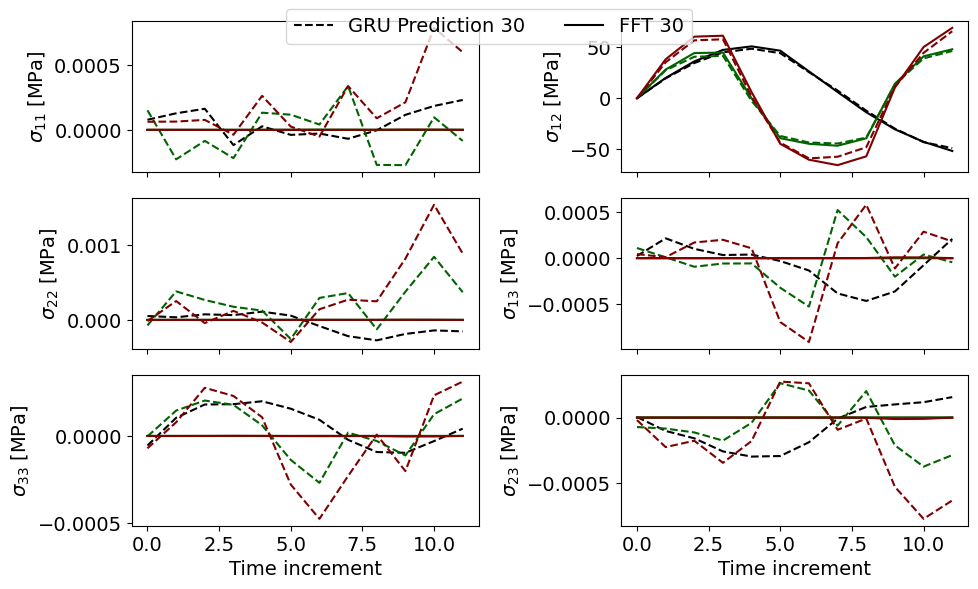

In [175]:
#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models" +
#               '\\transfer_high_fidelity_model_lr0.001_p10__dp0.5_robust_500_scaled_data_batch8.pth')

#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
#               '\\transfer_high_fidelity_model_lr0.001_p10__dp0.5_robust_500_scaled_data_batch8.pth')

#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" +
#               '\\trans_lowCyclicToShear12High_model_lr0.001_p10_dp0.5_robust12_1852_scaled_data_batch8_timeSteps101.pth')
# # MFH random to MFH cyclic to S12-FFT:
#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" +
#               '\\trans_MFHrnadom_To_MFHcyclic_To_Shear12_FFT_model_lr0.005_p10_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth')
# random MFH to random FFt to s12 FFT
####loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" +
#               '\\trans_MFHrnadom_To_MFHcyclic_To_300samplesOfShear12_FFT_model_lr0.005_p10_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth')
#               '\\trans_lowToHighrandomToShear12High_model_lr0.0001_p10_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth')
                  #trans_lowToHighrandomToShear12High_model_lr0.001_p10_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101
### from scratch:
loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\specificLoadCases" +
             '\\from_scratch_using300samples_S12FFT_101timeintervals_model_0.005_12_robust_scaled_data_batch8_timesteps12.pth')
#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\specificLoadCases" +
 #              '\\from_scratch_S12_12timeintervals_high_fidelity_model_0.005_12_robust_scaled_data_batch8_timesteps101.pth')

#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\specificLoadCases"+
 #              '\\from_scratch_S12_101timeintervals_high_fidelity_model_0.005_12_robust_scaled_data_batch8_timesteps101.pth')
# Load the pre-trained model
model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(loading_dir))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Testing phase
#plot_test_sample(model, test_loader_fft_s12, test_sample_id=None, stress_components = 3)
#plot_test_sample(model, test_loader_f,scalers=y_scaler_f, test_sample_id=78, stress_components = 1)

plot_predictions(model, test_loader_fft_s12, y_scaler_fft_s12, test_sample_ids=[30,49,113]) #good:30,49,113

In [ ]:
#plot_predictions(model, test_loader_f, y_scaler_f, test_sample_id=None) #good:33

In [189]:
#from scratch:
#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\specificLoadCases"+
#               '\\from_scratch_S12_101timeintervals_high_fidelity_model_0.005_12_robust_scaled_data_batch8_timesteps101.pth')
loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\specificLoadCases" +
             '\\from_scratch_using300samples_S12FFT_101timeintervals_model_0.005_12_robust_scaled_data_batch8_timesteps101.pth')
# MFH random to MFH cyclic to S12-FFT:
#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" +
#               '\\trans_MFHrnadom_To_MFHcyclic_To_Shear12_FFT_model_lr0.005_p10_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth')

# MFH random to FFT random to S12 FFT
#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" +
#               '\\trans_lowToHighrandomToShear12High_model_lr0.0001_p10_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth')
##loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" +
##               '\\trans_MFHrnadom_To_MFHcyclic_To_300samplesOfShear12_FFT_model_lr0.005_p10_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth')
# MFH random to FFT random
#loading_dir = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model"+
 #              '\\transfer_low_to_high_fidelity_model_0.001_30_robust_scaled.pth')

model = GRUModel(input_size=15, hidden_size=512, output_size=6, dropout=0.5)
model.load_state_dict(torch.load(loading_dir))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

evaluate_stress_errors(model, test_loader_fft_s12, y_scaler_fft_s12)

GRUModel(
  (gru1): GRU(15, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)
The model parameters are on cuda
+-----------------------------------------------------+------------+--------------------------+
| Mean RMSE over time steps (w.r.t. von Mises stress) | Mean [MPa] | Standard Deviation [MPa] |
+-----------------------------------------------------+------------+--------------------------+
|                      von Mises                      |    1.4     |           1.7            |
|                     Component 1                     |    0.0     |           0.0            |
|                     Component 2                     |    0.0     |           0.0            |
|                     Component 3                     |    0.0     |           0.0            |
|                     Component 4                     |    1.1     |           0.7            |
|                     Componen

(1.3967199,
 {0: 2.143091e-05,
  1: 1.2638929e-05,
  2: 7.0250353e-06,
  3: 1.0591205,
  4: 0.004179343,
  5: 3.578249e-07},
 {0: 3.8138207e-06,
  1: 3.5895748e-06,
  2: 5.2350066e-07,
  3: -0.26542935,
  4: -0.0006526505,
  5: 2.0708073e-08})

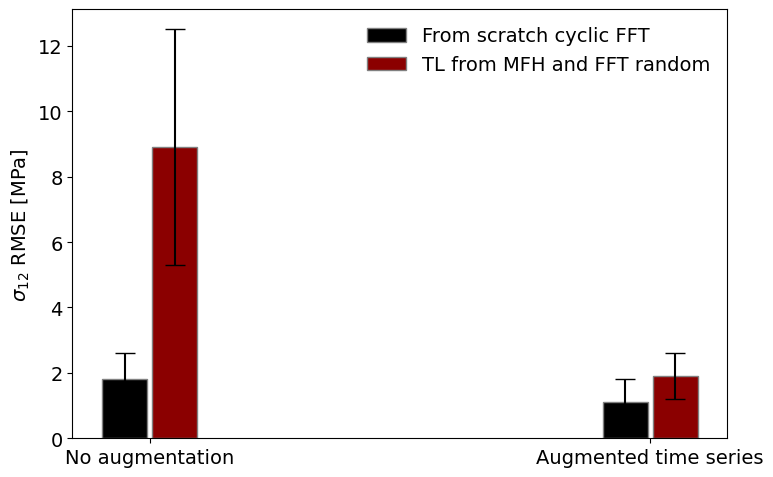

In [17]:
# ERROR plot for S12 FFT dataset using three following networks:

# Define the data
categories = ['No augmentation', 'Augmented time series']
mean_ = [1.8, 1.1]
std_ = [.8,.7]

mean_tl = [8.9,1.9]
std_tl = [3.6, 0.7]


barWidth = 0.09  # Adjusted bar width
space = 0.01    # Reduced space between bars

# Set the position of bar on X axis
r1 = np.arange(len(categories))
r2 = [x + barWidth + space for x in r1]
#r3 = [x + 2 * (barWidth + space) for x in r1]
#r4 = [x + 3 * (barWidth + space) for x in r1]

# Create the bar plot
plt.figure(figsize=(8,5))
plt.bar(r1, mean_, color='black', width=barWidth, edgecolor='grey', yerr=std_, capsize=7, label='From scratch cyclic FFT')
plt.bar(r2, mean_tl, color='darkred', width=barWidth, edgecolor='grey', yerr=std_tl, capsize=7, label='TL from MFH and FFT random')
#plt.bar(r3, fine_tuned_network_means, color='darkgreen', hatch='x', width=barWidth, edgecolor='grey', yerr=fine_tuned_network_stds, capsize=7, label='Trained on MFH and fine-tuned with FFT samples')
#plt.bar(r4, fine_tuned_s12_network_means, color='darkorange', width=barWidth, edgecolor='grey', yerr=fine_tuned_s12_network_stds, capsize=7, label='Fine-tuned again with FFT cyclic pure shear samples')

# Add xticks on the middle of the group bars
plt.xticks([r + 0.5 * (barWidth + space) for r in range(len(categories))], categories)
plt.ylabel('$\sigma_{12}$ RMSE [MPa]', fontsize=14)
#plt.ylim(-100, 160)  # Adjust the upper limit as needed

# Create the legend & Show the plot
plt.legend(loc='upper right',frameon=False)
plt.tight_layout()
plt.savefig('performance_comparison_S12FFT.eps', bbox_inches='tight', dpi=300)



dict_keys(['__header__', '__version__', '__globals__', 'X_test_fft23', 'X_train_fft23', 'X_valid_fft23', 'Y_test_fft23', 'Y_train_fft23', 'Y_valid_fft23'])
93
207
205


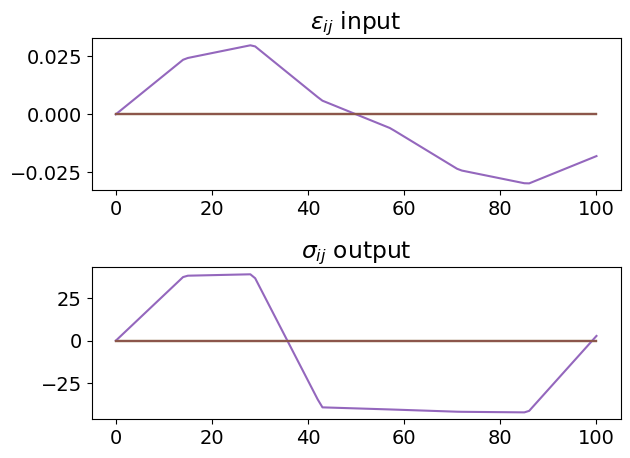

In [23]:
# SHEAR 23
full_field_dir_path = r'D:\1_PhD_projects\3_code\Data_generation_for_finite_element_soutions\3D_RVE_FFT\3rd_WovenFullField_FFT_cyclic_shear23_only_mat_scaled.mat'
full_field_data_s23 = sio.loadmat(full_field_dir_path)
print(full_field_data_s23.keys())

training_size= 100
xtrain, ytrain, error_idx = clean_shear_fft_dataset(full_field_data_s23['X_train_fft23'][0:training_size,:], full_field_data_s23['Y_train_fft23'][0:training_size,:])
xtest, ytest, error_idx = clean_shear_fft_dataset(full_field_data_s23['X_test_fft23'], full_field_data_s23['Y_test_fft23'])
xval, yval, error_idx = clean_shear_fft_dataset(full_field_data_s23['X_valid_fft23'], full_field_data_s23['Y_valid_fft23'])


new_l = 101
xtrain_interpolated_np = interpolate_time_series(xtrain, new_length=new_l)
ytrain_interpolated_np = interpolate_time_series(ytrain, new_length=new_l)

# Optionally, if you have validation or test datasets
xval_interpolated_np = interpolate_time_series(xval, new_length=new_l)
yval_interpolated_np = interpolate_time_series(yval, new_length=new_l)
xtest_interpolated_np = interpolate_time_series(xtest, new_length=new_l)
ytest_interpolated_np = interpolate_time_series(ytest, new_length=new_l)

sampl= random.randint(0,150)

fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(xval_interpolated_np[sampl,:,0:6])
ax1.set_title('$\epsilon_{ij}$ input')

ax2.plot(yval_interpolated_np[sampl,:,0:6])
ax2.set_title('$\sigma_{ij}$ output')
plt.tight_layout()


#
train_loader_fft_s23, val_loader_fft_s23, test_loader_fft_s23 , x_scaler_fft_s23, y_scaler_fft_s23= turn_to_loader_shear(xtrain,ytrain,
                                                     xval,yval,
                                                     xtest,ytest, batch_size = 8)



In [24]:
xtrain.shape

(93, 8, 15)

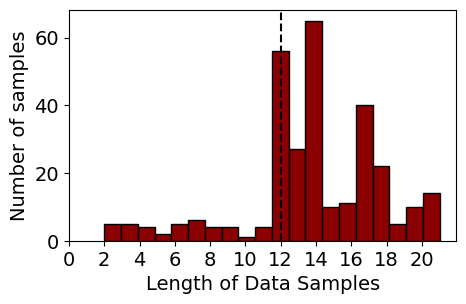

In [25]:
import matplotlib.pyplot as plt

def plot_sequence_length(input_data, database_name):
    length = [sample.shape[1] for sample in input_data[:, 0]]  # Extracting the lengths of each sample

    # Plot histogram
    plt.figure(figsize=(5,3))
    plt.hist(length, bins=20, color='darkred', edgecolor='black')
    plt.xlabel('Length of Data Samples',fontsize=14)
    plt.ylabel('Number of samples',fontsize=14)
    #plt.title(f'Distribution of Data Sample Lengths for "{database_name}"')

    # Add maximum and minimum borders
    max_length = max(length)
    min_length = min(length)
    plt.axvline(x=12, color='black', linestyle='--', label=f'Max Length: {max_length}')
    #plt.axvline(x=min_length, color='red', linestyle='--', label=f'Min Length: {min_length}')
    #plt.legend(fontsize=14)
    # Set x-axis ticks at intervals of 2
    plt.xticks(np.arange(0, max_length + 1, 2, dtype=int))  # Set x-axis tick font size and ensure integer ticks
    #plt.grid()
    plt.savefig(f'images_FFpaper/FFT_length_s23_plot_300samples.eps', format='eps')
    plt.show()

# Example usage:
plot_sequence_length(full_field_data_s23['X_train_fft23'][0:300,:], 'Random FFT Database')
#plt.savefig('images_FFpaper/FFT_s23_length_distribution.eps', format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


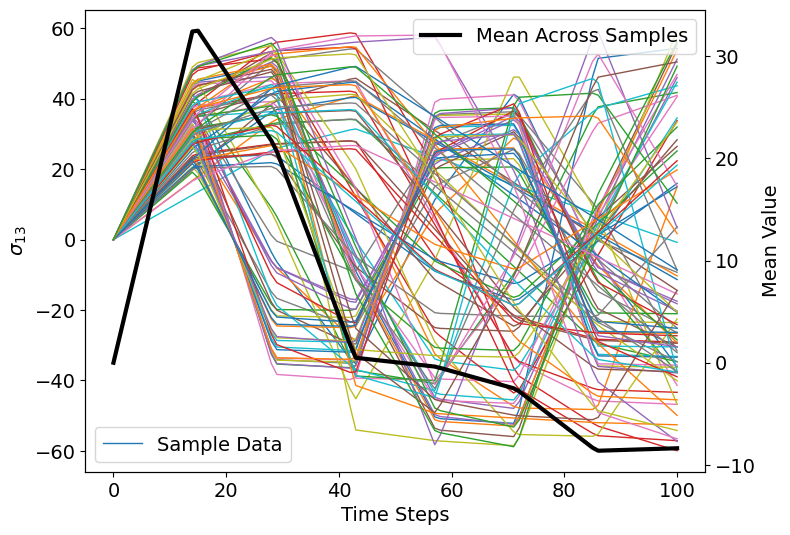

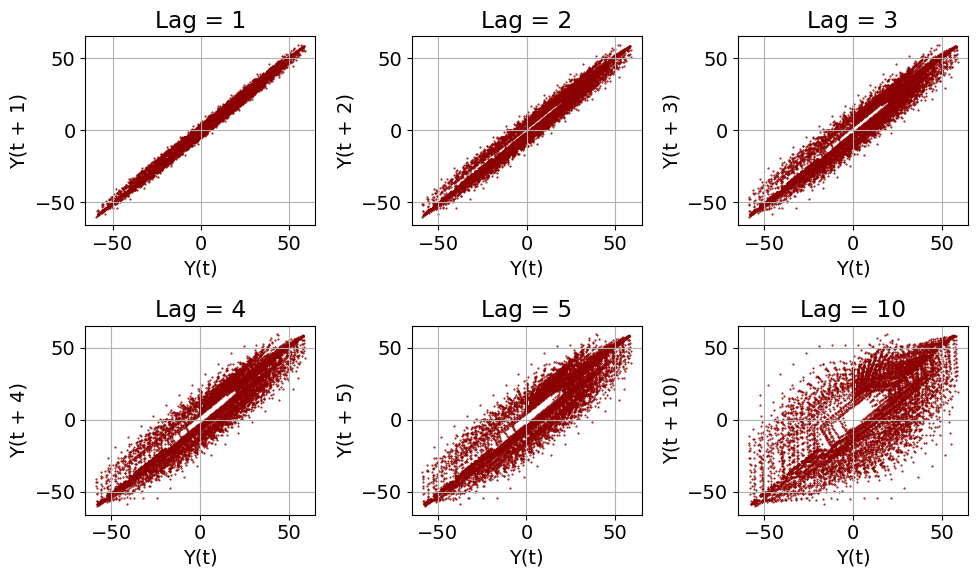

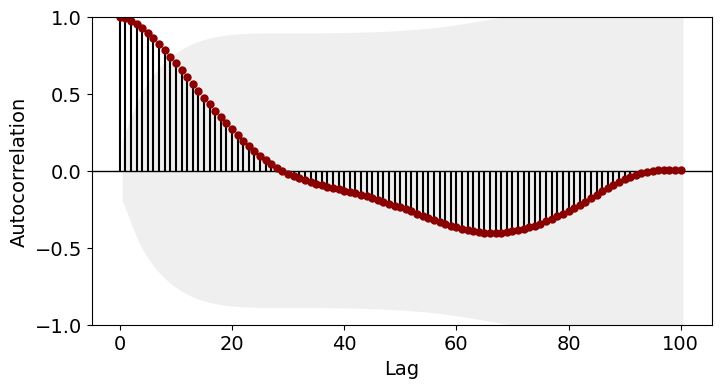

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib as mpl
from matplotlib.collections import PolyCollection, LineCollection

def plot_acf_colors(ax, markercolor="darkred", linecolor="black", facecolor="silver", barcolor="black", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    for item in ax.collections:
        # change the color of the confidence interval 
        if isinstance(item, PolyCollection):
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if isinstance(item, LineCollection):
            item.set_color(barcolor)
    # change the color of the markers
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    return ax



# Assume ytrain is a dataset with shape [num_samples, time_steps, features]
# We'll use the first component of each sample for plotting
component_index = 4

data_array=ytrain_interpolated_np #ytrain # 
# Plot the first component of each sample
import matplotlib.pyplot as plt

# Assuming data_array, component_index, and other variables are defined

# Create the main plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot individual samples
for i in range(data_array.shape[0]):
    ax1.plot(data_array[i, :, component_index], linewidth=1, markersize=1)

# Set labels and legend for the main plot
ax1.set_xlabel('Time Steps')
ax1.set_ylabel(r'$\sigma_{13}$')
ax1.legend(['Sample Data'])
plt.tick_params(axis='both', which='major', labelsize=14)

# Create a twin axis for the mean plot
ax2 = ax1.twinx()

# Calculate mean between samples for each time step
mean_across_samples = np.mean(data_array[:, :, component_index], axis=0)

# Plot the mean on the secondary axis
ax2.plot(mean_across_samples, label='Mean Across Samples', linewidth=3, color='k')
ax2.set_ylabel('Mean Value')
ax2.legend(['Mean Across Samples'])
plt.tick_params(axis='both', which='major', labelsize=14)

# Save the plot
plt.savefig(f'images_FFpaper/stress{component_index}_scatterAndMean_plot_23Interpolation.eps', format='eps')

# Show the plot

plt.show()


# Plot autocorrelation using plot_acf
data = pd.DataFrame(data_array[:, :, component_index].T)
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot lag plots for lag values ranging from 1 to 50 with steps of 5
lag_values = [1,2,3,4,5,10]
for lag, ax in zip(lag_values, axes.flatten()):
    pd.plotting.lag_plot(data, lag=lag, marker='.', c='darkred',  ax=ax)
    ax.set_title(f'Lag = {lag}')
    ax.set_xlabel('Y(t)')
    ax.set_ylabel(f'Y(t + {lag})')
    ax.grid(True)
    ax.tick_params(axis='both', which='major')

    scatter = ax.collections[0]
    scatter.set_sizes([1])
# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
#plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
#plt.savefig(f'images_FFpaper/stress{component_index}_autocorrolation_lag_plot_23Interpolation.eps', format='eps',dpi=100)

plt.show()


# Plot autocorrelation using plot_acf
# Assuming mean_across_samples is your data
data = pd.DataFrame(mean_across_samples)

f, ax = plt.subplots(figsize=(8, 4))
plot_acf(data.values.squeeze(), lags=100, ax=ax)
plot_acf_colors(ax)

# Customizing y-axis label
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

# Adjusting the number of y-axis ticks
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=6)
plt.tick_params(axis='both', which='major', labelsize=14)
# Removing the title
plt.title('')

#plt.savefig("images_FFpaper/acf_s23_12_interpolation_100lags.eps")
#plt.savefig("images_FFpaper/acf_s23_12_interpolation_100lags.pdf")
plt.show()


Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 10008.9684, Validation Loss: 8622.4170, Learning Rate: 0.005

Epoch [2/2000], Training Loss: 9981.8593, Validation Loss: 8590.3301, Learning Rate: 0.005

Epoch [3/2000], Training Loss: 9903.6627, Validation Loss: 8551.6816, Learning Rate: 0.005

Epoch [4/2000], Training Loss: 11007.0627, Validation Loss: 8524.2705, Learning Rate: 0.005

Epoch [5/2000], Training Loss: 9724.8013, Validation Loss: 8496.2373, Learning Rate: 0.0045000000000000005

Epoch [6/2000], Training Loss: 9591.4205, Validation Loss: 8485.8887, Learning Rate: 0.0045000000000000005

Epoch [7/2000], Training Loss: 9530.0366, Validation Loss: 8468.8135, Learning Rate: 0.0045000000000000005

Epoch [8/2000], Training Loss: 9445.9910, Validation Loss: 8457.8457, Learning Rate: 0.0045000000000000005

Epoch [9/2000], Training Loss: 12893.7583, Validation Loss: 8456.5312, Learning Rate:

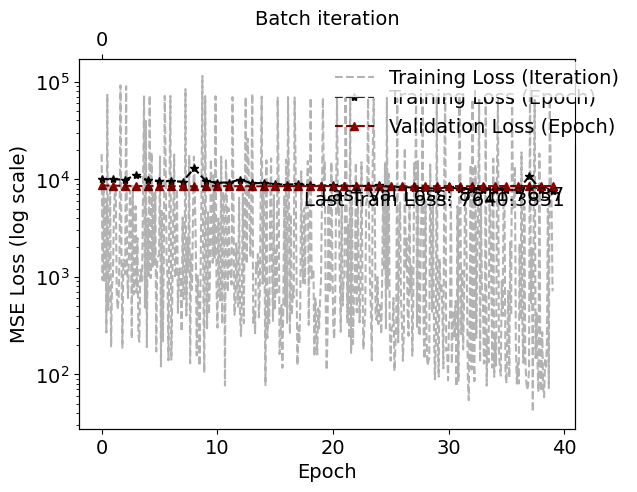

In [155]:
# Learning from Scratch on FFT cyclic S23
# replace with your save directory
model_highS23_directory = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\from_scratch_high_fidelity_models\specificLoadCases"

# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.005,
    'patience': 12,
    'seed': 42,
    'save_directory': model_highS23_directory,
}
# Define the model name using hyperparameters
model_name = f'\\from_scratch_using{training_size}samples_S23_FFT_101timeintervals_model_{hyperparameters["learning_rate"]}_{hyperparameters["patience"]}_robust_scaled_data_batch8_timesteps101.pth' 

# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name


# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_fft_s23, val_loader=val_loader_fft_s23, test_loader=test_loader_fft_s23, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Evaluate on test set
trainer.evaluate_test_set()

# Plot loss function
trainer.plot_loss_function()

Model loaded from pretrained RNN
initial parameter space shape:  torch.Size([1536, 15])

Epoch [1/2000], Training Loss: 10048.3599, Validation Loss: 8597.2236, Learning Rate: 0.005

Epoch [2/2000], Training Loss: 10322.6102, Validation Loss: 8600.5547, Learning Rate: 0.005

Epoch [3/2000], Training Loss: 9824.0715, Validation Loss: 8582.4004, Learning Rate: 0.005

Epoch [4/2000], Training Loss: 10139.6990, Validation Loss: 8563.4346, Learning Rate: 0.005

Epoch [5/2000], Training Loss: 10569.0488, Validation Loss: 8537.4121, Learning Rate: 0.0045000000000000005

Epoch [6/2000], Training Loss: 9622.3404, Validation Loss: 8505.7168, Learning Rate: 0.0045000000000000005

Epoch [7/2000], Training Loss: 9562.5689, Validation Loss: 8487.1621, Learning Rate: 0.0045000000000000005

Epoch [8/2000], Training Loss: 9505.2295, Validation Loss: 8492.4014, Learning Rate: 0.0045000000000000005

Epoch [9/2000], Training Loss: 9441.1623, Validation Loss: 8464.3662, Learning Rate: 0.0045000000000000005


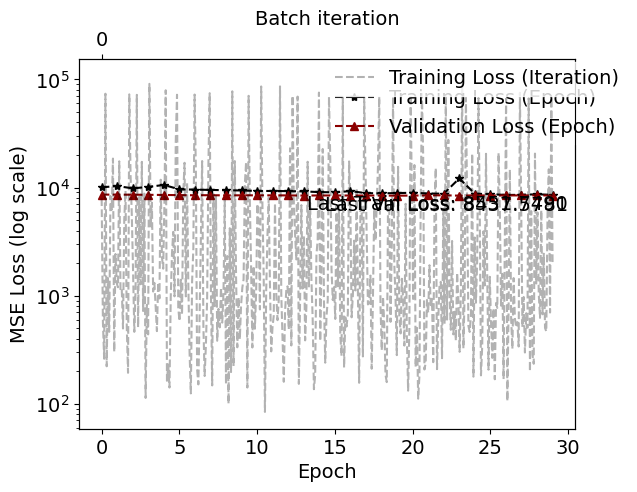

Test Loss: 743.3182


In [156]:
## Transfer learning from FFT random to S12 FFT simulations WITHOUT any physical invariants:

# replace with your save directory
saving_path = r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model\specific_load_cases" 

loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\transfer_to_MF_cyclic" +
               '\\transfer_highRandom_to_MF_cyclic_model_lr0.0001_p10_dp0.5_robust_10k_scaled_data_batch128.pth')

#loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model" +
 #              '\\transfer_lowTohigh_random_model_lr0.0001_p20__dp0.5_robust_787_scaled_data_batch8_timesteps101.pth')
#loading_pretrained_model = (r"D:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_\Transfer_model"+
 #              '\\transfer_low_to_high_fidelity_model_0.001_30_robust_scaled.pth')
# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 15,
    'hidden_size': 512,
    'output_size': 6,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.005,
    'patience': 10,
    'seed': 42,
    'save_directory': saving_path,  # replace with pretrained saved model directory
    #'model_name': f'\\trans_low_To_High_random_To_Shear12_High_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth', 
    'pretrained_model_path': loading_pretrained_model
}

model_name = f'\\trans_MFHrnadom_To_MFHcyclic_To_{training_size}samplesOfShear23_FFT_model_lr{hyperparameters["learning_rate"]}_p{hyperparameters["patience"]}_dp0.5_robust12_2664_scaled_data_batch8_timeSteps101.pth'
hyperparameters['model_name'] = model_name

# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_fft_s23, val_loader=val_loader_fft_s23, test_loader=test_loader_fft_s23, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Plot loss function
trainer.plot_loss_function()

# Evaluate on test set
trainer.evaluate_test_set()

-------------------------------------------------------------------------
-------------------------------------------------------------------------